In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "resnet_ce_mse"
ood = "0:1:2:3:4"

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 77xb9byl


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-77xb9byl:best, 58.49MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    fpi = 5

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            rcn = x
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        rcn = x
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                             | 0/5208 [00:00<?, ?it/s]

  0%|                                                                     | 1/5208 [00:00<48:32,  1.79it/s]

  0%|                                                                     | 3/5208 [00:00<16:02,  5.41it/s]

  0%|                                                                     | 5/5208 [00:00<10:11,  8.51it/s]

  0%|                                                                     | 7/5208 [00:00<07:48, 11.11it/s]

  0%|                                                                     | 9/5208 [00:00<06:34, 13.17it/s]

  0%|▏                                                                   | 11/5208 [00:01<05:52, 14.75it/s]

  0%|▏                                                                   | 13/5208 [00:01<05:25, 15.94it/s]

  0%|▏                                                                   | 15/5208 [00:01<05:09, 16.80it/s]

  0%|▏                                                                   | 17/5208 [00:01<04:57, 17.42it/s]

  0%|▏                                                                   | 19/5208 [00:01<04:50, 17.87it/s]

  0%|▎                                                                   | 21/5208 [00:01<04:45, 18.19it/s]

  0%|▎                                                                   | 23/5208 [00:01<04:41, 18.41it/s]

  0%|▎                                                                   | 25/5208 [00:01<04:39, 18.57it/s]

  1%|▎                                                                   | 27/5208 [00:01<04:37, 18.70it/s]

  1%|▍                                                                   | 29/5208 [00:02<04:35, 18.77it/s]

  1%|▍                                                                   | 31/5208 [00:02<04:34, 18.84it/s]

  1%|▍                                                                   | 33/5208 [00:02<04:33, 18.89it/s]

  1%|▍                                                                   | 35/5208 [00:02<04:33, 18.92it/s]

  1%|▍                                                                   | 37/5208 [00:02<04:33, 18.93it/s]

  1%|▌                                                                   | 39/5208 [00:02<04:32, 18.96it/s]

  1%|▌                                                                   | 41/5208 [00:02<04:32, 18.97it/s]

  1%|▌                                                                   | 43/5208 [00:02<04:32, 18.97it/s]

  1%|▌                                                                   | 45/5208 [00:02<04:31, 18.99it/s]

  1%|▌                                                                   | 47/5208 [00:02<04:31, 18.99it/s]

  1%|▋                                                                   | 49/5208 [00:03<04:31, 19.00it/s]

  1%|▋                                                                   | 51/5208 [00:03<04:31, 18.99it/s]

  1%|▋                                                                   | 53/5208 [00:03<04:31, 18.99it/s]

  1%|▋                                                                   | 55/5208 [00:03<04:31, 19.00it/s]

  1%|▋                                                                   | 57/5208 [00:03<04:31, 19.00it/s]

  1%|▊                                                                   | 59/5208 [00:03<04:30, 19.01it/s]

  1%|▊                                                                   | 61/5208 [00:03<04:30, 18.99it/s]

  1%|▊                                                                   | 63/5208 [00:03<04:30, 18.99it/s]

  1%|▊                                                                   | 65/5208 [00:03<04:31, 18.97it/s]

  1%|▊                                                                   | 67/5208 [00:04<04:30, 18.98it/s]

  1%|▉                                                                   | 69/5208 [00:04<04:30, 18.98it/s]

  1%|▉                                                                   | 71/5208 [00:04<04:30, 18.98it/s]

  1%|▉                                                                   | 73/5208 [00:04<04:30, 18.99it/s]

  1%|▉                                                                   | 75/5208 [00:04<04:30, 19.00it/s]

  1%|█                                                                   | 77/5208 [00:04<04:29, 19.01it/s]

  2%|█                                                                   | 79/5208 [00:04<04:30, 18.99it/s]

  2%|█                                                                   | 81/5208 [00:04<04:29, 19.00it/s]

  2%|█                                                                   | 83/5208 [00:04<04:29, 19.00it/s]

  2%|█                                                                   | 85/5208 [00:04<04:29, 18.97it/s]

  2%|█▏                                                                  | 87/5208 [00:05<04:29, 18.97it/s]

  2%|█▏                                                                  | 89/5208 [00:05<04:29, 18.97it/s]

  2%|█▏                                                                  | 91/5208 [00:05<04:29, 18.98it/s]

  2%|█▏                                                                  | 93/5208 [00:05<04:29, 18.97it/s]

  2%|█▏                                                                  | 95/5208 [00:05<04:29, 18.99it/s]

  2%|█▎                                                                  | 97/5208 [00:05<04:28, 19.01it/s]

  2%|█▎                                                                  | 99/5208 [00:05<04:28, 18.99it/s]

  2%|█▎                                                                 | 101/5208 [00:05<04:28, 18.99it/s]

  2%|█▎                                                                 | 103/5208 [00:05<04:28, 19.00it/s]

  2%|█▎                                                                 | 105/5208 [00:06<04:28, 19.00it/s]

  2%|█▍                                                                 | 107/5208 [00:06<04:28, 18.99it/s]

  2%|█▍                                                                 | 109/5208 [00:06<04:28, 19.00it/s]

  2%|█▍                                                                 | 111/5208 [00:06<04:28, 19.01it/s]

  2%|█▍                                                                 | 113/5208 [00:06<04:28, 19.00it/s]

  2%|█▍                                                                 | 115/5208 [00:06<04:27, 19.01it/s]

  2%|█▌                                                                 | 117/5208 [00:06<04:27, 19.02it/s]

  2%|█▌                                                                 | 119/5208 [00:06<04:27, 19.02it/s]

  2%|█▌                                                                 | 121/5208 [00:06<04:27, 19.00it/s]

  2%|█▌                                                                 | 123/5208 [00:06<04:27, 19.01it/s]

  2%|█▌                                                                 | 125/5208 [00:07<04:27, 19.01it/s]

  2%|█▋                                                                 | 127/5208 [00:07<04:27, 19.01it/s]

  2%|█▋                                                                 | 129/5208 [00:07<04:27, 19.01it/s]

  3%|█▋                                                                 | 131/5208 [00:07<04:27, 19.01it/s]

  3%|█▋                                                                 | 133/5208 [00:07<04:26, 19.02it/s]

  3%|█▋                                                                 | 135/5208 [00:07<04:26, 19.00it/s]

  3%|█▊                                                                 | 137/5208 [00:07<04:26, 19.00it/s]

  3%|█▊                                                                 | 139/5208 [00:07<04:26, 19.01it/s]

  3%|█▊                                                                 | 141/5208 [00:07<04:26, 19.00it/s]

  3%|█▊                                                                 | 143/5208 [00:08<04:26, 19.01it/s]

  3%|█▊                                                                 | 145/5208 [00:08<04:26, 19.00it/s]

  3%|█▉                                                                 | 147/5208 [00:08<04:26, 18.99it/s]

  3%|█▉                                                                 | 149/5208 [00:08<04:26, 18.97it/s]

  3%|█▉                                                                 | 151/5208 [00:08<04:26, 18.98it/s]

  3%|█▉                                                                 | 153/5208 [00:08<04:26, 18.98it/s]

  3%|█▉                                                                 | 155/5208 [00:08<04:26, 18.97it/s]

  3%|██                                                                 | 157/5208 [00:08<04:26, 18.98it/s]

  3%|██                                                                 | 159/5208 [00:08<04:25, 18.99it/s]

  3%|██                                                                 | 161/5208 [00:08<04:25, 18.99it/s]

  3%|██                                                                 | 163/5208 [00:09<04:25, 18.98it/s]

  3%|██                                                                 | 165/5208 [00:09<04:25, 18.99it/s]

  3%|██▏                                                                | 167/5208 [00:09<04:25, 18.99it/s]

  3%|██▏                                                                | 169/5208 [00:09<04:25, 18.98it/s]

  3%|██▏                                                                | 171/5208 [00:09<04:25, 18.98it/s]

  3%|██▏                                                                | 173/5208 [00:09<04:25, 19.00it/s]

  3%|██▎                                                                | 175/5208 [00:09<04:24, 19.00it/s]

  3%|██▎                                                                | 177/5208 [00:09<04:24, 18.99it/s]

  3%|██▎                                                                | 179/5208 [00:09<04:24, 19.01it/s]

  3%|██▎                                                                | 181/5208 [00:10<04:24, 19.01it/s]

  4%|██▎                                                                | 183/5208 [00:10<04:24, 19.00it/s]

  4%|██▍                                                                | 185/5208 [00:10<04:24, 19.00it/s]

  4%|██▍                                                                | 187/5208 [00:10<04:24, 19.00it/s]

  4%|██▍                                                                | 189/5208 [00:10<04:24, 19.01it/s]

  4%|██▍                                                                | 191/5208 [00:10<04:24, 19.00it/s]

  4%|██▍                                                                | 193/5208 [00:10<04:23, 19.00it/s]

  4%|██▌                                                                | 195/5208 [00:10<04:23, 19.01it/s]

  4%|██▌                                                                | 197/5208 [00:10<04:24, 18.97it/s]

  4%|██▌                                                                | 199/5208 [00:10<04:24, 18.97it/s]

  4%|██▌                                                                | 201/5208 [00:11<04:23, 18.97it/s]

  4%|██▌                                                                | 203/5208 [00:11<04:23, 18.98it/s]

  4%|██▋                                                                | 205/5208 [00:11<04:23, 18.97it/s]

  4%|██▋                                                                | 207/5208 [00:11<04:23, 18.97it/s]

  4%|██▋                                                                | 209/5208 [00:11<04:23, 18.98it/s]

  4%|██▋                                                                | 211/5208 [00:11<04:23, 18.97it/s]

  4%|██▋                                                                | 213/5208 [00:11<04:23, 18.97it/s]

  4%|██▊                                                                | 215/5208 [00:11<04:23, 18.98it/s]

  4%|██▊                                                                | 217/5208 [00:11<04:22, 18.99it/s]

  4%|██▊                                                                | 219/5208 [00:12<04:22, 18.98it/s]

  4%|██▊                                                                | 221/5208 [00:12<04:22, 18.97it/s]

  4%|██▊                                                                | 223/5208 [00:12<04:23, 18.94it/s]

  4%|██▉                                                                | 225/5208 [00:12<04:23, 18.94it/s]

  4%|██▉                                                                | 227/5208 [00:12<04:22, 18.95it/s]

  4%|██▉                                                                | 229/5208 [00:12<04:22, 18.96it/s]

  4%|██▉                                                                | 231/5208 [00:12<04:22, 18.95it/s]

  4%|██▉                                                                | 233/5208 [00:12<04:22, 18.96it/s]

  5%|███                                                                | 235/5208 [00:12<04:22, 18.97it/s]

  5%|███                                                                | 237/5208 [00:12<04:22, 18.96it/s]

  5%|███                                                                | 239/5208 [00:13<04:21, 18.97it/s]

  5%|███                                                                | 241/5208 [00:13<04:21, 18.97it/s]

  5%|███▏                                                               | 243/5208 [00:13<04:21, 18.98it/s]

  5%|███▏                                                               | 245/5208 [00:13<04:21, 18.97it/s]

  5%|███▏                                                               | 247/5208 [00:13<04:21, 18.97it/s]

  5%|███▏                                                               | 249/5208 [00:13<04:21, 18.98it/s]

  5%|███▏                                                               | 251/5208 [00:13<04:21, 18.96it/s]

  5%|███▎                                                               | 253/5208 [00:13<04:21, 18.97it/s]

  5%|███▎                                                               | 255/5208 [00:13<04:21, 18.97it/s]

  5%|███▎                                                               | 257/5208 [00:14<04:20, 18.97it/s]

  5%|███▎                                                               | 259/5208 [00:14<04:20, 18.98it/s]

  5%|███▎                                                               | 261/5208 [00:14<04:20, 18.99it/s]

  5%|███▍                                                               | 263/5208 [00:14<04:20, 18.98it/s]

  5%|███▍                                                               | 265/5208 [00:14<04:20, 18.99it/s]

  5%|███▍                                                               | 267/5208 [00:14<04:20, 18.99it/s]

  5%|███▍                                                               | 269/5208 [00:14<04:20, 18.98it/s]

  5%|███▍                                                               | 271/5208 [00:14<04:20, 18.99it/s]

  5%|███▌                                                               | 273/5208 [00:14<04:19, 18.99it/s]

  5%|███▌                                                               | 275/5208 [00:14<04:19, 18.99it/s]

  5%|███▌                                                               | 277/5208 [00:15<04:19, 18.98it/s]

  5%|███▌                                                               | 279/5208 [00:15<04:19, 18.98it/s]

  5%|███▌                                                               | 281/5208 [00:15<04:19, 18.98it/s]

  5%|███▋                                                               | 283/5208 [00:15<04:19, 18.97it/s]

  5%|███▋                                                               | 285/5208 [00:15<04:19, 18.97it/s]

  6%|███▋                                                               | 287/5208 [00:15<04:19, 18.96it/s]

  6%|███▋                                                               | 289/5208 [00:15<04:19, 18.95it/s]

  6%|███▋                                                               | 291/5208 [00:15<04:19, 18.96it/s]

  6%|███▊                                                               | 293/5208 [00:15<04:19, 18.97it/s]

  6%|███▊                                                               | 295/5208 [00:16<04:18, 18.98it/s]

  6%|███▊                                                               | 297/5208 [00:16<04:18, 18.97it/s]

  6%|███▊                                                               | 299/5208 [00:16<04:18, 18.98it/s]

  6%|███▊                                                               | 301/5208 [00:16<04:18, 18.98it/s]

  6%|███▉                                                               | 303/5208 [00:16<04:18, 18.97it/s]

  6%|███▉                                                               | 305/5208 [00:16<04:18, 18.98it/s]

  6%|███▉                                                               | 307/5208 [00:16<04:18, 18.99it/s]

  6%|███▉                                                               | 309/5208 [00:16<04:17, 18.99it/s]

  6%|████                                                               | 311/5208 [00:16<04:18, 18.98it/s]

  6%|████                                                               | 313/5208 [00:16<04:17, 18.98it/s]

  6%|████                                                               | 315/5208 [00:17<04:17, 18.99it/s]

  6%|████                                                               | 317/5208 [00:17<04:17, 18.97it/s]

  6%|████                                                               | 319/5208 [00:17<04:17, 18.98it/s]

  6%|████▏                                                              | 321/5208 [00:17<04:17, 18.98it/s]

  6%|████▏                                                              | 323/5208 [00:17<04:17, 18.98it/s]

  6%|████▏                                                              | 325/5208 [00:17<04:17, 18.98it/s]

  6%|████▏                                                              | 327/5208 [00:17<04:17, 18.99it/s]

  6%|████▏                                                              | 329/5208 [00:17<04:16, 19.00it/s]

  6%|████▎                                                              | 331/5208 [00:17<04:16, 18.98it/s]

  6%|████▎                                                              | 333/5208 [00:18<04:16, 18.99it/s]

  6%|████▎                                                              | 335/5208 [00:18<04:16, 19.00it/s]

  6%|████▎                                                              | 337/5208 [00:18<04:16, 18.98it/s]

  7%|████▎                                                              | 339/5208 [00:18<04:16, 18.99it/s]

  7%|████▍                                                              | 341/5208 [00:18<04:16, 18.99it/s]

  7%|████▍                                                              | 343/5208 [00:18<04:16, 18.97it/s]

  7%|████▍                                                              | 345/5208 [00:18<04:22, 18.54it/s]

  7%|████▍                                                              | 347/5208 [00:18<04:32, 17.83it/s]

  7%|████▍                                                              | 349/5208 [00:18<04:40, 17.31it/s]

  7%|████▌                                                              | 351/5208 [00:19<04:46, 16.97it/s]

  7%|████▌                                                              | 353/5208 [00:19<04:50, 16.74it/s]

  7%|████▌                                                              | 355/5208 [00:19<04:51, 16.66it/s]

  7%|████▌                                                              | 357/5208 [00:19<04:48, 16.84it/s]

  7%|████▌                                                              | 359/5208 [00:19<04:42, 17.15it/s]

  7%|████▋                                                              | 361/5208 [00:19<05:19, 15.19it/s]

  7%|████▋                                                              | 363/5208 [00:19<05:04, 15.89it/s]

  7%|████▋                                                              | 365/5208 [00:19<04:54, 16.45it/s]

  7%|████▋                                                              | 367/5208 [00:20<04:49, 16.73it/s]

  7%|████▋                                                              | 369/5208 [00:20<04:39, 17.34it/s]

  7%|████▊                                                              | 371/5208 [00:20<04:32, 17.75it/s]

  7%|████▊                                                              | 373/5208 [00:20<04:42, 17.13it/s]

  7%|████▊                                                              | 375/5208 [00:20<04:53, 16.44it/s]

  7%|████▊                                                              | 377/5208 [00:20<04:59, 16.11it/s]

  7%|████▉                                                              | 379/5208 [00:20<05:06, 15.76it/s]

  7%|████▉                                                              | 381/5208 [00:20<05:11, 15.51it/s]

  7%|████▉                                                              | 383/5208 [00:21<05:14, 15.33it/s]

  7%|████▉                                                              | 385/5208 [00:21<05:17, 15.20it/s]

  7%|████▉                                                              | 387/5208 [00:21<05:19, 15.11it/s]

  7%|█████                                                              | 389/5208 [00:21<05:19, 15.06it/s]

  8%|█████                                                              | 391/5208 [00:21<05:20, 15.02it/s]

  8%|█████                                                              | 393/5208 [00:21<05:21, 14.99it/s]

  8%|█████                                                              | 395/5208 [00:21<05:21, 14.97it/s]

  8%|█████                                                              | 397/5208 [00:21<05:21, 14.95it/s]

  8%|█████▏                                                             | 399/5208 [00:22<05:21, 14.95it/s]

  8%|█████▏                                                             | 401/5208 [00:22<05:21, 14.94it/s]

  8%|█████▏                                                             | 403/5208 [00:22<05:21, 14.93it/s]

  8%|█████▏                                                             | 405/5208 [00:22<05:21, 14.93it/s]

  8%|█████▏                                                             | 407/5208 [00:22<05:25, 14.73it/s]

  8%|█████▎                                                             | 409/5208 [00:22<05:23, 14.82it/s]

  8%|█████▎                                                             | 411/5208 [00:22<05:22, 14.88it/s]

  8%|█████▎                                                             | 413/5208 [00:23<05:21, 14.90it/s]

  8%|█████▎                                                             | 415/5208 [00:23<05:21, 14.91it/s]

  8%|█████▎                                                             | 417/5208 [00:23<05:21, 14.92it/s]

  8%|█████▍                                                             | 419/5208 [00:23<05:20, 14.92it/s]

  8%|█████▍                                                             | 421/5208 [00:23<05:20, 14.93it/s]

  8%|█████▍                                                             | 423/5208 [00:23<05:20, 14.93it/s]

  8%|█████▍                                                             | 425/5208 [00:23<05:20, 14.93it/s]

  8%|█████▍                                                             | 427/5208 [00:23<05:20, 14.92it/s]

  8%|█████▌                                                             | 429/5208 [00:24<05:20, 14.93it/s]

  8%|█████▌                                                             | 431/5208 [00:24<05:20, 14.92it/s]

  8%|█████▌                                                             | 433/5208 [00:24<05:20, 14.92it/s]

  8%|█████▌                                                             | 435/5208 [00:24<05:20, 14.91it/s]

  8%|█████▌                                                             | 437/5208 [00:24<05:19, 14.92it/s]

  8%|█████▋                                                             | 439/5208 [00:24<05:19, 14.92it/s]

  8%|█████▋                                                             | 441/5208 [00:24<05:19, 14.93it/s]

  9%|█████▋                                                             | 443/5208 [00:25<05:19, 14.93it/s]

  9%|█████▋                                                             | 445/5208 [00:25<05:18, 14.93it/s]

  9%|█████▊                                                             | 447/5208 [00:25<05:18, 14.93it/s]

  9%|█████▊                                                             | 449/5208 [00:25<05:18, 14.94it/s]

  9%|█████▊                                                             | 451/5208 [00:25<05:18, 14.94it/s]

  9%|█████▊                                                             | 453/5208 [00:25<05:18, 14.93it/s]

  9%|█████▊                                                             | 455/5208 [00:25<05:18, 14.93it/s]

  9%|█████▉                                                             | 457/5208 [00:26<05:18, 14.92it/s]

  9%|█████▉                                                             | 459/5208 [00:26<05:18, 14.92it/s]

  9%|█████▉                                                             | 461/5208 [00:26<05:18, 14.92it/s]

  9%|█████▉                                                             | 463/5208 [00:26<05:17, 14.93it/s]

  9%|█████▉                                                             | 465/5208 [00:26<05:17, 14.93it/s]

  9%|██████                                                             | 467/5208 [00:26<05:17, 14.93it/s]

  9%|██████                                                             | 469/5208 [00:26<05:17, 14.94it/s]

  9%|██████                                                             | 471/5208 [00:26<05:17, 14.93it/s]

  9%|██████                                                             | 473/5208 [00:27<05:17, 14.93it/s]

  9%|██████                                                             | 475/5208 [00:27<05:17, 14.93it/s]

  9%|██████▏                                                            | 477/5208 [00:27<05:16, 14.93it/s]

  9%|██████▏                                                            | 479/5208 [00:27<05:16, 14.92it/s]

  9%|██████▏                                                            | 481/5208 [00:27<05:16, 14.92it/s]

  9%|██████▏                                                            | 483/5208 [00:27<05:16, 14.92it/s]

  9%|██████▏                                                            | 485/5208 [00:27<05:16, 14.93it/s]

  9%|██████▎                                                            | 487/5208 [00:28<05:16, 14.93it/s]

  9%|██████▎                                                            | 489/5208 [00:28<05:16, 14.93it/s]

  9%|██████▎                                                            | 491/5208 [00:28<05:16, 14.92it/s]

  9%|██████▎                                                            | 493/5208 [00:28<05:15, 14.93it/s]

 10%|██████▎                                                            | 495/5208 [00:28<05:15, 14.93it/s]

 10%|██████▍                                                            | 497/5208 [00:28<05:15, 14.93it/s]

 10%|██████▍                                                            | 499/5208 [00:28<05:15, 14.92it/s]

 10%|██████▍                                                            | 501/5208 [00:28<05:15, 14.93it/s]

 10%|██████▍                                                            | 503/5208 [00:29<05:15, 14.92it/s]

 10%|██████▍                                                            | 505/5208 [00:29<05:15, 14.93it/s]

 10%|██████▌                                                            | 507/5208 [00:29<05:15, 14.92it/s]

 10%|██████▌                                                            | 509/5208 [00:29<05:14, 14.92it/s]

 10%|██████▌                                                            | 511/5208 [00:29<05:14, 14.92it/s]

 10%|██████▌                                                            | 513/5208 [00:29<05:14, 14.92it/s]

 10%|██████▋                                                            | 515/5208 [00:29<05:14, 14.92it/s]

 10%|██████▋                                                            | 517/5208 [00:30<05:14, 14.92it/s]

 10%|██████▋                                                            | 519/5208 [00:30<05:14, 14.91it/s]

 10%|██████▋                                                            | 521/5208 [00:30<05:14, 14.92it/s]

 10%|██████▋                                                            | 523/5208 [00:30<05:14, 14.92it/s]

 10%|██████▊                                                            | 525/5208 [00:30<05:13, 14.92it/s]

 10%|██████▊                                                            | 527/5208 [00:30<05:13, 14.91it/s]

 10%|██████▊                                                            | 529/5208 [00:30<05:13, 14.92it/s]

 10%|██████▊                                                            | 531/5208 [00:30<05:13, 14.92it/s]

 10%|██████▊                                                            | 533/5208 [00:31<05:13, 14.92it/s]

 10%|██████▉                                                            | 535/5208 [00:31<05:13, 14.92it/s]

 10%|██████▉                                                            | 537/5208 [00:31<05:12, 14.93it/s]

 10%|██████▉                                                            | 539/5208 [00:31<05:12, 14.93it/s]

 10%|██████▉                                                            | 541/5208 [00:31<05:12, 14.93it/s]

 10%|██████▉                                                            | 543/5208 [00:31<05:12, 14.92it/s]

 10%|███████                                                            | 545/5208 [00:31<05:12, 14.93it/s]

 11%|███████                                                            | 547/5208 [00:32<05:12, 14.92it/s]

 11%|███████                                                            | 549/5208 [00:32<05:12, 14.92it/s]

 11%|███████                                                            | 551/5208 [00:32<05:12, 14.92it/s]

 11%|███████                                                            | 553/5208 [00:32<05:11, 14.92it/s]

 11%|███████▏                                                           | 555/5208 [00:32<05:11, 14.92it/s]

 11%|███████▏                                                           | 557/5208 [00:32<05:11, 14.92it/s]

 11%|███████▏                                                           | 559/5208 [00:32<05:11, 14.92it/s]

 11%|███████▏                                                           | 561/5208 [00:32<05:11, 14.92it/s]

 11%|███████▏                                                           | 563/5208 [00:33<05:11, 14.92it/s]

 11%|███████▎                                                           | 565/5208 [00:33<05:11, 14.92it/s]

 11%|███████▎                                                           | 567/5208 [00:33<05:11, 14.92it/s]

 11%|███████▎                                                           | 569/5208 [00:33<05:10, 14.92it/s]

 11%|███████▎                                                           | 571/5208 [00:33<05:10, 14.92it/s]

 11%|███████▎                                                           | 573/5208 [00:33<05:10, 14.92it/s]

 11%|███████▍                                                           | 575/5208 [00:33<05:10, 14.91it/s]

 11%|███████▍                                                           | 577/5208 [00:34<05:10, 14.92it/s]

 11%|███████▍                                                           | 579/5208 [00:34<05:10, 14.92it/s]

 11%|███████▍                                                           | 581/5208 [00:34<05:10, 14.92it/s]

 11%|███████▌                                                           | 583/5208 [00:34<05:09, 14.93it/s]

 11%|███████▌                                                           | 585/5208 [00:34<05:09, 14.93it/s]

 11%|███████▌                                                           | 587/5208 [00:34<05:09, 14.92it/s]

 11%|███████▌                                                           | 589/5208 [00:34<05:09, 14.93it/s]

 11%|███████▌                                                           | 591/5208 [00:34<05:09, 14.92it/s]

 11%|███████▋                                                           | 593/5208 [00:35<05:09, 14.93it/s]

 11%|███████▋                                                           | 595/5208 [00:35<05:09, 14.92it/s]

 11%|███████▋                                                           | 597/5208 [00:35<05:08, 14.92it/s]

 12%|███████▋                                                           | 599/5208 [00:35<05:08, 14.92it/s]

 12%|███████▋                                                           | 601/5208 [00:35<05:08, 14.91it/s]

 12%|███████▊                                                           | 603/5208 [00:35<05:08, 14.91it/s]

 12%|███████▊                                                           | 605/5208 [00:35<05:08, 14.91it/s]

 12%|███████▊                                                           | 607/5208 [00:36<05:08, 14.91it/s]

 12%|███████▊                                                           | 609/5208 [00:36<05:08, 14.92it/s]

 12%|███████▊                                                           | 611/5208 [00:36<05:08, 14.92it/s]

 12%|███████▉                                                           | 613/5208 [00:36<05:07, 14.93it/s]

 12%|███████▉                                                           | 615/5208 [00:36<05:07, 14.93it/s]

 12%|███████▉                                                           | 617/5208 [00:36<05:07, 14.93it/s]

 12%|███████▉                                                           | 619/5208 [00:36<05:07, 14.92it/s]

 12%|███████▉                                                           | 621/5208 [00:36<05:07, 14.93it/s]

 12%|████████                                                           | 623/5208 [00:37<05:07, 14.92it/s]

 12%|████████                                                           | 625/5208 [00:37<05:07, 14.93it/s]

 12%|████████                                                           | 627/5208 [00:37<05:06, 14.92it/s]

 12%|████████                                                           | 629/5208 [00:37<05:06, 14.93it/s]

 12%|████████                                                           | 631/5208 [00:37<05:06, 14.93it/s]

 12%|████████▏                                                          | 633/5208 [00:37<05:06, 14.93it/s]

 12%|████████▏                                                          | 635/5208 [00:37<05:06, 14.93it/s]

 12%|████████▏                                                          | 637/5208 [00:38<05:06, 14.93it/s]

 12%|████████▏                                                          | 639/5208 [00:38<05:06, 14.92it/s]

 12%|████████▏                                                          | 641/5208 [00:38<05:05, 14.94it/s]

 12%|████████▎                                                          | 643/5208 [00:38<05:05, 14.94it/s]

 12%|████████▎                                                          | 645/5208 [00:38<05:05, 14.93it/s]

 12%|████████▎                                                          | 647/5208 [00:38<05:05, 14.93it/s]

 12%|████████▎                                                          | 649/5208 [00:38<05:05, 14.93it/s]

 12%|████████▍                                                          | 651/5208 [00:39<05:05, 14.93it/s]

 13%|████████▍                                                          | 653/5208 [00:39<05:05, 14.93it/s]

 13%|████████▍                                                          | 655/5208 [00:39<05:05, 14.93it/s]

 13%|████████▍                                                          | 657/5208 [00:39<05:04, 14.93it/s]

 13%|████████▍                                                          | 659/5208 [00:39<05:04, 14.93it/s]

 13%|████████▌                                                          | 661/5208 [00:39<05:04, 14.93it/s]

 13%|████████▌                                                          | 663/5208 [00:39<05:04, 14.93it/s]

 13%|████████▌                                                          | 665/5208 [00:39<05:04, 14.94it/s]

 13%|████████▌                                                          | 667/5208 [00:40<05:04, 14.93it/s]

 13%|████████▌                                                          | 669/5208 [00:40<05:04, 14.93it/s]

 13%|████████▋                                                          | 671/5208 [00:40<05:04, 14.92it/s]

 13%|████████▋                                                          | 673/5208 [00:40<05:03, 14.93it/s]

 13%|████████▋                                                          | 675/5208 [00:40<05:03, 14.92it/s]

 13%|████████▋                                                          | 677/5208 [00:40<05:03, 14.93it/s]

 13%|████████▋                                                          | 679/5208 [00:40<05:03, 14.92it/s]

 13%|████████▊                                                          | 681/5208 [00:41<05:03, 14.93it/s]

 13%|████████▊                                                          | 683/5208 [00:41<05:03, 14.92it/s]

 13%|████████▊                                                          | 685/5208 [00:41<05:03, 14.92it/s]

 13%|████████▊                                                          | 687/5208 [00:41<05:02, 14.92it/s]

 13%|████████▊                                                          | 689/5208 [00:41<05:02, 14.93it/s]

 13%|████████▉                                                          | 691/5208 [00:41<05:02, 14.92it/s]

 13%|████████▉                                                          | 693/5208 [00:41<05:02, 14.93it/s]

 13%|████████▉                                                          | 695/5208 [00:41<05:02, 14.93it/s]

 13%|████████▉                                                          | 697/5208 [00:42<05:02, 14.94it/s]

 13%|████████▉                                                          | 699/5208 [00:42<05:02, 14.93it/s]

 13%|█████████                                                          | 701/5208 [00:42<05:01, 14.92it/s]

 13%|█████████                                                          | 703/5208 [00:42<05:01, 14.92it/s]

 14%|█████████                                                          | 705/5208 [00:42<05:01, 14.93it/s]

 14%|█████████                                                          | 707/5208 [00:42<05:01, 14.93it/s]

 14%|█████████                                                          | 709/5208 [00:42<05:01, 14.93it/s]

 14%|█████████▏                                                         | 711/5208 [00:43<05:01, 14.93it/s]

 14%|█████████▏                                                         | 713/5208 [00:43<05:01, 14.93it/s]

 14%|█████████▏                                                         | 715/5208 [00:43<05:01, 14.92it/s]

 14%|█████████▏                                                         | 717/5208 [00:43<05:00, 14.92it/s]

 14%|█████████▏                                                         | 719/5208 [00:43<05:00, 14.92it/s]

 14%|█████████▎                                                         | 721/5208 [00:43<05:00, 14.92it/s]

 14%|█████████▎                                                         | 723/5208 [00:43<05:00, 14.92it/s]

 14%|█████████▎                                                         | 725/5208 [00:43<05:00, 14.93it/s]

 14%|█████████▎                                                         | 727/5208 [00:44<05:00, 14.92it/s]

 14%|█████████▍                                                         | 729/5208 [00:44<04:59, 14.93it/s]

 14%|█████████▍                                                         | 731/5208 [00:44<04:59, 14.92it/s]

 14%|█████████▍                                                         | 733/5208 [00:44<04:59, 14.93it/s]

 14%|█████████▍                                                         | 735/5208 [00:44<04:59, 14.92it/s]

 14%|█████████▍                                                         | 737/5208 [00:44<04:59, 14.93it/s]

 14%|█████████▌                                                         | 739/5208 [00:44<04:59, 14.92it/s]

 14%|█████████▌                                                         | 741/5208 [00:45<04:59, 14.93it/s]

 14%|█████████▌                                                         | 743/5208 [00:45<04:59, 14.93it/s]

 14%|█████████▌                                                         | 745/5208 [00:45<04:58, 14.94it/s]

 14%|█████████▌                                                         | 747/5208 [00:45<04:58, 14.93it/s]

 14%|█████████▋                                                         | 749/5208 [00:45<04:58, 14.93it/s]

 14%|█████████▋                                                         | 751/5208 [00:45<04:58, 14.93it/s]

 14%|█████████▋                                                         | 753/5208 [00:45<04:58, 14.92it/s]

 14%|█████████▋                                                         | 755/5208 [00:45<04:58, 14.93it/s]

 15%|█████████▋                                                         | 757/5208 [00:46<04:58, 14.93it/s]

 15%|█████████▊                                                         | 759/5208 [00:46<04:58, 14.92it/s]

 15%|█████████▊                                                         | 761/5208 [00:46<04:57, 14.93it/s]

 15%|█████████▊                                                         | 763/5208 [00:46<04:57, 14.94it/s]

 15%|█████████▊                                                         | 765/5208 [00:46<04:57, 14.93it/s]

 15%|█████████▊                                                         | 767/5208 [00:46<04:57, 14.93it/s]

 15%|█████████▉                                                         | 769/5208 [00:46<04:57, 14.93it/s]

 15%|█████████▉                                                         | 771/5208 [00:47<04:57, 14.92it/s]

 15%|█████████▉                                                         | 773/5208 [00:47<04:57, 14.93it/s]

 15%|█████████▉                                                         | 775/5208 [00:47<04:56, 14.93it/s]

 15%|█████████▉                                                         | 777/5208 [00:47<04:56, 14.93it/s]

 15%|██████████                                                         | 779/5208 [00:47<04:56, 14.92it/s]

 15%|██████████                                                         | 781/5208 [00:47<04:56, 14.92it/s]

 15%|██████████                                                         | 783/5208 [00:47<04:56, 14.92it/s]

 15%|██████████                                                         | 785/5208 [00:47<04:56, 14.93it/s]

 15%|██████████                                                         | 787/5208 [00:48<04:56, 14.93it/s]

 15%|██████████▏                                                        | 789/5208 [00:48<04:55, 14.94it/s]

 15%|██████████▏                                                        | 791/5208 [00:48<04:55, 14.93it/s]

 15%|██████████▏                                                        | 793/5208 [00:48<04:55, 14.93it/s]

 15%|██████████▏                                                        | 795/5208 [00:48<04:55, 14.93it/s]

 15%|██████████▎                                                        | 797/5208 [00:48<04:55, 14.93it/s]

 15%|██████████▎                                                        | 799/5208 [00:48<04:55, 14.92it/s]

 15%|██████████▎                                                        | 801/5208 [00:49<04:55, 14.93it/s]

 15%|██████████▎                                                        | 803/5208 [00:49<04:55, 14.93it/s]

 15%|██████████▎                                                        | 805/5208 [00:49<04:55, 14.92it/s]

 15%|██████████▍                                                        | 807/5208 [00:49<04:55, 14.92it/s]

 16%|██████████▍                                                        | 809/5208 [00:49<04:54, 14.92it/s]

 16%|██████████▍                                                        | 811/5208 [00:49<04:54, 14.91it/s]

 16%|██████████▍                                                        | 813/5208 [00:49<04:54, 14.92it/s]

 16%|██████████▍                                                        | 815/5208 [00:49<04:54, 14.91it/s]

 16%|██████████▌                                                        | 817/5208 [00:50<04:54, 14.92it/s]

 16%|██████████▌                                                        | 819/5208 [00:50<04:54, 14.92it/s]

 16%|██████████▌                                                        | 821/5208 [00:50<04:53, 14.92it/s]

 16%|██████████▌                                                        | 823/5208 [00:50<04:53, 14.92it/s]

 16%|██████████▌                                                        | 825/5208 [00:50<04:53, 14.94it/s]

 16%|██████████▋                                                        | 827/5208 [00:50<04:53, 14.93it/s]

 16%|██████████▋                                                        | 829/5208 [00:50<04:53, 14.93it/s]

 16%|██████████▋                                                        | 831/5208 [00:51<04:53, 14.93it/s]

 16%|██████████▋                                                        | 833/5208 [00:51<04:53, 14.93it/s]

 16%|██████████▋                                                        | 835/5208 [00:51<04:52, 14.94it/s]

 16%|██████████▊                                                        | 837/5208 [00:51<04:52, 14.94it/s]

 16%|██████████▊                                                        | 839/5208 [00:51<04:52, 14.93it/s]

 16%|██████████▊                                                        | 841/5208 [00:51<04:52, 14.94it/s]

 16%|██████████▊                                                        | 843/5208 [00:51<04:52, 14.93it/s]

 16%|██████████▊                                                        | 845/5208 [00:51<04:52, 14.93it/s]

 16%|██████████▉                                                        | 847/5208 [00:52<04:52, 14.92it/s]

 16%|██████████▉                                                        | 849/5208 [00:52<04:52, 14.92it/s]

 16%|██████████▉                                                        | 851/5208 [00:52<04:51, 14.93it/s]

 16%|██████████▉                                                        | 853/5208 [00:52<04:51, 14.93it/s]

 16%|██████████▉                                                        | 855/5208 [00:52<04:51, 14.92it/s]

 16%|███████████                                                        | 857/5208 [00:52<04:51, 14.93it/s]

 16%|███████████                                                        | 859/5208 [00:52<04:51, 14.92it/s]

 17%|███████████                                                        | 861/5208 [00:53<04:51, 14.93it/s]

 17%|███████████                                                        | 863/5208 [00:53<04:51, 14.93it/s]

 17%|███████████▏                                                       | 865/5208 [00:53<04:50, 14.93it/s]

 17%|███████████▏                                                       | 867/5208 [00:53<04:50, 14.93it/s]

 17%|███████████▏                                                       | 869/5208 [00:53<04:50, 14.93it/s]

 17%|███████████▏                                                       | 871/5208 [00:53<04:50, 14.93it/s]

 17%|███████████▏                                                       | 873/5208 [00:53<04:50, 14.93it/s]

 17%|███████████▎                                                       | 875/5208 [00:54<04:50, 14.93it/s]

 17%|███████████▎                                                       | 877/5208 [00:54<04:50, 14.93it/s]

 17%|███████████▎                                                       | 879/5208 [00:54<04:50, 14.92it/s]

 17%|███████████▎                                                       | 881/5208 [00:54<04:49, 14.94it/s]

 17%|███████████▎                                                       | 883/5208 [00:54<04:49, 14.94it/s]

 17%|███████████▍                                                       | 885/5208 [00:54<04:49, 14.93it/s]

 17%|███████████▍                                                       | 887/5208 [00:54<04:49, 14.92it/s]

 17%|███████████▍                                                       | 889/5208 [00:54<04:49, 14.92it/s]

 17%|███████████▍                                                       | 891/5208 [00:55<04:49, 14.91it/s]

 17%|███████████▍                                                       | 893/5208 [00:55<04:49, 14.93it/s]

 17%|███████████▌                                                       | 895/5208 [00:55<04:48, 14.92it/s]

 17%|███████████▌                                                       | 897/5208 [00:55<04:48, 14.93it/s]

 17%|███████████▌                                                       | 899/5208 [00:55<04:48, 14.93it/s]

 17%|███████████▌                                                       | 901/5208 [00:55<04:48, 14.93it/s]

 17%|███████████▌                                                       | 903/5208 [00:55<04:48, 14.92it/s]

 17%|███████████▋                                                       | 905/5208 [00:56<04:48, 14.93it/s]

 17%|███████████▋                                                       | 907/5208 [00:56<04:48, 14.92it/s]

 17%|███████████▋                                                       | 909/5208 [00:56<04:48, 14.92it/s]

 17%|███████████▋                                                       | 911/5208 [00:56<04:48, 14.91it/s]

 18%|███████████▋                                                       | 913/5208 [00:56<04:47, 14.91it/s]

 18%|███████████▊                                                       | 915/5208 [00:56<04:47, 14.92it/s]

 18%|███████████▊                                                       | 917/5208 [00:56<04:47, 14.93it/s]

 18%|███████████▊                                                       | 919/5208 [00:56<04:47, 14.93it/s]

 18%|███████████▊                                                       | 921/5208 [00:57<04:47, 14.92it/s]

 18%|███████████▊                                                       | 923/5208 [00:57<04:46, 14.93it/s]

 18%|███████████▉                                                       | 925/5208 [00:57<04:46, 14.94it/s]

 18%|███████████▉                                                       | 927/5208 [00:57<04:46, 14.93it/s]

 18%|███████████▉                                                       | 929/5208 [00:57<04:46, 14.93it/s]

 18%|███████████▉                                                       | 931/5208 [00:57<04:46, 14.92it/s]

 18%|████████████                                                       | 933/5208 [00:57<04:46, 14.92it/s]

 18%|████████████                                                       | 935/5208 [00:58<04:46, 14.92it/s]

 18%|████████████                                                       | 937/5208 [00:58<04:46, 14.92it/s]

 18%|████████████                                                       | 939/5208 [00:58<04:46, 14.92it/s]

 18%|████████████                                                       | 941/5208 [00:58<04:45, 14.93it/s]

 18%|████████████▏                                                      | 943/5208 [00:58<04:45, 14.92it/s]

 18%|████████████▏                                                      | 945/5208 [00:58<04:45, 14.93it/s]

 18%|████████████▏                                                      | 947/5208 [00:58<04:45, 14.92it/s]

 18%|████████████▏                                                      | 949/5208 [00:58<04:45, 14.92it/s]

 18%|████████████▏                                                      | 951/5208 [00:59<04:45, 14.92it/s]

 18%|████████████▎                                                      | 953/5208 [00:59<04:45, 14.92it/s]

 18%|████████████▎                                                      | 955/5208 [00:59<04:45, 14.91it/s]

 18%|████████████▎                                                      | 957/5208 [00:59<04:44, 14.92it/s]

 18%|████████████▎                                                      | 959/5208 [00:59<04:44, 14.91it/s]

 18%|████████████▎                                                      | 961/5208 [00:59<04:44, 14.93it/s]

 18%|████████████▍                                                      | 963/5208 [00:59<04:44, 14.92it/s]

 19%|████████████▍                                                      | 965/5208 [01:00<04:44, 14.92it/s]

 19%|████████████▍                                                      | 967/5208 [01:00<04:44, 14.91it/s]

 19%|████████████▍                                                      | 969/5208 [01:00<04:44, 14.91it/s]

 19%|████████████▍                                                      | 971/5208 [01:00<04:44, 14.92it/s]

 19%|████████████▌                                                      | 973/5208 [01:00<04:43, 14.93it/s]

 19%|████████████▌                                                      | 975/5208 [01:00<04:43, 14.92it/s]

 19%|████████████▌                                                      | 977/5208 [01:00<04:43, 14.93it/s]

 19%|████████████▌                                                      | 979/5208 [01:00<04:43, 14.93it/s]

 19%|████████████▌                                                      | 981/5208 [01:01<04:43, 14.93it/s]

 19%|████████████▋                                                      | 983/5208 [01:01<04:43, 14.93it/s]

 19%|████████████▋                                                      | 985/5208 [01:01<04:42, 14.93it/s]

 19%|████████████▋                                                      | 987/5208 [01:01<04:42, 14.92it/s]

 19%|████████████▋                                                      | 989/5208 [01:01<04:42, 14.93it/s]

 19%|████████████▋                                                      | 991/5208 [01:01<04:42, 14.93it/s]

 19%|████████████▊                                                      | 993/5208 [01:01<04:42, 14.93it/s]

 19%|████████████▊                                                      | 995/5208 [01:02<04:42, 14.92it/s]

 19%|████████████▊                                                      | 997/5208 [01:02<04:42, 14.93it/s]

 19%|████████████▊                                                      | 999/5208 [01:02<04:42, 14.92it/s]

 19%|████████████▋                                                     | 1001/5208 [01:02<04:41, 14.93it/s]

 19%|████████████▋                                                     | 1003/5208 [01:02<04:41, 14.93it/s]

 19%|████████████▋                                                     | 1005/5208 [01:02<04:41, 14.93it/s]

 19%|████████████▊                                                     | 1007/5208 [01:02<04:41, 14.92it/s]

 19%|████████████▊                                                     | 1009/5208 [01:02<04:41, 14.93it/s]

 19%|████████████▊                                                     | 1011/5208 [01:03<04:41, 14.92it/s]

 19%|████████████▊                                                     | 1013/5208 [01:03<04:41, 14.93it/s]

 19%|████████████▊                                                     | 1015/5208 [01:03<04:41, 14.92it/s]

 20%|████████████▉                                                     | 1017/5208 [01:03<04:40, 14.92it/s]

 20%|████████████▉                                                     | 1019/5208 [01:03<04:40, 14.92it/s]

 20%|████████████▉                                                     | 1021/5208 [01:03<04:40, 14.92it/s]

 20%|████████████▉                                                     | 1023/5208 [01:03<04:40, 14.92it/s]

 20%|████████████▉                                                     | 1025/5208 [01:04<04:40, 14.93it/s]

 20%|█████████████                                                     | 1027/5208 [01:04<04:39, 14.93it/s]

 20%|█████████████                                                     | 1029/5208 [01:04<04:39, 14.93it/s]

 20%|█████████████                                                     | 1031/5208 [01:04<04:39, 14.93it/s]

 20%|█████████████                                                     | 1033/5208 [01:04<04:39, 14.93it/s]

 20%|█████████████                                                     | 1035/5208 [01:04<04:39, 14.93it/s]

 20%|█████████████▏                                                    | 1037/5208 [01:04<04:39, 14.92it/s]

 20%|█████████████▏                                                    | 1039/5208 [01:04<04:39, 14.94it/s]

 20%|█████████████▏                                                    | 1041/5208 [01:05<04:39, 14.93it/s]

 20%|█████████████▏                                                    | 1043/5208 [01:05<04:38, 14.93it/s]

 20%|█████████████▏                                                    | 1045/5208 [01:05<04:38, 14.94it/s]

 20%|█████████████▎                                                    | 1047/5208 [01:05<04:38, 14.93it/s]

 20%|█████████████▎                                                    | 1049/5208 [01:05<04:38, 14.93it/s]

 20%|█████████████▎                                                    | 1051/5208 [01:05<04:38, 14.92it/s]

 20%|█████████████▎                                                    | 1053/5208 [01:05<04:38, 14.93it/s]

 20%|█████████████▎                                                    | 1055/5208 [01:06<04:38, 14.93it/s]

 20%|█████████████▍                                                    | 1057/5208 [01:06<04:38, 14.93it/s]

 20%|█████████████▍                                                    | 1059/5208 [01:06<04:38, 14.91it/s]

 20%|█████████████▍                                                    | 1061/5208 [01:06<04:37, 14.92it/s]

 20%|█████████████▍                                                    | 1063/5208 [01:06<04:37, 14.92it/s]

 20%|█████████████▍                                                    | 1065/5208 [01:06<04:37, 14.92it/s]

 20%|█████████████▌                                                    | 1067/5208 [01:06<04:37, 14.92it/s]

 21%|█████████████▌                                                    | 1069/5208 [01:07<04:37, 14.93it/s]

 21%|█████████████▌                                                    | 1071/5208 [01:07<04:37, 14.92it/s]

 21%|█████████████▌                                                    | 1073/5208 [01:07<04:36, 14.94it/s]

 21%|█████████████▌                                                    | 1075/5208 [01:07<04:37, 14.92it/s]

 21%|█████████████▋                                                    | 1077/5208 [01:07<04:36, 14.92it/s]

 21%|█████████████▋                                                    | 1079/5208 [01:07<04:36, 14.91it/s]

 21%|█████████████▋                                                    | 1081/5208 [01:07<04:36, 14.92it/s]

 21%|█████████████▋                                                    | 1083/5208 [01:07<04:36, 14.91it/s]

 21%|█████████████▊                                                    | 1085/5208 [01:08<04:36, 14.93it/s]

 21%|█████████████▊                                                    | 1087/5208 [01:08<04:36, 14.92it/s]

 21%|█████████████▊                                                    | 1089/5208 [01:08<04:35, 14.92it/s]

 21%|█████████████▊                                                    | 1091/5208 [01:08<04:36, 14.91it/s]

 21%|█████████████▊                                                    | 1093/5208 [01:08<04:35, 14.92it/s]

 21%|█████████████▉                                                    | 1095/5208 [01:08<04:35, 14.91it/s]

 21%|█████████████▉                                                    | 1097/5208 [01:08<04:35, 14.92it/s]

 21%|█████████████▉                                                    | 1099/5208 [01:09<04:35, 14.92it/s]

 21%|█████████████▉                                                    | 1101/5208 [01:09<04:35, 14.92it/s]

 21%|█████████████▉                                                    | 1103/5208 [01:09<04:35, 14.91it/s]

 21%|██████████████                                                    | 1105/5208 [01:09<04:35, 14.92it/s]

 21%|██████████████                                                    | 1107/5208 [01:09<04:35, 14.91it/s]

 21%|██████████████                                                    | 1109/5208 [01:09<04:34, 14.91it/s]

 21%|██████████████                                                    | 1111/5208 [01:09<04:34, 14.91it/s]

 21%|██████████████                                                    | 1113/5208 [01:09<04:34, 14.92it/s]

 21%|██████████████▏                                                   | 1115/5208 [01:10<04:34, 14.92it/s]

 21%|██████████████▏                                                   | 1117/5208 [01:10<04:34, 14.92it/s]

 21%|██████████████▏                                                   | 1119/5208 [01:10<04:34, 14.92it/s]

 22%|██████████████▏                                                   | 1121/5208 [01:10<04:34, 14.91it/s]

 22%|██████████████▏                                                   | 1123/5208 [01:10<04:33, 14.91it/s]

 22%|██████████████▎                                                   | 1125/5208 [01:10<04:33, 14.92it/s]

 22%|██████████████▎                                                   | 1127/5208 [01:10<04:33, 14.91it/s]

 22%|██████████████▎                                                   | 1129/5208 [01:11<04:33, 14.91it/s]

 22%|██████████████▎                                                   | 1131/5208 [01:11<04:33, 14.91it/s]

 22%|██████████████▎                                                   | 1133/5208 [01:11<04:33, 14.92it/s]

 22%|██████████████▍                                                   | 1135/5208 [01:11<04:33, 14.91it/s]

 22%|██████████████▍                                                   | 1137/5208 [01:11<04:32, 14.93it/s]

 22%|██████████████▍                                                   | 1139/5208 [01:11<04:32, 14.93it/s]

 22%|██████████████▍                                                   | 1141/5208 [01:11<04:32, 14.93it/s]

 22%|██████████████▍                                                   | 1143/5208 [01:11<04:32, 14.92it/s]

 22%|██████████████▌                                                   | 1145/5208 [01:12<04:32, 14.93it/s]

 22%|██████████████▌                                                   | 1147/5208 [01:12<04:32, 14.92it/s]

 22%|██████████████▌                                                   | 1149/5208 [01:12<04:31, 14.93it/s]

 22%|██████████████▌                                                   | 1151/5208 [01:12<04:31, 14.92it/s]

 22%|██████████████▌                                                   | 1153/5208 [01:12<04:31, 14.92it/s]

 22%|██████████████▋                                                   | 1155/5208 [01:12<04:31, 14.93it/s]

 22%|██████████████▋                                                   | 1157/5208 [01:12<04:31, 14.93it/s]

 22%|██████████████▋                                                   | 1159/5208 [01:13<04:31, 14.92it/s]

 22%|██████████████▋                                                   | 1161/5208 [01:13<04:31, 14.92it/s]

 22%|██████████████▋                                                   | 1163/5208 [01:13<04:31, 14.92it/s]

 22%|██████████████▊                                                   | 1165/5208 [01:13<04:30, 14.93it/s]

 22%|██████████████▊                                                   | 1167/5208 [01:13<04:31, 14.91it/s]

 22%|██████████████▊                                                   | 1169/5208 [01:13<04:30, 14.93it/s]

 22%|██████████████▊                                                   | 1171/5208 [01:13<04:30, 14.93it/s]

 23%|██████████████▊                                                   | 1173/5208 [01:13<04:30, 14.93it/s]

 23%|██████████████▉                                                   | 1175/5208 [01:14<04:30, 14.92it/s]

 23%|██████████████▉                                                   | 1177/5208 [01:14<04:29, 14.93it/s]

 23%|██████████████▉                                                   | 1179/5208 [01:14<04:30, 14.92it/s]

 23%|██████████████▉                                                   | 1181/5208 [01:14<04:29, 14.92it/s]

 23%|██████████████▉                                                   | 1183/5208 [01:14<04:29, 14.92it/s]

 23%|███████████████                                                   | 1185/5208 [01:14<04:29, 14.92it/s]

 23%|███████████████                                                   | 1187/5208 [01:14<04:29, 14.92it/s]

 23%|███████████████                                                   | 1189/5208 [01:15<04:29, 14.92it/s]

 23%|███████████████                                                   | 1191/5208 [01:15<04:29, 14.92it/s]

 23%|███████████████                                                   | 1193/5208 [01:15<04:28, 14.93it/s]

 23%|███████████████▏                                                  | 1195/5208 [01:15<04:28, 14.93it/s]

 23%|███████████████▏                                                  | 1197/5208 [01:15<04:28, 14.93it/s]

 23%|███████████████▏                                                  | 1199/5208 [01:15<04:28, 14.92it/s]

 23%|███████████████▏                                                  | 1201/5208 [01:15<04:28, 14.92it/s]

 23%|███████████████▏                                                  | 1203/5208 [01:15<04:28, 14.92it/s]

 23%|███████████████▎                                                  | 1205/5208 [01:16<04:28, 14.92it/s]

 23%|███████████████▎                                                  | 1207/5208 [01:16<04:28, 14.92it/s]

 23%|███████████████▎                                                  | 1209/5208 [01:16<04:27, 14.93it/s]

 23%|███████████████▎                                                  | 1211/5208 [01:16<04:27, 14.93it/s]

 23%|███████████████▎                                                  | 1213/5208 [01:16<04:27, 14.93it/s]

 23%|███████████████▍                                                  | 1215/5208 [01:16<04:27, 14.93it/s]

 23%|███████████████▍                                                  | 1217/5208 [01:16<04:27, 14.93it/s]

 23%|███████████████▍                                                  | 1219/5208 [01:17<04:27, 14.92it/s]

 23%|███████████████▍                                                  | 1221/5208 [01:17<04:27, 14.92it/s]

 23%|███████████████▍                                                  | 1223/5208 [01:17<04:27, 14.91it/s]

 24%|███████████████▌                                                  | 1225/5208 [01:17<04:27, 14.92it/s]

 24%|███████████████▌                                                  | 1227/5208 [01:17<04:26, 14.92it/s]

 24%|███████████████▌                                                  | 1229/5208 [01:17<04:26, 14.92it/s]

 24%|███████████████▌                                                  | 1231/5208 [01:17<04:26, 14.92it/s]

 24%|███████████████▋                                                  | 1233/5208 [01:17<04:26, 14.93it/s]

 24%|███████████████▋                                                  | 1235/5208 [01:18<04:26, 14.92it/s]

 24%|███████████████▋                                                  | 1237/5208 [01:18<04:26, 14.92it/s]

 24%|███████████████▋                                                  | 1239/5208 [01:18<04:25, 14.92it/s]

 24%|███████████████▋                                                  | 1241/5208 [01:18<04:25, 14.93it/s]

 24%|███████████████▊                                                  | 1243/5208 [01:18<04:25, 14.93it/s]

 24%|███████████████▊                                                  | 1245/5208 [01:18<04:25, 14.92it/s]

 24%|███████████████▊                                                  | 1247/5208 [01:18<04:25, 14.92it/s]

 24%|███████████████▊                                                  | 1249/5208 [01:19<04:25, 14.92it/s]

 24%|███████████████▊                                                  | 1251/5208 [01:19<04:25, 14.92it/s]

 24%|███████████████▉                                                  | 1253/5208 [01:19<04:24, 14.93it/s]

 24%|███████████████▉                                                  | 1255/5208 [01:19<04:24, 14.93it/s]

 24%|███████████████▉                                                  | 1257/5208 [01:19<04:24, 14.93it/s]

 24%|███████████████▉                                                  | 1259/5208 [01:19<04:24, 14.92it/s]

 24%|███████████████▉                                                  | 1261/5208 [01:19<04:24, 14.92it/s]

 24%|████████████████                                                  | 1263/5208 [01:20<04:24, 14.92it/s]

 24%|████████████████                                                  | 1265/5208 [01:20<04:24, 14.92it/s]

 24%|████████████████                                                  | 1267/5208 [01:20<04:24, 14.92it/s]

 24%|████████████████                                                  | 1269/5208 [01:20<04:23, 14.93it/s]

 24%|████████████████                                                  | 1271/5208 [01:20<04:23, 14.93it/s]

 24%|████████████████▏                                                 | 1273/5208 [01:20<04:23, 14.93it/s]

 24%|████████████████▏                                                 | 1275/5208 [01:20<04:23, 14.93it/s]

 25%|████████████████▏                                                 | 1277/5208 [01:20<04:23, 14.93it/s]

 25%|████████████████▏                                                 | 1279/5208 [01:21<04:23, 14.92it/s]

 25%|████████████████▏                                                 | 1281/5208 [01:21<04:23, 14.93it/s]

 25%|████████████████▎                                                 | 1283/5208 [01:21<04:23, 14.92it/s]

 25%|████████████████▎                                                 | 1285/5208 [01:21<04:22, 14.92it/s]

 25%|████████████████▎                                                 | 1287/5208 [01:21<04:22, 14.92it/s]

 25%|████████████████▎                                                 | 1289/5208 [01:21<04:22, 14.92it/s]

 25%|████████████████▎                                                 | 1291/5208 [01:21<04:22, 14.92it/s]

 25%|████████████████▍                                                 | 1293/5208 [01:22<04:22, 14.93it/s]

 25%|████████████████▍                                                 | 1295/5208 [01:22<04:22, 14.93it/s]

 25%|████████████████▍                                                 | 1297/5208 [01:22<04:22, 14.92it/s]

 25%|████████████████▍                                                 | 1299/5208 [01:22<04:22, 14.92it/s]

 25%|████████████████▍                                                 | 1301/5208 [01:22<04:21, 14.92it/s]

 25%|████████████████▌                                                 | 1303/5208 [01:22<04:21, 14.92it/s]

 25%|████████████████▌                                                 | 1305/5208 [01:22<04:21, 14.93it/s]

 25%|████████████████▌                                                 | 1307/5208 [01:22<04:21, 14.92it/s]

 25%|████████████████▌                                                 | 1309/5208 [01:23<04:21, 14.94it/s]

 25%|████████████████▌                                                 | 1311/5208 [01:23<04:21, 14.93it/s]

 25%|████████████████▋                                                 | 1313/5208 [01:23<04:21, 14.87it/s]

 25%|████████████████▋                                                 | 1315/5208 [01:23<04:22, 14.84it/s]

 25%|████████████████▋                                                 | 1317/5208 [01:23<04:21, 14.89it/s]

 25%|████████████████▋                                                 | 1319/5208 [01:23<04:20, 14.93it/s]

 25%|████████████████▋                                                 | 1321/5208 [01:23<04:20, 14.94it/s]

 25%|████████████████▊                                                 | 1323/5208 [01:24<04:20, 14.93it/s]

 25%|████████████████▊                                                 | 1325/5208 [01:24<04:20, 14.93it/s]

 25%|████████████████▊                                                 | 1327/5208 [01:24<04:20, 14.92it/s]

 26%|████████████████▊                                                 | 1329/5208 [01:24<04:19, 14.92it/s]

 26%|████████████████▊                                                 | 1331/5208 [01:24<04:19, 14.92it/s]

 26%|████████████████▉                                                 | 1333/5208 [01:24<04:19, 14.92it/s]

 26%|████████████████▉                                                 | 1335/5208 [01:24<04:19, 14.92it/s]

 26%|████████████████▉                                                 | 1337/5208 [01:24<04:19, 14.91it/s]

 26%|████████████████▉                                                 | 1339/5208 [01:25<04:19, 14.92it/s]

 26%|████████████████▉                                                 | 1341/5208 [01:25<04:19, 14.92it/s]

 26%|█████████████████                                                 | 1343/5208 [01:25<04:18, 14.92it/s]

 26%|█████████████████                                                 | 1345/5208 [01:25<04:18, 14.93it/s]

 26%|█████████████████                                                 | 1347/5208 [01:25<04:18, 14.92it/s]

 26%|█████████████████                                                 | 1349/5208 [01:25<04:18, 14.93it/s]

 26%|█████████████████                                                 | 1351/5208 [01:25<04:18, 14.93it/s]

 26%|█████████████████▏                                                | 1353/5208 [01:26<04:19, 14.88it/s]

 26%|█████████████████▏                                                | 1355/5208 [01:26<04:19, 14.83it/s]

 26%|█████████████████▏                                                | 1357/5208 [01:26<04:18, 14.88it/s]

 26%|█████████████████▏                                                | 1359/5208 [01:26<04:17, 14.93it/s]

 26%|█████████████████▏                                                | 1361/5208 [01:26<04:17, 14.93it/s]

 26%|█████████████████▎                                                | 1363/5208 [01:26<04:17, 14.93it/s]

 26%|█████████████████▎                                                | 1365/5208 [01:26<04:17, 14.93it/s]

 26%|█████████████████▎                                                | 1367/5208 [01:26<04:17, 14.92it/s]

 26%|█████████████████▎                                                | 1369/5208 [01:27<04:17, 14.92it/s]

 26%|█████████████████▎                                                | 1371/5208 [01:27<04:17, 14.92it/s]

 26%|█████████████████▍                                                | 1373/5208 [01:27<04:16, 14.92it/s]

 26%|█████████████████▍                                                | 1375/5208 [01:27<04:16, 14.92it/s]

 26%|█████████████████▍                                                | 1377/5208 [01:27<04:16, 14.94it/s]

 26%|█████████████████▍                                                | 1379/5208 [01:27<04:16, 14.93it/s]

 27%|█████████████████▌                                                | 1381/5208 [01:27<04:16, 14.94it/s]

 27%|█████████████████▌                                                | 1383/5208 [01:28<04:16, 14.93it/s]

 27%|█████████████████▌                                                | 1385/5208 [01:28<04:16, 14.93it/s]

 27%|█████████████████▌                                                | 1387/5208 [01:28<04:15, 14.93it/s]

 27%|█████████████████▌                                                | 1389/5208 [01:28<04:15, 14.93it/s]

 27%|█████████████████▋                                                | 1391/5208 [01:28<04:15, 14.92it/s]

 27%|█████████████████▋                                                | 1393/5208 [01:28<04:15, 14.93it/s]

 27%|█████████████████▋                                                | 1395/5208 [01:28<04:15, 14.92it/s]

 27%|█████████████████▋                                                | 1397/5208 [01:28<04:15, 14.92it/s]

 27%|█████████████████▋                                                | 1399/5208 [01:29<04:15, 14.92it/s]

 27%|█████████████████▊                                                | 1401/5208 [01:29<04:15, 14.92it/s]

 27%|█████████████████▊                                                | 1403/5208 [01:29<04:15, 14.92it/s]

 27%|█████████████████▊                                                | 1405/5208 [01:29<04:14, 14.93it/s]

 27%|█████████████████▊                                                | 1407/5208 [01:29<04:14, 14.93it/s]

 27%|█████████████████▊                                                | 1409/5208 [01:29<04:14, 14.93it/s]

 27%|█████████████████▉                                                | 1411/5208 [01:29<04:14, 14.93it/s]

 27%|█████████████████▉                                                | 1413/5208 [01:30<04:14, 14.93it/s]

 27%|█████████████████▉                                                | 1415/5208 [01:30<04:14, 14.93it/s]

 27%|█████████████████▉                                                | 1417/5208 [01:30<04:13, 14.93it/s]

 27%|█████████████████▉                                                | 1419/5208 [01:30<04:13, 14.92it/s]

 27%|██████████████████                                                | 1421/5208 [01:30<04:13, 14.92it/s]

 27%|██████████████████                                                | 1423/5208 [01:30<04:13, 14.91it/s]

 27%|██████████████████                                                | 1425/5208 [01:30<04:13, 14.92it/s]

 27%|██████████████████                                                | 1427/5208 [01:31<04:13, 14.91it/s]

 27%|██████████████████                                                | 1429/5208 [01:31<04:13, 14.92it/s]

 27%|██████████████████▏                                               | 1431/5208 [01:31<04:13, 14.92it/s]

 28%|██████████████████▏                                               | 1433/5208 [01:31<04:12, 14.92it/s]

 28%|██████████████████▏                                               | 1435/5208 [01:31<04:12, 14.91it/s]

 28%|██████████████████▏                                               | 1437/5208 [01:31<04:12, 14.92it/s]

 28%|██████████████████▏                                               | 1439/5208 [01:31<04:12, 14.92it/s]

 28%|██████████████████▎                                               | 1441/5208 [01:31<04:12, 14.93it/s]

 28%|██████████████████▎                                               | 1443/5208 [01:32<04:12, 14.93it/s]

 28%|██████████████████▎                                               | 1445/5208 [01:32<04:12, 14.93it/s]

 28%|██████████████████▎                                               | 1447/5208 [01:32<04:11, 14.93it/s]

 28%|██████████████████▎                                               | 1449/5208 [01:32<04:11, 14.93it/s]

 28%|██████████████████▍                                               | 1451/5208 [01:32<04:11, 14.92it/s]

 28%|██████████████████▍                                               | 1453/5208 [01:32<04:11, 14.92it/s]

 28%|██████████████████▍                                               | 1455/5208 [01:32<04:11, 14.92it/s]

 28%|██████████████████▍                                               | 1457/5208 [01:33<04:11, 14.93it/s]

 28%|██████████████████▍                                               | 1459/5208 [01:33<04:11, 14.92it/s]

 28%|██████████████████▌                                               | 1461/5208 [01:33<04:11, 14.92it/s]

 28%|██████████████████▌                                               | 1463/5208 [01:33<04:11, 14.92it/s]

 28%|██████████████████▌                                               | 1465/5208 [01:33<04:10, 14.92it/s]

 28%|██████████████████▌                                               | 1467/5208 [01:33<04:10, 14.92it/s]

 28%|██████████████████▌                                               | 1469/5208 [01:33<04:10, 14.93it/s]

 28%|██████████████████▋                                               | 1471/5208 [01:33<04:10, 14.93it/s]

 28%|██████████████████▋                                               | 1473/5208 [01:34<04:10, 14.93it/s]

 28%|██████████████████▋                                               | 1475/5208 [01:34<04:10, 14.92it/s]

 28%|██████████████████▋                                               | 1477/5208 [01:34<04:09, 14.93it/s]

 28%|██████████████████▋                                               | 1479/5208 [01:34<04:09, 14.93it/s]

 28%|██████████████████▊                                               | 1481/5208 [01:34<04:09, 14.93it/s]

 28%|██████████████████▊                                               | 1483/5208 [01:34<04:09, 14.92it/s]

 29%|██████████████████▊                                               | 1485/5208 [01:34<04:09, 14.93it/s]

 29%|██████████████████▊                                               | 1487/5208 [01:35<04:09, 14.93it/s]

 29%|██████████████████▊                                               | 1489/5208 [01:35<04:09, 14.93it/s]

 29%|██████████████████▉                                               | 1491/5208 [01:35<04:09, 14.92it/s]

 29%|██████████████████▉                                               | 1493/5208 [01:35<04:08, 14.93it/s]

 29%|██████████████████▉                                               | 1495/5208 [01:35<04:08, 14.93it/s]

 29%|██████████████████▉                                               | 1497/5208 [01:35<04:08, 14.93it/s]

 29%|██████████████████▉                                               | 1499/5208 [01:35<04:08, 14.93it/s]

 29%|███████████████████                                               | 1501/5208 [01:35<04:08, 14.93it/s]

 29%|███████████████████                                               | 1503/5208 [01:36<04:08, 14.93it/s]

 29%|███████████████████                                               | 1505/5208 [01:36<04:08, 14.93it/s]

 29%|███████████████████                                               | 1507/5208 [01:36<04:07, 14.92it/s]

 29%|███████████████████                                               | 1509/5208 [01:36<04:07, 14.93it/s]

 29%|███████████████████▏                                              | 1511/5208 [01:36<04:07, 14.92it/s]

 29%|███████████████████▏                                              | 1513/5208 [01:36<04:07, 14.93it/s]

 29%|███████████████████▏                                              | 1515/5208 [01:36<04:07, 14.92it/s]

 29%|███████████████████▏                                              | 1517/5208 [01:37<04:07, 14.92it/s]

 29%|███████████████████▎                                              | 1519/5208 [01:37<04:07, 14.92it/s]

 29%|███████████████████▎                                              | 1521/5208 [01:37<04:07, 14.92it/s]

 29%|███████████████████▎                                              | 1523/5208 [01:37<04:06, 14.92it/s]

 29%|███████████████████▎                                              | 1525/5208 [01:37<04:06, 14.93it/s]

 29%|███████████████████▎                                              | 1527/5208 [01:37<04:06, 14.92it/s]

 29%|███████████████████▍                                              | 1529/5208 [01:37<04:06, 14.93it/s]

 29%|███████████████████▍                                              | 1531/5208 [01:37<04:06, 14.92it/s]

 29%|███████████████████▍                                              | 1533/5208 [01:38<04:06, 14.93it/s]

 29%|███████████████████▍                                              | 1535/5208 [01:38<04:06, 14.92it/s]

 30%|███████████████████▍                                              | 1537/5208 [01:38<04:05, 14.93it/s]

 30%|███████████████████▌                                              | 1539/5208 [01:38<04:05, 14.92it/s]

 30%|███████████████████▌                                              | 1541/5208 [01:38<04:05, 14.93it/s]

 30%|███████████████████▌                                              | 1543/5208 [01:38<04:05, 14.92it/s]

 30%|███████████████████▌                                              | 1545/5208 [01:38<04:05, 14.94it/s]

 30%|███████████████████▌                                              | 1547/5208 [01:39<04:05, 14.93it/s]

 30%|███████████████████▋                                              | 1549/5208 [01:39<04:05, 14.93it/s]

 30%|███████████████████▋                                              | 1551/5208 [01:39<04:04, 14.93it/s]

 30%|███████████████████▋                                              | 1553/5208 [01:39<04:04, 14.93it/s]

 30%|███████████████████▋                                              | 1555/5208 [01:39<04:04, 14.93it/s]

 30%|███████████████████▋                                              | 1557/5208 [01:39<04:04, 14.93it/s]

 30%|███████████████████▊                                              | 1559/5208 [01:39<04:04, 14.92it/s]

 30%|███████████████████▊                                              | 1561/5208 [01:39<04:04, 14.92it/s]

 30%|███████████████████▊                                              | 1563/5208 [01:40<04:04, 14.92it/s]

 30%|███████████████████▊                                              | 1565/5208 [01:40<04:04, 14.92it/s]

 30%|███████████████████▊                                              | 1567/5208 [01:40<04:04, 14.92it/s]

 30%|███████████████████▉                                              | 1569/5208 [01:40<04:03, 14.93it/s]

 30%|███████████████████▉                                              | 1571/5208 [01:40<04:03, 14.93it/s]

 30%|███████████████████▉                                              | 1573/5208 [01:40<04:03, 14.93it/s]

 30%|███████████████████▉                                              | 1575/5208 [01:40<04:03, 14.93it/s]

 30%|███████████████████▉                                              | 1577/5208 [01:41<04:03, 14.92it/s]

 30%|████████████████████                                              | 1579/5208 [01:41<04:03, 14.92it/s]

 30%|████████████████████                                              | 1581/5208 [01:41<04:02, 14.93it/s]

 30%|████████████████████                                              | 1583/5208 [01:41<04:02, 14.92it/s]

 30%|████████████████████                                              | 1585/5208 [01:41<04:02, 14.92it/s]

 30%|████████████████████                                              | 1587/5208 [01:41<04:02, 14.91it/s]

 31%|████████████████████▏                                             | 1589/5208 [01:41<04:02, 14.92it/s]

 31%|████████████████████▏                                             | 1591/5208 [01:41<04:02, 14.92it/s]

 31%|████████████████████▏                                             | 1593/5208 [01:42<04:02, 14.92it/s]

 31%|████████████████████▏                                             | 1595/5208 [01:42<04:02, 14.92it/s]

 31%|████████████████████▏                                             | 1597/5208 [01:42<04:01, 14.92it/s]

 31%|████████████████████▎                                             | 1599/5208 [01:42<04:01, 14.92it/s]

 31%|████████████████████▎                                             | 1601/5208 [01:42<04:01, 14.92it/s]

 31%|████████████████████▎                                             | 1603/5208 [01:42<04:01, 14.92it/s]

 31%|████████████████████▎                                             | 1605/5208 [01:42<04:01, 14.93it/s]

 31%|████████████████████▎                                             | 1607/5208 [01:43<04:01, 14.93it/s]

 31%|████████████████████▍                                             | 1609/5208 [01:43<04:01, 14.93it/s]

 31%|████████████████████▍                                             | 1611/5208 [01:43<04:01, 14.92it/s]

 31%|████████████████████▍                                             | 1613/5208 [01:43<04:00, 14.93it/s]

 31%|████████████████████▍                                             | 1615/5208 [01:43<04:00, 14.92it/s]

 31%|████████████████████▍                                             | 1617/5208 [01:43<04:00, 14.94it/s]

 31%|████████████████████▌                                             | 1619/5208 [01:43<04:00, 14.93it/s]

 31%|████████████████████▌                                             | 1621/5208 [01:44<04:00, 14.93it/s]

 31%|████████████████████▌                                             | 1623/5208 [01:44<04:00, 14.93it/s]

 31%|████████████████████▌                                             | 1625/5208 [01:44<03:59, 14.93it/s]

 31%|████████████████████▌                                             | 1627/5208 [01:44<03:59, 14.94it/s]

 31%|████████████████████▋                                             | 1629/5208 [01:44<03:59, 14.93it/s]

 31%|████████████████████▋                                             | 1631/5208 [01:44<03:59, 14.93it/s]

 31%|████████████████████▋                                             | 1633/5208 [01:44<03:59, 14.93it/s]

 31%|████████████████████▋                                             | 1635/5208 [01:44<03:59, 14.93it/s]

 31%|████████████████████▋                                             | 1637/5208 [01:45<03:59, 14.93it/s]

 31%|████████████████████▊                                             | 1639/5208 [01:45<03:59, 14.92it/s]

 32%|████████████████████▊                                             | 1641/5208 [01:45<03:58, 14.92it/s]

 32%|████████████████████▊                                             | 1643/5208 [01:45<03:58, 14.93it/s]

 32%|████████████████████▊                                             | 1645/5208 [01:45<03:58, 14.93it/s]

 32%|████████████████████▊                                             | 1647/5208 [01:45<03:58, 14.93it/s]

 32%|████████████████████▉                                             | 1649/5208 [01:45<03:58, 14.93it/s]

 32%|████████████████████▉                                             | 1651/5208 [01:46<03:58, 14.93it/s]

 32%|████████████████████▉                                             | 1653/5208 [01:46<03:58, 14.93it/s]

 32%|████████████████████▉                                             | 1655/5208 [01:46<03:57, 14.93it/s]

 32%|████████████████████▉                                             | 1657/5208 [01:46<03:57, 14.93it/s]

 32%|█████████████████████                                             | 1659/5208 [01:46<03:57, 14.93it/s]

 32%|█████████████████████                                             | 1661/5208 [01:46<03:57, 14.93it/s]

 32%|█████████████████████                                             | 1663/5208 [01:46<03:58, 14.88it/s]

 32%|█████████████████████                                             | 1665/5208 [01:46<03:58, 14.88it/s]

 32%|█████████████████████▏                                            | 1667/5208 [01:47<03:57, 14.91it/s]

 32%|█████████████████████▏                                            | 1669/5208 [01:47<03:57, 14.92it/s]

 32%|█████████████████████▏                                            | 1671/5208 [01:47<03:57, 14.91it/s]

 32%|█████████████████████▏                                            | 1673/5208 [01:47<03:56, 14.93it/s]

 32%|█████████████████████▏                                            | 1675/5208 [01:47<03:56, 14.93it/s]

 32%|█████████████████████▎                                            | 1677/5208 [01:47<03:56, 14.93it/s]

 32%|█████████████████████▎                                            | 1679/5208 [01:47<03:56, 14.93it/s]

 32%|█████████████████████▎                                            | 1681/5208 [01:48<03:56, 14.93it/s]

 32%|█████████████████████▎                                            | 1683/5208 [01:48<03:56, 14.92it/s]

 32%|█████████████████████▎                                            | 1685/5208 [01:48<03:55, 14.93it/s]

 32%|█████████████████████▍                                            | 1687/5208 [01:48<03:55, 14.93it/s]

 32%|█████████████████████▍                                            | 1689/5208 [01:48<03:55, 14.94it/s]

 32%|█████████████████████▍                                            | 1691/5208 [01:48<03:55, 14.93it/s]

 33%|█████████████████████▍                                            | 1693/5208 [01:48<03:55, 14.93it/s]

 33%|█████████████████████▍                                            | 1695/5208 [01:48<03:55, 14.93it/s]

 33%|█████████████████████▌                                            | 1697/5208 [01:49<03:55, 14.93it/s]

 33%|█████████████████████▌                                            | 1699/5208 [01:49<03:54, 14.94it/s]

 33%|█████████████████████▌                                            | 1701/5208 [01:49<03:54, 14.94it/s]

 33%|█████████████████████▌                                            | 1703/5208 [01:49<03:54, 14.93it/s]

 33%|█████████████████████▌                                            | 1705/5208 [01:49<03:54, 14.93it/s]

 33%|█████████████████████▋                                            | 1707/5208 [01:49<03:54, 14.93it/s]

 33%|█████████████████████▋                                            | 1709/5208 [01:49<03:54, 14.93it/s]

 33%|█████████████████████▋                                            | 1711/5208 [01:50<03:54, 14.93it/s]

 33%|█████████████████████▋                                            | 1713/5208 [01:50<03:53, 14.94it/s]

 33%|█████████████████████▋                                            | 1715/5208 [01:50<03:53, 14.93it/s]

 33%|█████████████████████▊                                            | 1717/5208 [01:50<03:53, 14.93it/s]

 33%|█████████████████████▊                                            | 1719/5208 [01:50<03:53, 14.93it/s]

 33%|█████████████████████▊                                            | 1721/5208 [01:50<03:53, 14.93it/s]

 33%|█████████████████████▊                                            | 1723/5208 [01:50<03:53, 14.93it/s]

 33%|█████████████████████▊                                            | 1725/5208 [01:50<03:53, 14.94it/s]

 33%|█████████████████████▉                                            | 1727/5208 [01:51<03:53, 14.93it/s]

 33%|█████████████████████▉                                            | 1729/5208 [01:51<03:52, 14.93it/s]

 33%|█████████████████████▉                                            | 1731/5208 [01:51<03:52, 14.93it/s]

 33%|█████████████████████▉                                            | 1733/5208 [01:51<03:52, 14.93it/s]

 33%|█████████████████████▉                                            | 1735/5208 [01:51<03:52, 14.92it/s]

 33%|██████████████████████                                            | 1737/5208 [01:51<03:52, 14.93it/s]

 33%|██████████████████████                                            | 1739/5208 [01:51<03:52, 14.92it/s]

 33%|██████████████████████                                            | 1741/5208 [01:52<03:52, 14.92it/s]

 33%|██████████████████████                                            | 1743/5208 [01:52<03:52, 14.92it/s]

 34%|██████████████████████                                            | 1745/5208 [01:52<03:52, 14.92it/s]

 34%|██████████████████████▏                                           | 1747/5208 [01:52<03:51, 14.92it/s]

 34%|██████████████████████▏                                           | 1749/5208 [01:52<03:51, 14.93it/s]

 34%|██████████████████████▏                                           | 1751/5208 [01:52<03:51, 14.92it/s]

 34%|██████████████████████▏                                           | 1753/5208 [01:52<03:51, 14.94it/s]

 34%|██████████████████████▏                                           | 1755/5208 [01:52<03:51, 14.93it/s]

 34%|██████████████████████▎                                           | 1757/5208 [01:53<03:51, 14.93it/s]

 34%|██████████████████████▎                                           | 1759/5208 [01:53<03:51, 14.92it/s]

 34%|██████████████████████▎                                           | 1761/5208 [01:53<03:50, 14.92it/s]

 34%|██████████████████████▎                                           | 1763/5208 [01:53<03:50, 14.92it/s]

 34%|██████████████████████▎                                           | 1765/5208 [01:53<03:50, 14.93it/s]

 34%|██████████████████████▍                                           | 1767/5208 [01:53<03:50, 14.92it/s]

 34%|██████████████████████▍                                           | 1769/5208 [01:53<03:50, 14.94it/s]

 34%|██████████████████████▍                                           | 1771/5208 [01:54<03:50, 14.93it/s]

 34%|██████████████████████▍                                           | 1773/5208 [01:54<03:49, 14.94it/s]

 34%|██████████████████████▍                                           | 1775/5208 [01:54<03:49, 14.93it/s]

 34%|██████████████████████▌                                           | 1777/5208 [01:54<03:49, 14.93it/s]

 34%|██████████████████████▌                                           | 1779/5208 [01:54<03:49, 14.92it/s]

 34%|██████████████████████▌                                           | 1781/5208 [01:54<03:49, 14.94it/s]

 34%|██████████████████████▌                                           | 1783/5208 [01:54<03:49, 14.93it/s]

 34%|██████████████████████▌                                           | 1785/5208 [01:54<03:49, 14.93it/s]

 34%|██████████████████████▋                                           | 1787/5208 [01:55<03:49, 14.93it/s]

 34%|██████████████████████▋                                           | 1789/5208 [01:55<03:48, 14.93it/s]

 34%|██████████████████████▋                                           | 1791/5208 [01:55<03:48, 14.93it/s]

 34%|██████████████████████▋                                           | 1793/5208 [01:55<03:48, 14.94it/s]

 34%|██████████████████████▋                                           | 1795/5208 [01:55<03:48, 14.93it/s]

 35%|██████████████████████▊                                           | 1797/5208 [01:55<03:48, 14.93it/s]

 35%|██████████████████████▊                                           | 1799/5208 [01:55<03:48, 14.92it/s]

 35%|██████████████████████▊                                           | 1801/5208 [01:56<03:48, 14.93it/s]

 35%|██████████████████████▊                                           | 1803/5208 [01:56<03:48, 14.92it/s]

 35%|██████████████████████▊                                           | 1805/5208 [01:56<03:47, 14.93it/s]

 35%|██████████████████████▉                                           | 1807/5208 [01:56<03:47, 14.92it/s]

 35%|██████████████████████▉                                           | 1809/5208 [01:56<03:47, 14.93it/s]

 35%|██████████████████████▉                                           | 1811/5208 [01:56<03:47, 14.93it/s]

 35%|██████████████████████▉                                           | 1813/5208 [01:56<03:47, 14.93it/s]

 35%|███████████████████████                                           | 1815/5208 [01:56<03:47, 14.93it/s]

 35%|███████████████████████                                           | 1817/5208 [01:57<03:47, 14.93it/s]

 35%|███████████████████████                                           | 1819/5208 [01:57<03:47, 14.92it/s]

 35%|███████████████████████                                           | 1821/5208 [01:57<03:46, 14.94it/s]

 35%|███████████████████████                                           | 1823/5208 [01:57<03:46, 14.93it/s]

 35%|███████████████████████▏                                          | 1825/5208 [01:57<03:46, 14.93it/s]

 35%|███████████████████████▏                                          | 1827/5208 [01:57<03:46, 14.92it/s]

 35%|███████████████████████▏                                          | 1829/5208 [01:57<03:46, 14.92it/s]

 35%|███████████████████████▏                                          | 1831/5208 [01:58<03:46, 14.92it/s]

 35%|███████████████████████▏                                          | 1833/5208 [01:58<03:46, 14.92it/s]

 35%|███████████████████████▎                                          | 1835/5208 [01:58<03:46, 14.92it/s]

 35%|███████████████████████▎                                          | 1837/5208 [01:58<03:45, 14.92it/s]

 35%|███████████████████████▎                                          | 1839/5208 [01:58<03:45, 14.91it/s]

 35%|███████████████████████▎                                          | 1841/5208 [01:58<03:44, 15.00it/s]

 35%|███████████████████████▎                                          | 1843/5208 [01:58<03:43, 15.08it/s]

 35%|███████████████████████▍                                          | 1845/5208 [01:58<03:36, 15.55it/s]

 35%|███████████████████████▍                                          | 1847/5208 [01:59<03:35, 15.59it/s]

 36%|███████████████████████▍                                          | 1849/5208 [01:59<03:38, 15.38it/s]

 36%|███████████████████████▍                                          | 1851/5208 [01:59<03:40, 15.25it/s]

 36%|███████████████████████▍                                          | 1853/5208 [01:59<03:41, 15.14it/s]

 36%|███████████████████████▌                                          | 1855/5208 [01:59<03:42, 15.08it/s]

 36%|███████████████████████▌                                          | 1857/5208 [01:59<03:43, 15.03it/s]

 36%|███████████████████████▌                                          | 1859/5208 [01:59<03:43, 15.00it/s]

 36%|███████████████████████▌                                          | 1861/5208 [02:00<03:43, 14.98it/s]

 36%|███████████████████████▌                                          | 1863/5208 [02:00<03:43, 14.97it/s]

 36%|███████████████████████▋                                          | 1865/5208 [02:00<03:43, 14.95it/s]

 36%|███████████████████████▋                                          | 1867/5208 [02:00<03:43, 14.95it/s]

 36%|███████████████████████▋                                          | 1869/5208 [02:00<03:43, 14.93it/s]

 36%|███████████████████████▋                                          | 1871/5208 [02:00<03:44, 14.83it/s]

 36%|███████████████████████▋                                          | 1873/5208 [02:00<03:44, 14.87it/s]

 36%|███████████████████████▊                                          | 1875/5208 [02:00<03:43, 14.88it/s]

 36%|███████████████████████▊                                          | 1877/5208 [02:01<03:43, 14.90it/s]

 36%|███████████████████████▊                                          | 1879/5208 [02:01<03:43, 14.91it/s]

 36%|███████████████████████▊                                          | 1881/5208 [02:01<03:43, 14.91it/s]

 36%|███████████████████████▊                                          | 1883/5208 [02:01<03:42, 14.92it/s]

 36%|███████████████████████▉                                          | 1885/5208 [02:01<03:42, 14.92it/s]

 36%|███████████████████████▉                                          | 1887/5208 [02:01<03:42, 14.92it/s]

 36%|███████████████████████▉                                          | 1889/5208 [02:01<03:42, 14.92it/s]

 36%|███████████████████████▉                                          | 1891/5208 [02:02<03:42, 14.93it/s]

 36%|███████████████████████▉                                          | 1893/5208 [02:02<03:42, 14.93it/s]

 36%|████████████████████████                                          | 1895/5208 [02:02<03:41, 14.93it/s]

 36%|████████████████████████                                          | 1897/5208 [02:02<03:41, 14.93it/s]

 36%|████████████████████████                                          | 1899/5208 [02:02<03:41, 14.94it/s]

 37%|████████████████████████                                          | 1901/5208 [02:02<03:41, 14.93it/s]

 37%|████████████████████████                                          | 1903/5208 [02:02<03:41, 14.94it/s]

 37%|████████████████████████▏                                         | 1905/5208 [02:03<03:41, 14.94it/s]

 37%|████████████████████████▏                                         | 1907/5208 [02:03<03:40, 14.94it/s]

 37%|████████████████████████▏                                         | 1909/5208 [02:03<03:40, 14.93it/s]

 37%|████████████████████████▏                                         | 1911/5208 [02:03<03:40, 14.93it/s]

 37%|████████████████████████▏                                         | 1913/5208 [02:03<03:40, 14.93it/s]

 37%|████████████████████████▎                                         | 1915/5208 [02:03<03:40, 14.94it/s]

 37%|████████████████████████▎                                         | 1917/5208 [02:03<03:40, 14.93it/s]

 37%|████████████████████████▎                                         | 1919/5208 [02:03<03:40, 14.92it/s]

 37%|████████████████████████▎                                         | 1921/5208 [02:04<03:40, 14.92it/s]

 37%|████████████████████████▎                                         | 1923/5208 [02:04<03:40, 14.92it/s]

 37%|████████████████████████▍                                         | 1925/5208 [02:04<03:40, 14.92it/s]

 37%|████████████████████████▍                                         | 1927/5208 [02:04<03:39, 14.93it/s]

 37%|████████████████████████▍                                         | 1929/5208 [02:04<03:39, 14.93it/s]

 37%|████████████████████████▍                                         | 1931/5208 [02:04<03:39, 14.93it/s]

 37%|████████████████████████▍                                         | 1933/5208 [02:04<03:39, 14.93it/s]

 37%|████████████████████████▌                                         | 1935/5208 [02:05<03:39, 14.93it/s]

 37%|████████████████████████▌                                         | 1937/5208 [02:05<03:39, 14.93it/s]

 37%|████████████████████████▌                                         | 1939/5208 [02:05<03:38, 14.93it/s]

 37%|████████████████████████▌                                         | 1941/5208 [02:05<03:38, 14.93it/s]

 37%|████████████████████████▌                                         | 1943/5208 [02:05<03:38, 14.92it/s]

 37%|████████████████████████▋                                         | 1945/5208 [02:05<03:38, 14.92it/s]

 37%|████████████████████████▋                                         | 1947/5208 [02:05<03:38, 14.93it/s]

 37%|████████████████████████▋                                         | 1949/5208 [02:05<03:38, 14.93it/s]

 37%|████████████████████████▋                                         | 1951/5208 [02:06<03:37, 14.94it/s]

 38%|████████████████████████▊                                         | 1953/5208 [02:06<03:37, 14.94it/s]

 38%|████████████████████████▊                                         | 1955/5208 [02:06<03:37, 14.94it/s]

 38%|████████████████████████▊                                         | 1957/5208 [02:06<03:37, 14.93it/s]

 38%|████████████████████████▊                                         | 1959/5208 [02:06<03:37, 14.94it/s]

 38%|████████████████████████▊                                         | 1961/5208 [02:06<03:37, 14.93it/s]

 38%|████████████████████████▉                                         | 1963/5208 [02:06<03:37, 14.93it/s]

 38%|████████████████████████▉                                         | 1965/5208 [02:07<03:37, 14.93it/s]

 38%|████████████████████████▉                                         | 1967/5208 [02:07<03:37, 14.93it/s]

 38%|████████████████████████▉                                         | 1969/5208 [02:07<03:36, 14.93it/s]

 38%|████████████████████████▉                                         | 1971/5208 [02:07<03:36, 14.92it/s]

 38%|█████████████████████████                                         | 1973/5208 [02:07<03:36, 14.92it/s]

 38%|█████████████████████████                                         | 1975/5208 [02:07<03:36, 14.93it/s]

 38%|█████████████████████████                                         | 1977/5208 [02:07<03:36, 14.93it/s]

 38%|█████████████████████████                                         | 1979/5208 [02:07<03:36, 14.93it/s]

 38%|█████████████████████████                                         | 1981/5208 [02:08<03:36, 14.92it/s]

 38%|█████████████████████████▏                                        | 1983/5208 [02:08<03:36, 14.92it/s]

 38%|█████████████████████████▏                                        | 1985/5208 [02:08<03:36, 14.92it/s]

 38%|█████████████████████████▏                                        | 1987/5208 [02:08<03:35, 14.92it/s]

 38%|█████████████████████████▏                                        | 1989/5208 [02:08<03:35, 14.92it/s]

 38%|█████████████████████████▏                                        | 1991/5208 [02:08<03:35, 14.93it/s]

 38%|█████████████████████████▎                                        | 1993/5208 [02:08<03:35, 14.93it/s]

 38%|█████████████████████████▎                                        | 1995/5208 [02:09<03:35, 14.92it/s]

 38%|█████████████████████████▎                                        | 1997/5208 [02:09<03:35, 14.93it/s]

 38%|█████████████████████████▎                                        | 1999/5208 [02:09<03:34, 14.93it/s]

 38%|█████████████████████████▎                                        | 2001/5208 [02:09<03:34, 14.93it/s]

 38%|█████████████████████████▍                                        | 2003/5208 [02:09<03:34, 14.93it/s]

 38%|█████████████████████████▍                                        | 2005/5208 [02:09<03:34, 14.93it/s]

 39%|█████████████████████████▍                                        | 2007/5208 [02:09<03:34, 14.93it/s]

 39%|█████████████████████████▍                                        | 2009/5208 [02:09<03:34, 14.93it/s]

 39%|█████████████████████████▍                                        | 2011/5208 [02:10<03:34, 14.93it/s]

 39%|█████████████████████████▌                                        | 2013/5208 [02:10<03:34, 14.93it/s]

 39%|█████████████████████████▌                                        | 2015/5208 [02:10<03:33, 14.92it/s]

 39%|█████████████████████████▌                                        | 2017/5208 [02:10<03:33, 14.92it/s]

 39%|█████████████████████████▌                                        | 2019/5208 [02:10<03:33, 14.92it/s]

 39%|█████████████████████████▌                                        | 2021/5208 [02:10<03:33, 14.92it/s]

 39%|█████████████████████████▋                                        | 2023/5208 [02:10<03:33, 14.92it/s]

 39%|█████████████████████████▋                                        | 2025/5208 [02:11<03:33, 14.92it/s]

 39%|█████████████████████████▋                                        | 2027/5208 [02:11<03:33, 14.92it/s]

 39%|█████████████████████████▋                                        | 2029/5208 [02:11<03:33, 14.92it/s]

 39%|█████████████████████████▋                                        | 2031/5208 [02:11<03:32, 14.92it/s]

 39%|█████████████████████████▊                                        | 2033/5208 [02:11<03:32, 14.92it/s]

 39%|█████████████████████████▊                                        | 2035/5208 [02:11<03:32, 14.92it/s]

 39%|█████████████████████████▊                                        | 2037/5208 [02:11<03:32, 14.92it/s]

 39%|█████████████████████████▊                                        | 2039/5208 [02:11<03:32, 14.92it/s]

 39%|█████████████████████████▊                                        | 2041/5208 [02:12<03:32, 14.92it/s]

 39%|█████████████████████████▉                                        | 2043/5208 [02:12<03:32, 14.93it/s]

 39%|█████████████████████████▉                                        | 2045/5208 [02:12<03:31, 14.92it/s]

 39%|█████████████████████████▉                                        | 2047/5208 [02:12<03:31, 14.93it/s]

 39%|█████████████████████████▉                                        | 2049/5208 [02:12<03:31, 14.93it/s]

 39%|█████████████████████████▉                                        | 2051/5208 [02:12<03:31, 14.93it/s]

 39%|██████████████████████████                                        | 2053/5208 [02:12<03:31, 14.93it/s]

 39%|██████████████████████████                                        | 2055/5208 [02:13<03:31, 14.93it/s]

 39%|██████████████████████████                                        | 2057/5208 [02:13<03:31, 14.93it/s]

 40%|██████████████████████████                                        | 2059/5208 [02:13<03:30, 14.94it/s]

 40%|██████████████████████████                                        | 2061/5208 [02:13<03:30, 14.94it/s]

 40%|██████████████████████████▏                                       | 2063/5208 [02:13<03:30, 14.95it/s]

 40%|██████████████████████████▏                                       | 2065/5208 [02:13<03:30, 14.93it/s]

 40%|██████████████████████████▏                                       | 2067/5208 [02:13<03:30, 14.93it/s]

 40%|██████████████████████████▏                                       | 2069/5208 [02:13<03:30, 14.93it/s]

 40%|██████████████████████████▏                                       | 2071/5208 [02:14<03:30, 14.93it/s]

 40%|██████████████████████████▎                                       | 2073/5208 [02:14<03:30, 14.92it/s]

 40%|██████████████████████████▎                                       | 2075/5208 [02:14<03:29, 14.93it/s]

 40%|██████████████████████████▎                                       | 2077/5208 [02:14<03:29, 14.93it/s]

 40%|██████████████████████████▎                                       | 2079/5208 [02:14<03:29, 14.93it/s]

 40%|██████████████████████████▎                                       | 2081/5208 [02:14<03:29, 14.92it/s]

 40%|██████████████████████████▍                                       | 2083/5208 [02:14<03:29, 14.93it/s]

 40%|██████████████████████████▍                                       | 2085/5208 [02:15<03:29, 14.93it/s]

 40%|██████████████████████████▍                                       | 2087/5208 [02:15<03:29, 14.93it/s]

 40%|██████████████████████████▍                                       | 2089/5208 [02:15<03:28, 14.92it/s]

 40%|██████████████████████████▍                                       | 2091/5208 [02:15<03:28, 14.93it/s]

 40%|██████████████████████████▌                                       | 2093/5208 [02:15<03:28, 14.92it/s]

 40%|██████████████████████████▌                                       | 2095/5208 [02:15<03:28, 14.92it/s]

 40%|██████████████████████████▌                                       | 2097/5208 [02:15<03:28, 14.93it/s]

 40%|██████████████████████████▌                                       | 2099/5208 [02:15<03:28, 14.93it/s]

 40%|██████████████████████████▋                                       | 2101/5208 [02:16<03:28, 14.92it/s]

 40%|██████████████████████████▋                                       | 2103/5208 [02:16<03:28, 14.92it/s]

 40%|██████████████████████████▋                                       | 2105/5208 [02:16<03:28, 14.85it/s]

 40%|██████████████████████████▋                                       | 2107/5208 [02:16<03:28, 14.91it/s]

 40%|██████████████████████████▋                                       | 2109/5208 [02:16<03:27, 14.90it/s]

 41%|██████████████████████████▊                                       | 2111/5208 [02:16<03:27, 14.91it/s]

 41%|██████████████████████████▊                                       | 2113/5208 [02:16<03:27, 14.91it/s]

 41%|██████████████████████████▊                                       | 2115/5208 [02:17<03:27, 14.92it/s]

 41%|██████████████████████████▊                                       | 2117/5208 [02:17<03:27, 14.92it/s]

 41%|██████████████████████████▊                                       | 2119/5208 [02:17<03:27, 14.92it/s]

 41%|██████████████████████████▉                                       | 2121/5208 [02:17<03:26, 14.92it/s]

 41%|██████████████████████████▉                                       | 2123/5208 [02:17<03:26, 14.93it/s]

 41%|██████████████████████████▉                                       | 2125/5208 [02:17<03:26, 14.93it/s]

 41%|██████████████████████████▉                                       | 2127/5208 [02:17<03:26, 14.93it/s]

 41%|██████████████████████████▉                                       | 2129/5208 [02:18<03:26, 14.93it/s]

 41%|███████████████████████████                                       | 2131/5208 [02:18<03:26, 14.92it/s]

 41%|███████████████████████████                                       | 2133/5208 [02:18<03:26, 14.92it/s]

 41%|███████████████████████████                                       | 2135/5208 [02:18<03:25, 14.93it/s]

 41%|███████████████████████████                                       | 2137/5208 [02:18<03:25, 14.92it/s]

 41%|███████████████████████████                                       | 2139/5208 [02:18<03:25, 14.92it/s]

 41%|███████████████████████████▏                                      | 2141/5208 [02:18<03:25, 14.92it/s]

 41%|███████████████████████████▏                                      | 2143/5208 [02:18<03:25, 14.92it/s]

 41%|███████████████████████████▏                                      | 2145/5208 [02:19<03:25, 14.92it/s]

 41%|███████████████████████████▏                                      | 2147/5208 [02:19<03:25, 14.92it/s]

 41%|███████████████████████████▏                                      | 2149/5208 [02:19<03:25, 14.92it/s]

 41%|███████████████████████████▎                                      | 2151/5208 [02:19<03:24, 14.92it/s]

 41%|███████████████████████████▎                                      | 2153/5208 [02:19<03:24, 14.93it/s]

 41%|███████████████████████████▎                                      | 2155/5208 [02:19<03:24, 14.93it/s]

 41%|███████████████████████████▎                                      | 2157/5208 [02:19<03:24, 14.92it/s]

 41%|███████████████████████████▎                                      | 2159/5208 [02:20<03:24, 14.92it/s]

 41%|███████████████████████████▍                                      | 2161/5208 [02:20<03:24, 14.92it/s]

 42%|███████████████████████████▍                                      | 2163/5208 [02:20<03:24, 14.92it/s]

 42%|███████████████████████████▍                                      | 2165/5208 [02:20<03:24, 14.91it/s]

 42%|███████████████████████████▍                                      | 2167/5208 [02:20<03:23, 14.91it/s]

 42%|███████████████████████████▍                                      | 2169/5208 [02:20<03:23, 14.91it/s]

 42%|███████████████████████████▌                                      | 2171/5208 [02:20<03:23, 14.91it/s]

 42%|███████████████████████████▌                                      | 2173/5208 [02:20<03:23, 14.91it/s]

 42%|███████████████████████████▌                                      | 2175/5208 [02:21<03:23, 14.92it/s]

 42%|███████████████████████████▌                                      | 2177/5208 [02:21<03:23, 14.92it/s]

 42%|███████████████████████████▌                                      | 2179/5208 [02:21<03:22, 14.93it/s]

 42%|███████████████████████████▋                                      | 2181/5208 [02:21<03:22, 14.93it/s]

 42%|███████████████████████████▋                                      | 2183/5208 [02:21<03:22, 14.93it/s]

 42%|███████████████████████████▋                                      | 2185/5208 [02:21<03:22, 14.92it/s]

 42%|███████████████████████████▋                                      | 2187/5208 [02:21<03:22, 14.92it/s]

 42%|███████████████████████████▋                                      | 2189/5208 [02:22<03:22, 14.92it/s]

 42%|███████████████████████████▊                                      | 2191/5208 [02:22<03:22, 14.93it/s]

 42%|███████████████████████████▊                                      | 2193/5208 [02:22<03:21, 14.93it/s]

 42%|███████████████████████████▊                                      | 2195/5208 [02:22<03:21, 14.93it/s]

 42%|███████████████████████████▊                                      | 2197/5208 [02:22<03:21, 14.93it/s]

 42%|███████████████████████████▊                                      | 2199/5208 [02:22<03:21, 14.93it/s]

 42%|███████████████████████████▉                                      | 2201/5208 [02:22<03:21, 14.92it/s]

 42%|███████████████████████████▉                                      | 2203/5208 [02:22<03:21, 14.93it/s]

 42%|███████████████████████████▉                                      | 2205/5208 [02:23<03:21, 14.93it/s]

 42%|███████████████████████████▉                                      | 2207/5208 [02:23<03:21, 14.93it/s]

 42%|███████████████████████████▉                                      | 2209/5208 [02:23<03:20, 14.93it/s]

 42%|████████████████████████████                                      | 2211/5208 [02:23<03:19, 15.04it/s]

 42%|████████████████████████████                                      | 2213/5208 [02:23<03:19, 15.03it/s]

 43%|████████████████████████████                                      | 2215/5208 [02:23<03:10, 15.69it/s]

 43%|████████████████████████████                                      | 2217/5208 [02:23<03:13, 15.49it/s]

 43%|████████████████████████████                                      | 2219/5208 [02:24<03:15, 15.31it/s]

 43%|████████████████████████████▏                                     | 2221/5208 [02:24<03:16, 15.19it/s]

 43%|████████████████████████████▏                                     | 2223/5208 [02:24<03:17, 15.11it/s]

 43%|████████████████████████████▏                                     | 2225/5208 [02:24<03:18, 15.05it/s]

 43%|████████████████████████████▏                                     | 2227/5208 [02:24<03:18, 15.01it/s]

 43%|████████████████████████████▏                                     | 2229/5208 [02:24<03:18, 14.98it/s]

 43%|████████████████████████████▎                                     | 2231/5208 [02:24<03:18, 14.96it/s]

 43%|████████████████████████████▎                                     | 2233/5208 [02:24<03:19, 14.94it/s]

 43%|████████████████████████████▎                                     | 2235/5208 [02:25<03:19, 14.93it/s]

 43%|████████████████████████████▎                                     | 2237/5208 [02:25<03:18, 14.93it/s]

 43%|████████████████████████████▎                                     | 2239/5208 [02:25<03:18, 14.93it/s]

 43%|████████████████████████████▍                                     | 2241/5208 [02:25<03:18, 14.93it/s]

 43%|████████████████████████████▍                                     | 2243/5208 [02:25<03:18, 14.94it/s]

 43%|████████████████████████████▍                                     | 2245/5208 [02:25<03:18, 14.94it/s]

 43%|████████████████████████████▍                                     | 2247/5208 [02:25<03:18, 14.93it/s]

 43%|████████████████████████████▌                                     | 2249/5208 [02:26<03:18, 14.92it/s]

 43%|████████████████████████████▌                                     | 2251/5208 [02:26<03:18, 14.92it/s]

 43%|████████████████████████████▌                                     | 2253/5208 [02:26<03:18, 14.92it/s]

 43%|████████████████████████████▌                                     | 2255/5208 [02:26<03:17, 14.92it/s]

 43%|████████████████████████████▌                                     | 2257/5208 [02:26<03:17, 14.92it/s]

 43%|████████████████████████████▋                                     | 2259/5208 [02:26<03:17, 14.92it/s]

 43%|████████████████████████████▋                                     | 2261/5208 [02:26<03:17, 14.92it/s]

 43%|████████████████████████████▋                                     | 2263/5208 [02:26<03:17, 14.92it/s]

 43%|████████████████████████████▋                                     | 2265/5208 [02:27<03:17, 14.92it/s]

 44%|████████████████████████████▋                                     | 2267/5208 [02:27<03:17, 14.92it/s]

 44%|████████████████████████████▊                                     | 2269/5208 [02:27<03:16, 14.92it/s]

 44%|████████████████████████████▊                                     | 2271/5208 [02:27<03:16, 14.92it/s]

 44%|████████████████████████████▊                                     | 2273/5208 [02:27<03:16, 14.93it/s]

 44%|████████████████████████████▊                                     | 2275/5208 [02:27<03:16, 14.93it/s]

 44%|████████████████████████████▊                                     | 2277/5208 [02:27<03:16, 14.92it/s]

 44%|████████████████████████████▉                                     | 2279/5208 [02:28<03:16, 14.92it/s]

 44%|████████████████████████████▉                                     | 2281/5208 [02:28<03:16, 14.93it/s]

 44%|████████████████████████████▉                                     | 2283/5208 [02:28<03:15, 14.92it/s]

 44%|████████████████████████████▉                                     | 2285/5208 [02:28<03:15, 14.93it/s]

 44%|████████████████████████████▉                                     | 2287/5208 [02:28<03:15, 14.95it/s]

 44%|█████████████████████████████                                     | 2289/5208 [02:28<03:15, 14.94it/s]

 44%|█████████████████████████████                                     | 2291/5208 [02:28<03:15, 14.93it/s]

 44%|█████████████████████████████                                     | 2293/5208 [02:28<03:15, 14.94it/s]

 44%|█████████████████████████████                                     | 2295/5208 [02:29<03:15, 14.93it/s]

 44%|█████████████████████████████                                     | 2297/5208 [02:29<03:14, 14.93it/s]

 44%|█████████████████████████████▏                                    | 2299/5208 [02:29<03:14, 14.94it/s]

 44%|█████████████████████████████▏                                    | 2301/5208 [02:29<03:14, 14.94it/s]

 44%|█████████████████████████████▏                                    | 2303/5208 [02:29<03:14, 14.94it/s]

 44%|█████████████████████████████▏                                    | 2305/5208 [02:29<03:14, 14.94it/s]

 44%|█████████████████████████████▏                                    | 2307/5208 [02:29<03:14, 14.93it/s]

 44%|█████████████████████████████▎                                    | 2309/5208 [02:30<03:14, 14.93it/s]

 44%|█████████████████████████████▎                                    | 2311/5208 [02:30<03:14, 14.92it/s]

 44%|█████████████████████████████▎                                    | 2313/5208 [02:30<03:14, 14.92it/s]

 44%|█████████████████████████████▎                                    | 2315/5208 [02:30<03:13, 14.92it/s]

 44%|█████████████████████████████▎                                    | 2317/5208 [02:30<03:13, 14.93it/s]

 45%|█████████████████████████████▍                                    | 2319/5208 [02:30<03:13, 14.92it/s]

 45%|█████████████████████████████▍                                    | 2321/5208 [02:30<03:13, 14.92it/s]

 45%|█████████████████████████████▍                                    | 2323/5208 [02:30<03:13, 14.92it/s]

 45%|█████████████████████████████▍                                    | 2325/5208 [02:31<03:13, 14.92it/s]

 45%|█████████████████████████████▍                                    | 2327/5208 [02:31<03:13, 14.92it/s]

 45%|█████████████████████████████▌                                    | 2329/5208 [02:31<03:12, 14.92it/s]

 45%|█████████████████████████████▌                                    | 2331/5208 [02:31<03:12, 14.92it/s]

 45%|█████████████████████████████▌                                    | 2333/5208 [02:31<03:12, 14.92it/s]

 45%|█████████████████████████████▌                                    | 2335/5208 [02:31<03:12, 14.93it/s]

 45%|█████████████████████████████▌                                    | 2337/5208 [02:31<03:12, 14.93it/s]

 45%|█████████████████████████████▋                                    | 2339/5208 [02:32<03:12, 14.93it/s]

 45%|█████████████████████████████▋                                    | 2341/5208 [02:32<03:12, 14.93it/s]

 45%|█████████████████████████████▋                                    | 2343/5208 [02:32<03:11, 14.93it/s]

 45%|█████████████████████████████▋                                    | 2345/5208 [02:32<03:11, 14.93it/s]

 45%|█████████████████████████████▋                                    | 2347/5208 [02:32<03:11, 14.93it/s]

 45%|█████████████████████████████▊                                    | 2349/5208 [02:32<03:11, 14.93it/s]

 45%|█████████████████████████████▊                                    | 2351/5208 [02:32<03:11, 14.93it/s]

 45%|█████████████████████████████▊                                    | 2353/5208 [02:32<03:11, 14.92it/s]

 45%|█████████████████████████████▊                                    | 2355/5208 [02:33<03:11, 14.93it/s]

 45%|█████████████████████████████▊                                    | 2357/5208 [02:33<03:10, 14.93it/s]

 45%|█████████████████████████████▉                                    | 2359/5208 [02:33<03:11, 14.92it/s]

 45%|█████████████████████████████▉                                    | 2361/5208 [02:33<03:10, 14.91it/s]

 45%|█████████████████████████████▉                                    | 2363/5208 [02:33<03:10, 14.92it/s]

 45%|█████████████████████████████▉                                    | 2365/5208 [02:33<03:10, 14.92it/s]

 45%|█████████████████████████████▉                                    | 2367/5208 [02:33<03:10, 14.92it/s]

 45%|██████████████████████████████                                    | 2369/5208 [02:34<03:11, 14.83it/s]

 46%|██████████████████████████████                                    | 2371/5208 [02:34<03:10, 14.86it/s]

 46%|██████████████████████████████                                    | 2373/5208 [02:34<03:10, 14.92it/s]

 46%|██████████████████████████████                                    | 2375/5208 [02:34<03:09, 14.92it/s]

 46%|██████████████████████████████                                    | 2377/5208 [02:34<03:09, 14.92it/s]

 46%|██████████████████████████████▏                                   | 2379/5208 [02:34<03:09, 14.92it/s]

 46%|██████████████████████████████▏                                   | 2381/5208 [02:34<03:09, 14.93it/s]

 46%|██████████████████████████████▏                                   | 2383/5208 [02:35<03:09, 14.93it/s]

 46%|██████████████████████████████▏                                   | 2385/5208 [02:35<03:09, 14.93it/s]

 46%|██████████████████████████████▎                                   | 2387/5208 [02:35<03:09, 14.93it/s]

 46%|██████████████████████████████▎                                   | 2389/5208 [02:35<03:08, 14.93it/s]

 46%|██████████████████████████████▎                                   | 2391/5208 [02:35<03:08, 14.93it/s]

 46%|██████████████████████████████▎                                   | 2393/5208 [02:35<03:08, 14.94it/s]

 46%|██████████████████████████████▎                                   | 2395/5208 [02:35<03:08, 14.94it/s]

 46%|██████████████████████████████▍                                   | 2397/5208 [02:35<03:08, 14.95it/s]

 46%|██████████████████████████████▍                                   | 2399/5208 [02:36<03:08, 14.94it/s]

 46%|██████████████████████████████▍                                   | 2401/5208 [02:36<03:07, 14.94it/s]

 46%|██████████████████████████████▍                                   | 2403/5208 [02:36<03:07, 14.94it/s]

 46%|██████████████████████████████▍                                   | 2405/5208 [02:36<03:07, 14.94it/s]

 46%|██████████████████████████████▌                                   | 2407/5208 [02:36<03:07, 14.94it/s]

 46%|██████████████████████████████▌                                   | 2409/5208 [02:36<03:07, 14.94it/s]

 46%|██████████████████████████████▌                                   | 2411/5208 [02:36<03:07, 14.94it/s]

 46%|██████████████████████████████▌                                   | 2413/5208 [02:37<03:07, 14.94it/s]

 46%|██████████████████████████████▌                                   | 2415/5208 [02:37<03:07, 14.93it/s]

 46%|██████████████████████████████▋                                   | 2417/5208 [02:37<03:06, 14.93it/s]

 46%|██████████████████████████████▋                                   | 2419/5208 [02:37<03:06, 14.94it/s]

 46%|██████████████████████████████▋                                   | 2421/5208 [02:37<03:06, 14.93it/s]

 47%|██████████████████████████████▋                                   | 2423/5208 [02:37<03:06, 14.93it/s]

 47%|██████████████████████████████▋                                   | 2425/5208 [02:37<03:06, 14.94it/s]

 47%|██████████████████████████████▊                                   | 2427/5208 [02:37<03:06, 14.94it/s]

 47%|██████████████████████████████▊                                   | 2429/5208 [02:38<03:06, 14.94it/s]

 47%|██████████████████████████████▊                                   | 2431/5208 [02:38<03:05, 14.94it/s]

 47%|██████████████████████████████▊                                   | 2433/5208 [02:38<03:05, 14.94it/s]

 47%|██████████████████████████████▊                                   | 2435/5208 [02:38<03:05, 14.94it/s]

 47%|██████████████████████████████▉                                   | 2437/5208 [02:38<03:05, 14.94it/s]

 47%|██████████████████████████████▉                                   | 2439/5208 [02:38<03:05, 14.93it/s]

 47%|██████████████████████████████▉                                   | 2441/5208 [02:38<03:05, 14.93it/s]

 47%|██████████████████████████████▉                                   | 2443/5208 [02:39<03:05, 14.92it/s]

 47%|██████████████████████████████▉                                   | 2445/5208 [02:39<03:05, 14.92it/s]

 47%|███████████████████████████████                                   | 2447/5208 [02:39<03:05, 14.92it/s]

 47%|███████████████████████████████                                   | 2449/5208 [02:39<03:04, 14.92it/s]

 47%|███████████████████████████████                                   | 2451/5208 [02:39<03:04, 14.93it/s]

 47%|███████████████████████████████                                   | 2453/5208 [02:39<03:04, 14.93it/s]

 47%|███████████████████████████████                                   | 2455/5208 [02:39<03:04, 14.93it/s]

 47%|███████████████████████████████▏                                  | 2457/5208 [02:39<03:04, 14.94it/s]

 47%|███████████████████████████████▏                                  | 2459/5208 [02:40<03:04, 14.94it/s]

 47%|███████████████████████████████▏                                  | 2461/5208 [02:40<03:03, 14.94it/s]

 47%|███████████████████████████████▏                                  | 2463/5208 [02:40<03:03, 14.94it/s]

 47%|███████████████████████████████▏                                  | 2465/5208 [02:40<03:03, 14.94it/s]

 47%|███████████████████████████████▎                                  | 2467/5208 [02:40<03:03, 14.94it/s]

 47%|███████████████████████████████▎                                  | 2469/5208 [02:40<03:03, 14.93it/s]

 47%|███████████████████████████████▎                                  | 2471/5208 [02:40<03:03, 14.93it/s]

 47%|███████████████████████████████▎                                  | 2473/5208 [02:41<03:03, 14.93it/s]

 48%|███████████████████████████████▎                                  | 2475/5208 [02:41<03:03, 14.93it/s]

 48%|███████████████████████████████▍                                  | 2477/5208 [02:41<03:02, 14.93it/s]

 48%|███████████████████████████████▍                                  | 2479/5208 [02:41<03:02, 14.93it/s]

 48%|███████████████████████████████▍                                  | 2481/5208 [02:41<03:02, 14.93it/s]

 48%|███████████████████████████████▍                                  | 2483/5208 [02:41<03:02, 14.93it/s]

 48%|███████████████████████████████▍                                  | 2485/5208 [02:41<03:02, 14.93it/s]

 48%|███████████████████████████████▌                                  | 2487/5208 [02:41<03:02, 14.94it/s]

 48%|███████████████████████████████▌                                  | 2489/5208 [02:42<03:01, 14.94it/s]

 48%|███████████████████████████████▌                                  | 2491/5208 [02:42<03:02, 14.92it/s]

 48%|███████████████████████████████▌                                  | 2493/5208 [02:42<03:01, 14.94it/s]

 48%|███████████████████████████████▌                                  | 2495/5208 [02:42<03:01, 14.94it/s]

 48%|███████████████████████████████▋                                  | 2497/5208 [02:42<03:01, 14.94it/s]

 48%|███████████████████████████████▋                                  | 2499/5208 [02:42<03:01, 14.94it/s]

 48%|███████████████████████████████▋                                  | 2501/5208 [02:42<03:01, 14.93it/s]

 48%|███████████████████████████████▋                                  | 2503/5208 [02:43<03:01, 14.93it/s]

 48%|███████████████████████████████▋                                  | 2505/5208 [02:43<03:01, 14.93it/s]

 48%|███████████████████████████████▊                                  | 2507/5208 [02:43<03:00, 14.93it/s]

 48%|███████████████████████████████▊                                  | 2509/5208 [02:43<03:00, 14.93it/s]

 48%|███████████████████████████████▊                                  | 2511/5208 [02:43<03:00, 14.93it/s]

 48%|███████████████████████████████▊                                  | 2513/5208 [02:43<03:00, 14.93it/s]

 48%|███████████████████████████████▊                                  | 2515/5208 [02:43<03:00, 14.93it/s]

 48%|███████████████████████████████▉                                  | 2517/5208 [02:43<02:59, 15.02it/s]

 48%|███████████████████████████████▉                                  | 2519/5208 [02:44<02:59, 15.00it/s]

 48%|███████████████████████████████▉                                  | 2521/5208 [02:44<02:51, 15.65it/s]

 48%|███████████████████████████████▉                                  | 2523/5208 [02:44<02:51, 15.65it/s]

 48%|███████████████████████████████▉                                  | 2525/5208 [02:44<02:53, 15.45it/s]

 49%|████████████████████████████████                                  | 2527/5208 [02:44<02:55, 15.29it/s]

 49%|████████████████████████████████                                  | 2529/5208 [02:44<02:56, 15.16it/s]

 49%|████████████████████████████████                                  | 2531/5208 [02:44<02:57, 15.09it/s]

 49%|████████████████████████████████                                  | 2533/5208 [02:45<02:57, 15.04it/s]

 49%|████████████████████████████████▏                                 | 2535/5208 [02:45<02:58, 15.01it/s]

 49%|████████████████████████████████▏                                 | 2537/5208 [02:45<02:58, 14.99it/s]

 49%|████████████████████████████████▏                                 | 2539/5208 [02:45<02:58, 14.97it/s]

 49%|████████████████████████████████▏                                 | 2541/5208 [02:45<02:58, 14.95it/s]

 49%|████████████████████████████████▏                                 | 2543/5208 [02:45<02:58, 14.94it/s]

 49%|████████████████████████████████▎                                 | 2545/5208 [02:45<02:58, 14.93it/s]

 49%|████████████████████████████████▎                                 | 2547/5208 [02:45<02:58, 14.93it/s]

 49%|████████████████████████████████▎                                 | 2549/5208 [02:46<02:58, 14.92it/s]

 49%|████████████████████████████████▎                                 | 2551/5208 [02:46<02:58, 14.91it/s]

 49%|████████████████████████████████▎                                 | 2553/5208 [02:46<02:58, 14.91it/s]

 49%|████████████████████████████████▍                                 | 2555/5208 [02:46<02:57, 14.92it/s]

 49%|████████████████████████████████▍                                 | 2557/5208 [02:46<02:57, 14.92it/s]

 49%|████████████████████████████████▍                                 | 2559/5208 [02:46<02:57, 14.91it/s]

 49%|████████████████████████████████▍                                 | 2561/5208 [02:46<02:57, 14.91it/s]

 49%|████████████████████████████████▍                                 | 2563/5208 [02:47<02:57, 14.91it/s]

 49%|████████████████████████████████▌                                 | 2565/5208 [02:47<02:57, 14.92it/s]

 49%|████████████████████████████████▌                                 | 2567/5208 [02:47<02:56, 14.93it/s]

 49%|████████████████████████████████▌                                 | 2569/5208 [02:47<02:56, 14.92it/s]

 49%|████████████████████████████████▌                                 | 2571/5208 [02:47<02:56, 14.92it/s]

 49%|████████████████████████████████▌                                 | 2573/5208 [02:47<02:56, 14.92it/s]

 49%|████████████████████████████████▋                                 | 2575/5208 [02:47<02:56, 14.93it/s]

 49%|████████████████████████████████▋                                 | 2577/5208 [02:47<02:56, 14.92it/s]

 50%|████████████████████████████████▋                                 | 2579/5208 [02:48<02:56, 14.93it/s]

 50%|████████████████████████████████▋                                 | 2581/5208 [02:48<02:55, 14.93it/s]

 50%|████████████████████████████████▋                                 | 2583/5208 [02:48<02:55, 14.94it/s]

 50%|████████████████████████████████▊                                 | 2585/5208 [02:48<02:55, 14.93it/s]

 50%|████████████████████████████████▊                                 | 2587/5208 [02:48<02:55, 14.92it/s]

 50%|████████████████████████████████▊                                 | 2589/5208 [02:48<02:55, 14.92it/s]

 50%|████████████████████████████████▊                                 | 2591/5208 [02:48<02:55, 14.93it/s]

 50%|████████████████████████████████▊                                 | 2593/5208 [02:49<02:55, 14.92it/s]

 50%|████████████████████████████████▉                                 | 2595/5208 [02:49<02:55, 14.93it/s]

 50%|████████████████████████████████▉                                 | 2597/5208 [02:49<02:54, 14.92it/s]

 50%|████████████████████████████████▉                                 | 2599/5208 [02:49<02:54, 14.92it/s]

 50%|████████████████████████████████▉                                 | 2601/5208 [02:49<02:54, 14.92it/s]

 50%|████████████████████████████████▉                                 | 2603/5208 [02:49<02:54, 14.93it/s]

 50%|█████████████████████████████████                                 | 2605/5208 [02:49<02:54, 14.92it/s]

 50%|█████████████████████████████████                                 | 2607/5208 [02:49<02:54, 14.92it/s]

 50%|█████████████████████████████████                                 | 2609/5208 [02:50<02:54, 14.91it/s]

 50%|█████████████████████████████████                                 | 2611/5208 [02:50<02:54, 14.87it/s]

 50%|█████████████████████████████████                                 | 2613/5208 [02:50<02:54, 14.84it/s]

 50%|█████████████████████████████████▏                                | 2615/5208 [02:50<02:54, 14.86it/s]

 50%|█████████████████████████████████▏                                | 2617/5208 [02:50<02:54, 14.88it/s]

 50%|█████████████████████████████████▏                                | 2619/5208 [02:50<02:53, 14.90it/s]

 50%|█████████████████████████████████▏                                | 2621/5208 [02:50<02:53, 14.90it/s]

 50%|█████████████████████████████████▏                                | 2623/5208 [02:51<02:53, 14.91it/s]

 50%|█████████████████████████████████▎                                | 2625/5208 [02:51<02:53, 14.91it/s]

 50%|█████████████████████████████████▎                                | 2627/5208 [02:51<02:53, 14.92it/s]

 50%|█████████████████████████████████▎                                | 2629/5208 [02:51<02:52, 14.92it/s]

 51%|█████████████████████████████████▎                                | 2631/5208 [02:51<02:52, 14.92it/s]

 51%|█████████████████████████████████▎                                | 2633/5208 [02:51<02:52, 14.92it/s]

 51%|█████████████████████████████████▍                                | 2635/5208 [02:51<02:52, 14.93it/s]

 51%|█████████████████████████████████▍                                | 2637/5208 [02:51<02:52, 14.93it/s]

 51%|█████████████████████████████████▍                                | 2639/5208 [02:52<02:52, 14.93it/s]

 51%|█████████████████████████████████▍                                | 2641/5208 [02:52<02:51, 14.93it/s]

 51%|█████████████████████████████████▍                                | 2643/5208 [02:52<02:51, 14.92it/s]

 51%|█████████████████████████████████▌                                | 2645/5208 [02:52<02:51, 14.91it/s]

 51%|█████████████████████████████████▌                                | 2647/5208 [02:52<02:51, 14.91it/s]

 51%|█████████████████████████████████▌                                | 2649/5208 [02:52<02:51, 14.91it/s]

 51%|█████████████████████████████████▌                                | 2651/5208 [02:52<02:51, 14.92it/s]

 51%|█████████████████████████████████▌                                | 2653/5208 [02:53<02:51, 14.92it/s]

 51%|█████████████████████████████████▋                                | 2655/5208 [02:53<02:51, 14.92it/s]

 51%|█████████████████████████████████▋                                | 2657/5208 [02:53<02:50, 14.92it/s]

 51%|█████████████████████████████████▋                                | 2659/5208 [02:53<02:50, 14.92it/s]

 51%|█████████████████████████████████▋                                | 2661/5208 [02:53<02:50, 14.92it/s]

 51%|█████████████████████████████████▋                                | 2663/5208 [02:53<02:50, 14.92it/s]

 51%|█████████████████████████████████▊                                | 2665/5208 [02:53<02:50, 14.91it/s]

 51%|█████████████████████████████████▊                                | 2667/5208 [02:54<02:51, 14.84it/s]

 51%|█████████████████████████████████▊                                | 2669/5208 [02:54<02:51, 14.84it/s]

 51%|█████████████████████████████████▊                                | 2671/5208 [02:54<02:51, 14.82it/s]

 51%|█████████████████████████████████▊                                | 2673/5208 [02:54<02:50, 14.84it/s]

 51%|█████████████████████████████████▉                                | 2675/5208 [02:54<02:50, 14.82it/s]

 51%|█████████████████████████████████▉                                | 2677/5208 [02:54<02:50, 14.85it/s]

 51%|█████████████████████████████████▉                                | 2679/5208 [02:54<02:50, 14.84it/s]

 51%|█████████████████████████████████▉                                | 2681/5208 [02:54<02:50, 14.86it/s]

 52%|██████████████████████████████████                                | 2683/5208 [02:55<02:50, 14.82it/s]

 52%|██████████████████████████████████                                | 2685/5208 [02:55<02:49, 14.85it/s]

 52%|██████████████████████████████████                                | 2687/5208 [02:55<02:49, 14.83it/s]

 52%|██████████████████████████████████                                | 2689/5208 [02:55<02:49, 14.85it/s]

 52%|██████████████████████████████████                                | 2691/5208 [02:55<02:49, 14.82it/s]

 52%|██████████████████████████████████▏                               | 2693/5208 [02:55<02:49, 14.85it/s]

 52%|██████████████████████████████████▏                               | 2695/5208 [02:55<02:49, 14.81it/s]

 52%|██████████████████████████████████▏                               | 2697/5208 [02:56<02:49, 14.84it/s]

 52%|██████████████████████████████████▏                               | 2699/5208 [02:56<02:49, 14.81it/s]

 52%|██████████████████████████████████▏                               | 2701/5208 [02:56<02:48, 14.84it/s]

 52%|██████████████████████████████████▎                               | 2703/5208 [02:56<02:49, 14.82it/s]

 52%|██████████████████████████████████▎                               | 2705/5208 [02:56<02:48, 14.85it/s]

 52%|██████████████████████████████████▎                               | 2707/5208 [02:56<02:48, 14.83it/s]

 52%|██████████████████████████████████▎                               | 2709/5208 [02:56<02:48, 14.85it/s]

 52%|██████████████████████████████████▎                               | 2711/5208 [02:56<02:48, 14.82it/s]

 52%|██████████████████████████████████▍                               | 2713/5208 [02:57<02:48, 14.85it/s]

 52%|██████████████████████████████████▍                               | 2715/5208 [02:57<02:48, 14.82it/s]

 52%|██████████████████████████████████▍                               | 2717/5208 [02:57<02:47, 14.85it/s]

 52%|██████████████████████████████████▍                               | 2719/5208 [02:57<02:47, 14.82it/s]

 52%|██████████████████████████████████▍                               | 2721/5208 [02:57<02:47, 14.85it/s]

 52%|██████████████████████████████████▌                               | 2723/5208 [02:57<02:47, 14.83it/s]

 52%|██████████████████████████████████▌                               | 2725/5208 [02:57<02:47, 14.85it/s]

 52%|██████████████████████████████████▌                               | 2727/5208 [02:58<02:47, 14.83it/s]

 52%|██████████████████████████████████▌                               | 2729/5208 [02:58<02:46, 14.85it/s]

 52%|██████████████████████████████████▌                               | 2731/5208 [02:58<02:47, 14.82it/s]

 52%|██████████████████████████████████▋                               | 2733/5208 [02:58<02:46, 14.85it/s]

 53%|██████████████████████████████████▋                               | 2735/5208 [02:58<02:46, 14.83it/s]

 53%|██████████████████████████████████▋                               | 2737/5208 [02:58<02:46, 14.86it/s]

 53%|██████████████████████████████████▋                               | 2739/5208 [02:58<02:46, 14.84it/s]

 53%|██████████████████████████████████▋                               | 2741/5208 [02:58<02:46, 14.86it/s]

 53%|██████████████████████████████████▊                               | 2743/5208 [02:59<02:46, 14.84it/s]

 53%|██████████████████████████████████▊                               | 2745/5208 [02:59<02:45, 14.87it/s]

 53%|██████████████████████████████████▊                               | 2747/5208 [02:59<02:45, 14.83it/s]

 53%|██████████████████████████████████▊                               | 2749/5208 [02:59<02:45, 14.85it/s]

 53%|██████████████████████████████████▊                               | 2751/5208 [02:59<02:45, 14.83it/s]

 53%|██████████████████████████████████▉                               | 2753/5208 [02:59<02:45, 14.84it/s]

 53%|██████████████████████████████████▉                               | 2755/5208 [02:59<02:45, 14.84it/s]

 53%|██████████████████████████████████▉                               | 2757/5208 [03:00<02:44, 14.85it/s]

 53%|██████████████████████████████████▉                               | 2759/5208 [03:00<02:44, 14.85it/s]

 53%|██████████████████████████████████▉                               | 2761/5208 [03:00<02:44, 14.87it/s]

 53%|███████████████████████████████████                               | 2763/5208 [03:00<02:44, 14.83it/s]

 53%|███████████████████████████████████                               | 2765/5208 [03:00<02:44, 14.85it/s]

 53%|███████████████████████████████████                               | 2767/5208 [03:00<02:44, 14.83it/s]

 53%|███████████████████████████████████                               | 2769/5208 [03:00<02:44, 14.86it/s]

 53%|███████████████████████████████████                               | 2771/5208 [03:01<02:44, 14.83it/s]

 53%|███████████████████████████████████▏                              | 2773/5208 [03:01<02:43, 14.85it/s]

 53%|███████████████████████████████████▏                              | 2775/5208 [03:01<02:43, 14.84it/s]

 53%|███████████████████████████████████▏                              | 2777/5208 [03:01<02:43, 14.86it/s]

 53%|███████████████████████████████████▏                              | 2779/5208 [03:01<02:43, 14.83it/s]

 53%|███████████████████████████████████▏                              | 2781/5208 [03:01<02:43, 14.85it/s]

 53%|███████████████████████████████████▎                              | 2783/5208 [03:01<02:43, 14.82it/s]

 53%|███████████████████████████████████▎                              | 2785/5208 [03:01<02:43, 14.85it/s]

 54%|███████████████████████████████████▎                              | 2787/5208 [03:02<02:43, 14.84it/s]

 54%|███████████████████████████████████▎                              | 2789/5208 [03:02<02:42, 14.86it/s]

 54%|███████████████████████████████████▎                              | 2791/5208 [03:02<02:42, 14.85it/s]

 54%|███████████████████████████████████▍                              | 2793/5208 [03:02<02:42, 14.86it/s]

 54%|███████████████████████████████████▍                              | 2795/5208 [03:02<02:42, 14.84it/s]

 54%|███████████████████████████████████▍                              | 2797/5208 [03:02<02:42, 14.86it/s]

 54%|███████████████████████████████████▍                              | 2799/5208 [03:02<02:42, 14.84it/s]

 54%|███████████████████████████████████▍                              | 2801/5208 [03:03<02:42, 14.86it/s]

 54%|███████████████████████████████████▌                              | 2803/5208 [03:03<02:42, 14.83it/s]

 54%|███████████████████████████████████▌                              | 2805/5208 [03:03<02:41, 14.85it/s]

 54%|███████████████████████████████████▌                              | 2807/5208 [03:03<02:41, 14.91it/s]

 54%|███████████████████████████████████▌                              | 2809/5208 [03:03<02:40, 14.91it/s]

 54%|███████████████████████████████████▌                              | 2811/5208 [03:03<02:40, 14.91it/s]

 54%|███████████████████████████████████▋                              | 2813/5208 [03:03<02:40, 14.92it/s]

 54%|███████████████████████████████████▋                              | 2815/5208 [03:03<02:40, 14.92it/s]

 54%|███████████████████████████████████▋                              | 2817/5208 [03:04<02:40, 14.92it/s]

 54%|███████████████████████████████████▋                              | 2819/5208 [03:04<02:40, 14.92it/s]

 54%|███████████████████████████████████▊                              | 2821/5208 [03:04<02:39, 14.92it/s]

 54%|███████████████████████████████████▊                              | 2823/5208 [03:04<02:39, 14.93it/s]

 54%|███████████████████████████████████▊                              | 2825/5208 [03:04<02:39, 14.93it/s]

 54%|███████████████████████████████████▊                              | 2827/5208 [03:04<02:39, 14.93it/s]

 54%|███████████████████████████████████▊                              | 2829/5208 [03:04<02:39, 14.93it/s]

 54%|███████████████████████████████████▉                              | 2831/5208 [03:05<02:39, 14.93it/s]

 54%|███████████████████████████████████▉                              | 2833/5208 [03:05<02:39, 14.92it/s]

 54%|███████████████████████████████████▉                              | 2835/5208 [03:05<02:38, 14.93it/s]

 54%|███████████████████████████████████▉                              | 2837/5208 [03:05<02:38, 14.92it/s]

 55%|███████████████████████████████████▉                              | 2839/5208 [03:05<02:38, 14.91it/s]

 55%|████████████████████████████████████                              | 2841/5208 [03:05<02:38, 14.91it/s]

 55%|████████████████████████████████████                              | 2843/5208 [03:05<02:38, 14.91it/s]

 55%|████████████████████████████████████                              | 2845/5208 [03:05<02:38, 14.92it/s]

 55%|████████████████████████████████████                              | 2847/5208 [03:06<02:38, 14.91it/s]

 55%|████████████████████████████████████                              | 2849/5208 [03:06<02:38, 14.92it/s]

 55%|████████████████████████████████████▏                             | 2851/5208 [03:06<02:37, 14.92it/s]

 55%|████████████████████████████████████▏                             | 2853/5208 [03:06<02:37, 14.93it/s]

 55%|████████████████████████████████████▏                             | 2855/5208 [03:06<02:37, 14.93it/s]

 55%|████████████████████████████████████▏                             | 2857/5208 [03:06<02:37, 14.92it/s]

 55%|████████████████████████████████████▏                             | 2859/5208 [03:06<02:37, 14.93it/s]

 55%|████████████████████████████████████▎                             | 2861/5208 [03:07<02:37, 14.93it/s]

 55%|████████████████████████████████████▎                             | 2863/5208 [03:07<02:37, 14.93it/s]

 55%|████████████████████████████████████▎                             | 2865/5208 [03:07<02:36, 14.93it/s]

 55%|████████████████████████████████████▎                             | 2867/5208 [03:07<02:36, 14.93it/s]

 55%|████████████████████████████████████▎                             | 2869/5208 [03:07<02:36, 14.93it/s]

 55%|████████████████████████████████████▍                             | 2871/5208 [03:07<02:36, 14.93it/s]

 55%|████████████████████████████████████▍                             | 2873/5208 [03:07<02:36, 14.93it/s]

 55%|████████████████████████████████████▍                             | 2875/5208 [03:07<02:36, 14.92it/s]

 55%|████████████████████████████████████▍                             | 2877/5208 [03:08<02:36, 14.93it/s]

 55%|████████████████████████████████████▍                             | 2879/5208 [03:08<02:36, 14.92it/s]

 55%|████████████████████████████████████▌                             | 2881/5208 [03:08<02:35, 14.93it/s]

 55%|████████████████████████████████████▌                             | 2883/5208 [03:08<02:35, 14.93it/s]

 55%|████████████████████████████████████▌                             | 2885/5208 [03:08<02:35, 14.92it/s]

 55%|████████████████████████████████████▌                             | 2887/5208 [03:08<02:35, 14.93it/s]

 55%|████████████████████████████████████▌                             | 2889/5208 [03:08<02:35, 14.92it/s]

 56%|████████████████████████████████████▋                             | 2891/5208 [03:09<02:35, 14.92it/s]

 56%|████████████████████████████████████▋                             | 2893/5208 [03:09<02:35, 14.92it/s]

 56%|████████████████████████████████████▋                             | 2895/5208 [03:09<02:34, 14.93it/s]

 56%|████████████████████████████████████▋                             | 2897/5208 [03:09<02:34, 14.92it/s]

 56%|████████████████████████████████████▋                             | 2899/5208 [03:09<02:34, 14.92it/s]

 56%|████████████████████████████████████▊                             | 2901/5208 [03:09<02:34, 14.92it/s]

 56%|████████████████████████████████████▊                             | 2903/5208 [03:09<02:34, 14.93it/s]

 56%|████████████████████████████████████▊                             | 2905/5208 [03:10<02:34, 14.92it/s]

 56%|████████████████████████████████████▊                             | 2907/5208 [03:10<02:34, 14.92it/s]

 56%|████████████████████████████████████▊                             | 2909/5208 [03:10<02:34, 14.93it/s]

 56%|████████████████████████████████████▉                             | 2911/5208 [03:10<02:33, 14.92it/s]

 56%|████████████████████████████████████▉                             | 2913/5208 [03:10<02:33, 14.91it/s]

 56%|████████████████████████████████████▉                             | 2915/5208 [03:10<02:33, 14.91it/s]

 56%|████████████████████████████████████▉                             | 2917/5208 [03:10<02:33, 14.91it/s]

 56%|████████████████████████████████████▉                             | 2919/5208 [03:10<02:33, 14.92it/s]

 56%|█████████████████████████████████████                             | 2921/5208 [03:11<02:33, 14.92it/s]

 56%|█████████████████████████████████████                             | 2923/5208 [03:11<02:33, 14.92it/s]

 56%|█████████████████████████████████████                             | 2925/5208 [03:11<02:33, 14.92it/s]

 56%|█████████████████████████████████████                             | 2927/5208 [03:11<02:32, 14.92it/s]

 56%|█████████████████████████████████████                             | 2929/5208 [03:11<02:32, 14.91it/s]

 56%|█████████████████████████████████████▏                            | 2931/5208 [03:11<02:32, 14.92it/s]

 56%|█████████████████████████████████████▏                            | 2933/5208 [03:11<02:32, 14.92it/s]

 56%|█████████████████████████████████████▏                            | 2935/5208 [03:12<02:32, 14.93it/s]

 56%|█████████████████████████████████████▏                            | 2937/5208 [03:12<02:32, 14.92it/s]

 56%|█████████████████████████████████████▏                            | 2939/5208 [03:12<02:32, 14.92it/s]

 56%|█████████████████████████████████████▎                            | 2941/5208 [03:12<02:31, 14.92it/s]

 57%|█████████████████████████████████████▎                            | 2943/5208 [03:12<02:31, 14.93it/s]

 57%|█████████████████████████████████████▎                            | 2945/5208 [03:12<02:31, 14.94it/s]

 57%|█████████████████████████████████████▎                            | 2947/5208 [03:12<02:31, 14.93it/s]

 57%|█████████████████████████████████████▎                            | 2949/5208 [03:12<02:31, 14.92it/s]

 57%|█████████████████████████████████████▍                            | 2951/5208 [03:13<02:31, 14.93it/s]

 57%|█████████████████████████████████████▍                            | 2953/5208 [03:13<02:31, 14.93it/s]

 57%|█████████████████████████████████████▍                            | 2955/5208 [03:13<02:30, 14.93it/s]

 57%|█████████████████████████████████████▍                            | 2957/5208 [03:13<02:30, 14.93it/s]

 57%|█████████████████████████████████████▍                            | 2959/5208 [03:13<02:30, 14.93it/s]

 57%|█████████████████████████████████████▌                            | 2961/5208 [03:13<02:30, 14.93it/s]

 57%|█████████████████████████████████████▌                            | 2963/5208 [03:13<02:30, 14.93it/s]

 57%|█████████████████████████████████████▌                            | 2965/5208 [03:14<02:30, 14.92it/s]

 57%|█████████████████████████████████████▌                            | 2967/5208 [03:14<02:30, 14.92it/s]

 57%|█████████████████████████████████████▋                            | 2969/5208 [03:14<02:30, 14.92it/s]

 57%|█████████████████████████████████████▋                            | 2971/5208 [03:14<02:29, 14.93it/s]

 57%|█████████████████████████████████████▋                            | 2973/5208 [03:14<02:29, 14.92it/s]

 57%|█████████████████████████████████████▋                            | 2975/5208 [03:14<02:29, 14.92it/s]

 57%|█████████████████████████████████████▋                            | 2977/5208 [03:14<02:29, 14.92it/s]

 57%|█████████████████████████████████████▊                            | 2979/5208 [03:14<02:29, 14.92it/s]

 57%|█████████████████████████████████████▊                            | 2981/5208 [03:15<02:29, 14.92it/s]

 57%|█████████████████████████████████████▊                            | 2983/5208 [03:15<02:28, 14.93it/s]

 57%|█████████████████████████████████████▊                            | 2985/5208 [03:15<02:28, 14.93it/s]

 57%|█████████████████████████████████████▊                            | 2987/5208 [03:15<02:28, 14.93it/s]

 57%|█████████████████████████████████████▉                            | 2989/5208 [03:15<02:28, 14.92it/s]

 57%|█████████████████████████████████████▉                            | 2991/5208 [03:15<02:28, 14.92it/s]

 57%|█████████████████████████████████████▉                            | 2993/5208 [03:15<02:28, 14.92it/s]

 58%|█████████████████████████████████████▉                            | 2995/5208 [03:16<02:28, 14.91it/s]

 58%|█████████████████████████████████████▉                            | 2997/5208 [03:16<02:28, 14.91it/s]

 58%|██████████████████████████████████████                            | 2999/5208 [03:16<02:28, 14.92it/s]

 58%|██████████████████████████████████████                            | 3001/5208 [03:16<02:28, 14.82it/s]

 58%|██████████████████████████████████████                            | 3003/5208 [03:16<02:28, 14.89it/s]

 58%|██████████████████████████████████████                            | 3005/5208 [03:16<02:27, 14.91it/s]

 58%|██████████████████████████████████████                            | 3007/5208 [03:16<02:27, 14.91it/s]

 58%|██████████████████████████████████████▏                           | 3009/5208 [03:16<02:27, 14.92it/s]

 58%|██████████████████████████████████████▏                           | 3011/5208 [03:17<02:27, 14.92it/s]

 58%|██████████████████████████████████████▏                           | 3013/5208 [03:17<02:27, 14.92it/s]

 58%|██████████████████████████████████████▏                           | 3015/5208 [03:17<02:26, 14.92it/s]

 58%|██████████████████████████████████████▏                           | 3017/5208 [03:17<02:26, 14.93it/s]

 58%|██████████████████████████████████████▎                           | 3019/5208 [03:17<02:26, 14.93it/s]

 58%|██████████████████████████████████████▎                           | 3021/5208 [03:17<02:26, 14.93it/s]

 58%|██████████████████████████████████████▎                           | 3023/5208 [03:17<02:26, 14.93it/s]

 58%|██████████████████████████████████████▎                           | 3025/5208 [03:18<02:26, 14.93it/s]

 58%|██████████████████████████████████████▎                           | 3027/5208 [03:18<02:26, 14.93it/s]

 58%|██████████████████████████████████████▍                           | 3029/5208 [03:18<02:26, 14.92it/s]

 58%|██████████████████████████████████████▍                           | 3031/5208 [03:18<02:25, 14.93it/s]

 58%|██████████████████████████████████████▍                           | 3033/5208 [03:18<02:25, 14.93it/s]

 58%|██████████████████████████████████████▍                           | 3035/5208 [03:18<02:25, 14.92it/s]

 58%|██████████████████████████████████████▍                           | 3037/5208 [03:18<02:25, 14.92it/s]

 58%|██████████████████████████████████████▌                           | 3039/5208 [03:18<02:25, 14.92it/s]

 58%|██████████████████████████████████████▌                           | 3041/5208 [03:19<02:25, 14.92it/s]

 58%|██████████████████████████████████████▌                           | 3043/5208 [03:19<02:25, 14.92it/s]

 58%|██████████████████████████████████████▌                           | 3045/5208 [03:19<02:25, 14.92it/s]

 59%|██████████████████████████████████████▌                           | 3047/5208 [03:19<02:24, 14.92it/s]

 59%|██████████████████████████████████████▋                           | 3049/5208 [03:19<02:24, 14.93it/s]

 59%|██████████████████████████████████████▋                           | 3051/5208 [03:19<02:24, 14.94it/s]

 59%|██████████████████████████████████████▋                           | 3053/5208 [03:19<02:24, 14.94it/s]

 59%|██████████████████████████████████████▋                           | 3055/5208 [03:20<02:24, 14.93it/s]

 59%|██████████████████████████████████████▋                           | 3057/5208 [03:20<02:24, 14.93it/s]

 59%|██████████████████████████████████████▊                           | 3059/5208 [03:20<02:24, 14.92it/s]

 59%|██████████████████████████████████████▊                           | 3061/5208 [03:20<02:23, 14.93it/s]

 59%|██████████████████████████████████████▊                           | 3063/5208 [03:20<02:23, 14.93it/s]

 59%|██████████████████████████████████████▊                           | 3065/5208 [03:20<02:23, 14.93it/s]

 59%|██████████████████████████████████████▊                           | 3067/5208 [03:20<02:23, 14.93it/s]

 59%|██████████████████████████████████████▉                           | 3069/5208 [03:20<02:23, 14.93it/s]

 59%|██████████████████████████████████████▉                           | 3071/5208 [03:21<02:23, 14.93it/s]

 59%|██████████████████████████████████████▉                           | 3073/5208 [03:21<02:23, 14.93it/s]

 59%|██████████████████████████████████████▉                           | 3075/5208 [03:21<02:22, 14.93it/s]

 59%|██████████████████████████████████████▉                           | 3077/5208 [03:21<02:22, 14.93it/s]

 59%|███████████████████████████████████████                           | 3079/5208 [03:21<02:22, 14.93it/s]

 59%|███████████████████████████████████████                           | 3081/5208 [03:21<02:22, 14.93it/s]

 59%|███████████████████████████████████████                           | 3083/5208 [03:21<02:22, 14.92it/s]

 59%|███████████████████████████████████████                           | 3085/5208 [03:22<02:22, 14.91it/s]

 59%|███████████████████████████████████████                           | 3087/5208 [03:22<02:22, 14.92it/s]

 59%|███████████████████████████████████████▏                          | 3089/5208 [03:22<02:22, 14.92it/s]

 59%|███████████████████████████████████████▏                          | 3091/5208 [03:22<02:21, 14.92it/s]

 59%|███████████████████████████████████████▏                          | 3093/5208 [03:22<02:21, 14.91it/s]

 59%|███████████████████████████████████████▏                          | 3095/5208 [03:22<02:21, 14.93it/s]

 59%|███████████████████████████████████████▏                          | 3097/5208 [03:22<02:21, 14.93it/s]

 60%|███████████████████████████████████████▎                          | 3099/5208 [03:23<02:21, 14.93it/s]

 60%|███████████████████████████████████████▎                          | 3101/5208 [03:23<02:21, 14.93it/s]

 60%|███████████████████████████████████████▎                          | 3103/5208 [03:23<02:21, 14.93it/s]

 60%|███████████████████████████████████████▎                          | 3105/5208 [03:23<02:20, 14.92it/s]

 60%|███████████████████████████████████████▎                          | 3107/5208 [03:23<02:20, 14.93it/s]

 60%|███████████████████████████████████████▍                          | 3109/5208 [03:23<02:20, 14.93it/s]

 60%|███████████████████████████████████████▍                          | 3111/5208 [03:23<02:20, 14.93it/s]

 60%|███████████████████████████████████████▍                          | 3113/5208 [03:23<02:20, 14.92it/s]

 60%|███████████████████████████████████████▍                          | 3115/5208 [03:24<02:20, 14.93it/s]

 60%|███████████████████████████████████████▌                          | 3117/5208 [03:24<02:20, 14.93it/s]

 60%|███████████████████████████████████████▌                          | 3119/5208 [03:24<02:19, 14.93it/s]

 60%|███████████████████████████████████████▌                          | 3121/5208 [03:24<02:19, 14.93it/s]

 60%|███████████████████████████████████████▌                          | 3123/5208 [03:24<02:19, 14.93it/s]

 60%|███████████████████████████████████████▌                          | 3125/5208 [03:24<02:19, 14.92it/s]

 60%|███████████████████████████████████████▋                          | 3127/5208 [03:24<02:19, 14.93it/s]

 60%|███████████████████████████████████████▋                          | 3129/5208 [03:25<02:19, 14.93it/s]

 60%|███████████████████████████████████████▋                          | 3131/5208 [03:25<02:19, 14.92it/s]

 60%|███████████████████████████████████████▋                          | 3133/5208 [03:25<02:19, 14.92it/s]

 60%|███████████████████████████████████████▋                          | 3135/5208 [03:25<02:18, 14.92it/s]

 60%|███████████████████████████████████████▊                          | 3137/5208 [03:25<02:18, 14.92it/s]

 60%|███████████████████████████████████████▊                          | 3139/5208 [03:25<02:18, 14.92it/s]

 60%|███████████████████████████████████████▊                          | 3141/5208 [03:25<02:18, 14.93it/s]

 60%|███████████████████████████████████████▊                          | 3143/5208 [03:25<02:18, 14.93it/s]

 60%|███████████████████████████████████████▊                          | 3145/5208 [03:26<02:18, 14.92it/s]

 60%|███████████████████████████████████████▉                          | 3147/5208 [03:26<02:18, 14.93it/s]

 60%|███████████████████████████████████████▉                          | 3149/5208 [03:26<02:17, 14.93it/s]

 61%|███████████████████████████████████████▉                          | 3151/5208 [03:26<02:17, 14.93it/s]

 61%|███████████████████████████████████████▉                          | 3153/5208 [03:26<02:17, 14.93it/s]

 61%|███████████████████████████████████████▉                          | 3155/5208 [03:26<02:17, 14.94it/s]

 61%|████████████████████████████████████████                          | 3157/5208 [03:26<02:17, 14.94it/s]

 61%|████████████████████████████████████████                          | 3159/5208 [03:27<02:17, 14.93it/s]

 61%|████████████████████████████████████████                          | 3161/5208 [03:27<02:17, 14.93it/s]

 61%|████████████████████████████████████████                          | 3163/5208 [03:27<02:16, 14.93it/s]

 61%|████████████████████████████████████████                          | 3165/5208 [03:27<02:16, 14.93it/s]

 61%|████████████████████████████████████████▏                         | 3167/5208 [03:27<02:16, 14.93it/s]

 61%|████████████████████████████████████████▏                         | 3169/5208 [03:27<02:16, 14.92it/s]

 61%|████████████████████████████████████████▏                         | 3171/5208 [03:27<02:16, 14.92it/s]

 61%|████████████████████████████████████████▏                         | 3173/5208 [03:27<02:16, 14.92it/s]

 61%|████████████████████████████████████████▏                         | 3175/5208 [03:28<02:16, 14.92it/s]

 61%|████████████████████████████████████████▎                         | 3177/5208 [03:28<02:16, 14.92it/s]

 61%|████████████████████████████████████████▎                         | 3179/5208 [03:28<02:16, 14.92it/s]

 61%|████████████████████████████████████████▎                         | 3181/5208 [03:28<02:15, 14.92it/s]

 61%|████████████████████████████████████████▎                         | 3183/5208 [03:28<02:15, 14.92it/s]

 61%|████████████████████████████████████████▎                         | 3185/5208 [03:28<02:15, 14.92it/s]

 61%|████████████████████████████████████████▍                         | 3187/5208 [03:28<02:15, 14.93it/s]

 61%|████████████████████████████████████████▍                         | 3189/5208 [03:29<02:15, 14.92it/s]

 61%|████████████████████████████████████████▍                         | 3191/5208 [03:29<02:15, 14.92it/s]

 61%|████████████████████████████████████████▍                         | 3193/5208 [03:29<02:15, 14.92it/s]

 61%|████████████████████████████████████████▍                         | 3195/5208 [03:29<02:14, 14.92it/s]

 61%|████████████████████████████████████████▌                         | 3197/5208 [03:29<02:14, 14.93it/s]

 61%|████████████████████████████████████████▌                         | 3199/5208 [03:29<02:14, 14.93it/s]

 61%|████████████████████████████████████████▌                         | 3201/5208 [03:29<02:14, 14.92it/s]

 62%|████████████████████████████████████████▌                         | 3203/5208 [03:29<02:14, 14.93it/s]

 62%|████████████████████████████████████████▌                         | 3205/5208 [03:30<02:14, 14.93it/s]

 62%|████████████████████████████████████████▋                         | 3207/5208 [03:30<02:14, 14.93it/s]

 62%|████████████████████████████████████████▋                         | 3209/5208 [03:30<02:13, 14.93it/s]

 62%|████████████████████████████████████████▋                         | 3211/5208 [03:30<02:13, 14.92it/s]

 62%|████████████████████████████████████████▋                         | 3213/5208 [03:30<02:13, 14.93it/s]

 62%|████████████████████████████████████████▋                         | 3215/5208 [03:30<02:13, 14.93it/s]

 62%|████████████████████████████████████████▊                         | 3217/5208 [03:30<02:13, 14.93it/s]

 62%|████████████████████████████████████████▊                         | 3219/5208 [03:31<02:13, 14.93it/s]

 62%|████████████████████████████████████████▊                         | 3221/5208 [03:31<02:13, 14.92it/s]

 62%|████████████████████████████████████████▊                         | 3223/5208 [03:31<02:12, 14.93it/s]

 62%|████████████████████████████████████████▊                         | 3225/5208 [03:31<02:12, 14.93it/s]

 62%|████████████████████████████████████████▉                         | 3227/5208 [03:31<02:12, 14.93it/s]

 62%|████████████████████████████████████████▉                         | 3229/5208 [03:31<02:12, 14.93it/s]

 62%|████████████████████████████████████████▉                         | 3231/5208 [03:31<02:12, 14.93it/s]

 62%|████████████████████████████████████████▉                         | 3233/5208 [03:31<02:12, 14.93it/s]

 62%|████████████████████████████████████████▉                         | 3235/5208 [03:32<02:12, 14.93it/s]

 62%|█████████████████████████████████████████                         | 3237/5208 [03:32<02:11, 14.94it/s]

 62%|█████████████████████████████████████████                         | 3239/5208 [03:32<02:11, 14.94it/s]

 62%|█████████████████████████████████████████                         | 3241/5208 [03:32<02:11, 14.94it/s]

 62%|█████████████████████████████████████████                         | 3243/5208 [03:32<02:11, 14.94it/s]

 62%|█████████████████████████████████████████                         | 3245/5208 [03:32<02:11, 14.93it/s]

 62%|█████████████████████████████████████████▏                        | 3247/5208 [03:32<02:11, 14.92it/s]

 62%|█████████████████████████████████████████▏                        | 3249/5208 [03:33<02:11, 14.93it/s]

 62%|█████████████████████████████████████████▏                        | 3251/5208 [03:33<02:11, 14.93it/s]

 62%|█████████████████████████████████████████▏                        | 3253/5208 [03:33<02:10, 14.93it/s]

 62%|█████████████████████████████████████████▎                        | 3255/5208 [03:33<02:10, 14.93it/s]

 63%|█████████████████████████████████████████▎                        | 3257/5208 [03:33<02:10, 14.93it/s]

 63%|█████████████████████████████████████████▎                        | 3259/5208 [03:33<02:10, 14.93it/s]

 63%|█████████████████████████████████████████▎                        | 3261/5208 [03:33<02:10, 14.93it/s]

 63%|█████████████████████████████████████████▎                        | 3263/5208 [03:33<02:10, 14.94it/s]

 63%|█████████████████████████████████████████▍                        | 3265/5208 [03:34<02:10, 14.93it/s]

 63%|█████████████████████████████████████████▍                        | 3267/5208 [03:34<02:09, 14.94it/s]

 63%|█████████████████████████████████████████▍                        | 3269/5208 [03:34<02:09, 14.93it/s]

 63%|█████████████████████████████████████████▍                        | 3271/5208 [03:34<02:09, 14.93it/s]

 63%|█████████████████████████████████████████▍                        | 3273/5208 [03:34<02:09, 14.94it/s]

 63%|█████████████████████████████████████████▌                        | 3275/5208 [03:34<02:09, 14.93it/s]

 63%|█████████████████████████████████████████▌                        | 3277/5208 [03:34<02:09, 14.93it/s]

 63%|█████████████████████████████████████████▌                        | 3279/5208 [03:35<02:09, 14.94it/s]

 63%|█████████████████████████████████████████▌                        | 3281/5208 [03:35<02:09, 14.93it/s]

 63%|█████████████████████████████████████████▌                        | 3283/5208 [03:35<02:08, 14.93it/s]

 63%|█████████████████████████████████████████▋                        | 3285/5208 [03:35<02:08, 14.93it/s]

 63%|█████████████████████████████████████████▋                        | 3287/5208 [03:35<02:08, 14.93it/s]

 63%|█████████████████████████████████████████▋                        | 3289/5208 [03:35<02:08, 14.93it/s]

 63%|█████████████████████████████████████████▋                        | 3291/5208 [03:35<02:08, 14.93it/s]

 63%|█████████████████████████████████████████▋                        | 3293/5208 [03:36<02:08, 14.93it/s]

 63%|█████████████████████████████████████████▊                        | 3295/5208 [03:36<02:08, 14.93it/s]

 63%|█████████████████████████████████████████▊                        | 3297/5208 [03:36<02:08, 14.92it/s]

 63%|█████████████████████████████████████████▊                        | 3299/5208 [03:36<02:07, 14.93it/s]

 63%|█████████████████████████████████████████▊                        | 3301/5208 [03:36<02:07, 14.92it/s]

 63%|█████████████████████████████████████████▊                        | 3303/5208 [03:36<02:07, 14.92it/s]

 63%|█████████████████████████████████████████▉                        | 3305/5208 [03:36<02:07, 14.92it/s]

 63%|█████████████████████████████████████████▉                        | 3307/5208 [03:36<02:07, 14.92it/s]

 64%|█████████████████████████████████████████▉                        | 3309/5208 [03:37<02:07, 14.92it/s]

 64%|█████████████████████████████████████████▉                        | 3311/5208 [03:37<02:07, 14.92it/s]

 64%|█████████████████████████████████████████▉                        | 3313/5208 [03:37<02:06, 14.92it/s]

 64%|██████████████████████████████████████████                        | 3315/5208 [03:37<02:06, 14.92it/s]

 64%|██████████████████████████████████████████                        | 3317/5208 [03:37<02:06, 14.92it/s]

 64%|██████████████████████████████████████████                        | 3319/5208 [03:37<02:06, 14.92it/s]

 64%|██████████████████████████████████████████                        | 3321/5208 [03:37<02:06, 14.92it/s]

 64%|██████████████████████████████████████████                        | 3323/5208 [03:38<02:06, 14.92it/s]

 64%|██████████████████████████████████████████▏                       | 3325/5208 [03:38<02:06, 14.92it/s]

 64%|██████████████████████████████████████████▏                       | 3327/5208 [03:38<02:06, 14.92it/s]

 64%|██████████████████████████████████████████▏                       | 3329/5208 [03:38<02:05, 14.92it/s]

 64%|██████████████████████████████████████████▏                       | 3331/5208 [03:38<02:05, 14.93it/s]

 64%|██████████████████████████████████████████▏                       | 3333/5208 [03:38<02:05, 14.93it/s]

 64%|██████████████████████████████████████████▎                       | 3335/5208 [03:38<02:05, 14.93it/s]

 64%|██████████████████████████████████████████▎                       | 3337/5208 [03:38<02:05, 14.92it/s]

 64%|██████████████████████████████████████████▎                       | 3339/5208 [03:39<02:05, 14.94it/s]

 64%|██████████████████████████████████████████▎                       | 3341/5208 [03:39<02:05, 14.94it/s]

 64%|██████████████████████████████████████████▎                       | 3343/5208 [03:39<02:04, 14.92it/s]

 64%|██████████████████████████████████████████▍                       | 3345/5208 [03:39<02:04, 14.93it/s]

 64%|██████████████████████████████████████████▍                       | 3347/5208 [03:39<02:04, 14.93it/s]

 64%|██████████████████████████████████████████▍                       | 3349/5208 [03:39<02:04, 14.92it/s]

 64%|██████████████████████████████████████████▍                       | 3351/5208 [03:39<02:04, 14.92it/s]

 64%|██████████████████████████████████████████▍                       | 3353/5208 [03:40<02:04, 14.92it/s]

 64%|██████████████████████████████████████████▌                       | 3355/5208 [03:40<02:04, 14.93it/s]

 64%|██████████████████████████████████████████▌                       | 3357/5208 [03:40<02:03, 14.94it/s]

 64%|██████████████████████████████████████████▌                       | 3359/5208 [03:40<02:03, 14.94it/s]

 65%|██████████████████████████████████████████▌                       | 3361/5208 [03:40<02:03, 14.93it/s]

 65%|██████████████████████████████████████████▌                       | 3363/5208 [03:40<02:03, 14.92it/s]

 65%|██████████████████████████████████████████▋                       | 3365/5208 [03:40<02:03, 14.92it/s]

 65%|██████████████████████████████████████████▋                       | 3367/5208 [03:40<02:03, 14.92it/s]

 65%|██████████████████████████████████████████▋                       | 3369/5208 [03:41<02:03, 14.92it/s]

 65%|██████████████████████████████████████████▋                       | 3371/5208 [03:41<02:03, 14.92it/s]

 65%|██████████████████████████████████████████▋                       | 3373/5208 [03:41<02:02, 14.93it/s]

 65%|██████████████████████████████████████████▊                       | 3375/5208 [03:41<02:02, 14.92it/s]

 65%|██████████████████████████████████████████▊                       | 3377/5208 [03:41<02:03, 14.85it/s]

 65%|██████████████████████████████████████████▊                       | 3379/5208 [03:41<02:02, 14.91it/s]

 65%|██████████████████████████████████████████▊                       | 3381/5208 [03:41<02:02, 14.93it/s]

 65%|██████████████████████████████████████████▊                       | 3383/5208 [03:42<02:02, 14.92it/s]

 65%|██████████████████████████████████████████▉                       | 3385/5208 [03:42<02:02, 14.92it/s]

 65%|██████████████████████████████████████████▉                       | 3387/5208 [03:42<02:02, 14.92it/s]

 65%|██████████████████████████████████████████▉                       | 3389/5208 [03:42<02:01, 14.92it/s]

 65%|██████████████████████████████████████████▉                       | 3391/5208 [03:42<02:01, 14.93it/s]

 65%|██████████████████████████████████████████▉                       | 3393/5208 [03:42<02:01, 14.92it/s]

 65%|███████████████████████████████████████████                       | 3395/5208 [03:42<02:01, 14.92it/s]

 65%|███████████████████████████████████████████                       | 3397/5208 [03:42<02:01, 14.91it/s]

 65%|███████████████████████████████████████████                       | 3399/5208 [03:43<02:01, 14.92it/s]

 65%|███████████████████████████████████████████                       | 3401/5208 [03:43<02:01, 14.92it/s]

 65%|███████████████████████████████████████████▏                      | 3403/5208 [03:43<02:00, 14.92it/s]

 65%|███████████████████████████████████████████▏                      | 3405/5208 [03:43<02:00, 14.92it/s]

 65%|███████████████████████████████████████████▏                      | 3407/5208 [03:43<02:00, 14.92it/s]

 65%|███████████████████████████████████████████▏                      | 3409/5208 [03:43<02:00, 14.92it/s]

 65%|███████████████████████████████████████████▏                      | 3411/5208 [03:43<02:00, 14.92it/s]

 66%|███████████████████████████████████████████▎                      | 3413/5208 [03:44<02:00, 14.92it/s]

 66%|███████████████████████████████████████████▎                      | 3415/5208 [03:44<02:00, 14.93it/s]

 66%|███████████████████████████████████████████▎                      | 3417/5208 [03:44<01:59, 14.93it/s]

 66%|███████████████████████████████████████████▎                      | 3419/5208 [03:44<01:59, 14.93it/s]

 66%|███████████████████████████████████████████▎                      | 3421/5208 [03:44<01:59, 14.93it/s]

 66%|███████████████████████████████████████████▍                      | 3423/5208 [03:44<01:59, 14.93it/s]

 66%|███████████████████████████████████████████▍                      | 3425/5208 [03:44<01:59, 14.93it/s]

 66%|███████████████████████████████████████████▍                      | 3427/5208 [03:44<01:59, 14.93it/s]

 66%|███████████████████████████████████████████▍                      | 3429/5208 [03:45<01:59, 14.93it/s]

 66%|███████████████████████████████████████████▍                      | 3431/5208 [03:45<01:59, 14.89it/s]

 66%|███████████████████████████████████████████▌                      | 3433/5208 [03:45<01:59, 14.91it/s]

 66%|███████████████████████████████████████████▌                      | 3435/5208 [03:45<01:58, 14.92it/s]

 66%|███████████████████████████████████████████▌                      | 3437/5208 [03:45<01:58, 14.92it/s]

 66%|███████████████████████████████████████████▌                      | 3439/5208 [03:45<01:58, 14.92it/s]

 66%|███████████████████████████████████████████▌                      | 3441/5208 [03:45<01:58, 14.92it/s]

 66%|███████████████████████████████████████████▋                      | 3443/5208 [03:46<01:58, 14.93it/s]

 66%|███████████████████████████████████████████▋                      | 3445/5208 [03:46<01:58, 14.93it/s]

 66%|███████████████████████████████████████████▋                      | 3447/5208 [03:46<01:57, 14.93it/s]

 66%|███████████████████████████████████████████▋                      | 3449/5208 [03:46<01:57, 14.92it/s]

 66%|███████████████████████████████████████████▋                      | 3451/5208 [03:46<01:57, 14.92it/s]

 66%|███████████████████████████████████████████▊                      | 3453/5208 [03:46<01:57, 14.92it/s]

 66%|███████████████████████████████████████████▊                      | 3455/5208 [03:46<01:57, 14.92it/s]

 66%|███████████████████████████████████████████▊                      | 3457/5208 [03:46<01:57, 14.92it/s]

 66%|███████████████████████████████████████████▊                      | 3459/5208 [03:47<01:57, 14.92it/s]

 66%|███████████████████████████████████████████▊                      | 3461/5208 [03:47<01:57, 14.93it/s]

 66%|███████████████████████████████████████████▉                      | 3463/5208 [03:47<01:56, 14.93it/s]

 67%|███████████████████████████████████████████▉                      | 3465/5208 [03:47<01:56, 14.93it/s]

 67%|███████████████████████████████████████████▉                      | 3467/5208 [03:47<01:56, 14.92it/s]

 67%|███████████████████████████████████████████▉                      | 3469/5208 [03:47<01:56, 14.92it/s]

 67%|███████████████████████████████████████████▉                      | 3471/5208 [03:47<01:56, 14.92it/s]

 67%|████████████████████████████████████████████                      | 3473/5208 [03:48<01:56, 14.92it/s]

 67%|████████████████████████████████████████████                      | 3475/5208 [03:48<01:56, 14.91it/s]

 67%|████████████████████████████████████████████                      | 3477/5208 [03:48<01:56, 14.91it/s]

 67%|████████████████████████████████████████████                      | 3479/5208 [03:48<01:55, 14.91it/s]

 67%|████████████████████████████████████████████                      | 3481/5208 [03:48<01:55, 14.93it/s]

 67%|████████████████████████████████████████████▏                     | 3483/5208 [03:48<01:55, 14.92it/s]

 67%|████████████████████████████████████████████▏                     | 3485/5208 [03:48<01:55, 14.92it/s]

 67%|████████████████████████████████████████████▏                     | 3487/5208 [03:49<01:55, 14.93it/s]

 67%|████████████████████████████████████████████▏                     | 3489/5208 [03:49<01:55, 14.93it/s]

 67%|████████████████████████████████████████████▏                     | 3491/5208 [03:49<01:54, 14.93it/s]

 67%|████████████████████████████████████████████▎                     | 3493/5208 [03:49<01:54, 14.93it/s]

 67%|████████████████████████████████████████████▎                     | 3495/5208 [03:49<01:54, 14.93it/s]

 67%|████████████████████████████████████████████▎                     | 3497/5208 [03:49<01:54, 14.93it/s]

 67%|████████████████████████████████████████████▎                     | 3499/5208 [03:49<01:54, 14.93it/s]

 67%|████████████████████████████████████████████▎                     | 3501/5208 [03:49<01:54, 14.93it/s]

 67%|████████████████████████████████████████████▍                     | 3503/5208 [03:50<01:54, 14.93it/s]

 67%|████████████████████████████████████████████▍                     | 3505/5208 [03:50<01:54, 14.92it/s]

 67%|████████████████████████████████████████████▍                     | 3507/5208 [03:50<01:53, 14.93it/s]

 67%|████████████████████████████████████████████▍                     | 3509/5208 [03:50<01:53, 14.92it/s]

 67%|████████████████████████████████████████████▍                     | 3511/5208 [03:50<01:53, 14.92it/s]

 67%|████████████████████████████████████████████▌                     | 3513/5208 [03:50<01:53, 14.91it/s]

 67%|████████████████████████████████████████████▌                     | 3515/5208 [03:50<01:53, 14.92it/s]

 68%|████████████████████████████████████████████▌                     | 3517/5208 [03:51<01:53, 14.93it/s]

 68%|████████████████████████████████████████████▌                     | 3519/5208 [03:51<01:53, 14.93it/s]

 68%|████████████████████████████████████████████▌                     | 3521/5208 [03:51<01:52, 14.93it/s]

 68%|████████████████████████████████████████████▋                     | 3523/5208 [03:51<01:52, 14.94it/s]

 68%|████████████████████████████████████████████▋                     | 3525/5208 [03:51<01:52, 14.93it/s]

 68%|████████████████████████████████████████████▋                     | 3527/5208 [03:51<01:52, 14.93it/s]

 68%|████████████████████████████████████████████▋                     | 3529/5208 [03:51<01:52, 14.93it/s]

 68%|████████████████████████████████████████████▋                     | 3531/5208 [03:51<01:52, 14.94it/s]

 68%|████████████████████████████████████████████▊                     | 3533/5208 [03:52<01:52, 14.93it/s]

 68%|████████████████████████████████████████████▊                     | 3535/5208 [03:52<01:52, 14.93it/s]

 68%|████████████████████████████████████████████▊                     | 3537/5208 [03:52<01:51, 14.93it/s]

 68%|████████████████████████████████████████████▊                     | 3539/5208 [03:52<01:51, 14.93it/s]

 68%|████████████████████████████████████████████▊                     | 3541/5208 [03:52<01:51, 14.92it/s]

 68%|████████████████████████████████████████████▉                     | 3543/5208 [03:52<01:51, 14.92it/s]

 68%|████████████████████████████████████████████▉                     | 3545/5208 [03:52<01:51, 14.92it/s]

 68%|████████████████████████████████████████████▉                     | 3547/5208 [03:53<01:51, 14.92it/s]

 68%|████████████████████████████████████████████▉                     | 3549/5208 [03:53<01:51, 14.93it/s]

 68%|█████████████████████████████████████████████                     | 3551/5208 [03:53<01:50, 14.93it/s]

 68%|█████████████████████████████████████████████                     | 3553/5208 [03:53<01:50, 14.93it/s]

 68%|█████████████████████████████████████████████                     | 3555/5208 [03:53<01:50, 14.93it/s]

 68%|█████████████████████████████████████████████                     | 3557/5208 [03:53<01:50, 14.92it/s]

 68%|█████████████████████████████████████████████                     | 3559/5208 [03:53<01:50, 14.92it/s]

 68%|█████████████████████████████████████████████▏                    | 3561/5208 [03:53<01:50, 14.92it/s]

 68%|█████████████████████████████████████████████▏                    | 3563/5208 [03:54<01:50, 14.92it/s]

 68%|█████████████████████████████████████████████▏                    | 3565/5208 [03:54<01:50, 14.92it/s]

 68%|█████████████████████████████████████████████▏                    | 3567/5208 [03:54<01:49, 14.92it/s]

 69%|█████████████████████████████████████████████▏                    | 3569/5208 [03:54<01:49, 14.92it/s]

 69%|█████████████████████████████████████████████▎                    | 3571/5208 [03:54<01:49, 14.93it/s]

 69%|█████████████████████████████████████████████▎                    | 3573/5208 [03:54<01:49, 14.93it/s]

 69%|█████████████████████████████████████████████▎                    | 3575/5208 [03:54<01:49, 14.93it/s]

 69%|█████████████████████████████████████████████▎                    | 3577/5208 [03:55<01:49, 14.93it/s]

 69%|█████████████████████████████████████████████▎                    | 3579/5208 [03:55<01:49, 14.93it/s]

 69%|█████████████████████████████████████████████▍                    | 3581/5208 [03:55<01:49, 14.93it/s]

 69%|█████████████████████████████████████████████▍                    | 3583/5208 [03:55<01:48, 14.93it/s]

 69%|█████████████████████████████████████████████▍                    | 3585/5208 [03:55<01:48, 14.93it/s]

 69%|█████████████████████████████████████████████▍                    | 3587/5208 [03:55<01:48, 14.92it/s]

 69%|█████████████████████████████████████████████▍                    | 3589/5208 [03:55<01:48, 14.92it/s]

 69%|█████████████████████████████████████████████▌                    | 3591/5208 [03:55<01:48, 14.92it/s]

 69%|█████████████████████████████████████████████▌                    | 3593/5208 [03:56<01:48, 14.92it/s]

 69%|█████████████████████████████████████████████▌                    | 3595/5208 [03:56<01:48, 14.92it/s]

 69%|█████████████████████████████████████████████▌                    | 3597/5208 [03:56<01:47, 14.92it/s]

 69%|█████████████████████████████████████████████▌                    | 3599/5208 [03:56<01:47, 14.93it/s]

 69%|█████████████████████████████████████████████▋                    | 3601/5208 [03:56<01:47, 14.92it/s]

 69%|█████████████████████████████████████████████▋                    | 3603/5208 [03:56<01:47, 14.92it/s]

 69%|█████████████████████████████████████████████▋                    | 3605/5208 [03:56<01:47, 14.92it/s]

 69%|█████████████████████████████████████████████▋                    | 3607/5208 [03:57<01:47, 14.92it/s]

 69%|█████████████████████████████████████████████▋                    | 3609/5208 [03:57<01:47, 14.92it/s]

 69%|█████████████████████████████████████████████▊                    | 3611/5208 [03:57<01:47, 14.92it/s]

 69%|█████████████████████████████████████████████▊                    | 3613/5208 [03:57<01:46, 14.92it/s]

 69%|█████████████████████████████████████████████▊                    | 3615/5208 [03:57<01:46, 14.93it/s]

 69%|█████████████████████████████████████████████▊                    | 3617/5208 [03:57<01:46, 14.93it/s]

 69%|█████████████████████████████████████████████▊                    | 3619/5208 [03:57<01:46, 14.93it/s]

 70%|█████████████████████████████████████████████▉                    | 3621/5208 [03:57<01:46, 14.93it/s]

 70%|█████████████████████████████████████████████▉                    | 3623/5208 [03:58<01:46, 14.93it/s]

 70%|█████████████████████████████████████████████▉                    | 3625/5208 [03:58<01:46, 14.93it/s]

 70%|█████████████████████████████████████████████▉                    | 3627/5208 [03:58<01:45, 14.92it/s]

 70%|█████████████████████████████████████████████▉                    | 3629/5208 [03:58<01:45, 14.93it/s]

 70%|██████████████████████████████████████████████                    | 3631/5208 [03:58<01:45, 14.94it/s]

 70%|██████████████████████████████████████████████                    | 3633/5208 [03:58<01:45, 14.94it/s]

 70%|██████████████████████████████████████████████                    | 3635/5208 [03:58<01:45, 14.93it/s]

 70%|██████████████████████████████████████████████                    | 3637/5208 [03:59<01:45, 14.93it/s]

 70%|██████████████████████████████████████████████                    | 3639/5208 [03:59<01:45, 14.93it/s]

 70%|██████████████████████████████████████████████▏                   | 3641/5208 [03:59<01:44, 14.93it/s]

 70%|██████████████████████████████████████████████▏                   | 3643/5208 [03:59<01:44, 14.93it/s]

 70%|██████████████████████████████████████████████▏                   | 3645/5208 [03:59<01:44, 14.92it/s]

 70%|██████████████████████████████████████████████▏                   | 3647/5208 [03:59<01:44, 14.93it/s]

 70%|██████████████████████████████████████████████▏                   | 3649/5208 [03:59<01:44, 14.92it/s]

 70%|██████████████████████████████████████████████▎                   | 3651/5208 [03:59<01:44, 14.93it/s]

 70%|██████████████████████████████████████████████▎                   | 3653/5208 [04:00<01:44, 14.93it/s]

 70%|██████████████████████████████████████████████▎                   | 3655/5208 [04:00<01:44, 14.93it/s]

 70%|██████████████████████████████████████████████▎                   | 3657/5208 [04:00<01:43, 14.93it/s]

 70%|██████████████████████████████████████████████▎                   | 3659/5208 [04:00<01:43, 14.93it/s]

 70%|██████████████████████████████████████████████▍                   | 3661/5208 [04:00<01:43, 14.92it/s]

 70%|██████████████████████████████████████████████▍                   | 3663/5208 [04:00<01:43, 14.92it/s]

 70%|██████████████████████████████████████████████▍                   | 3665/5208 [04:00<01:43, 14.92it/s]

 70%|██████████████████████████████████████████████▍                   | 3667/5208 [04:01<01:43, 14.93it/s]

 70%|██████████████████████████████████████████████▍                   | 3669/5208 [04:01<01:43, 14.94it/s]

 70%|██████████████████████████████████████████████▌                   | 3671/5208 [04:01<01:42, 14.93it/s]

 71%|██████████████████████████████████████████████▌                   | 3673/5208 [04:01<01:42, 14.93it/s]

 71%|██████████████████████████████████████████████▌                   | 3675/5208 [04:01<01:42, 14.93it/s]

 71%|██████████████████████████████████████████████▌                   | 3677/5208 [04:01<01:42, 14.92it/s]

 71%|██████████████████████████████████████████████▌                   | 3679/5208 [04:01<01:42, 14.93it/s]

 71%|██████████████████████████████████████████████▋                   | 3681/5208 [04:02<01:42, 14.93it/s]

 71%|██████████████████████████████████████████████▋                   | 3683/5208 [04:02<01:42, 14.93it/s]

 71%|██████████████████████████████████████████████▋                   | 3685/5208 [04:02<01:42, 14.92it/s]

 71%|██████████████████████████████████████████████▋                   | 3687/5208 [04:02<01:41, 14.93it/s]

 71%|██████████████████████████████████████████████▊                   | 3689/5208 [04:02<01:41, 14.92it/s]

 71%|██████████████████████████████████████████████▊                   | 3691/5208 [04:02<01:41, 14.93it/s]

 71%|██████████████████████████████████████████████▊                   | 3693/5208 [04:02<01:41, 14.93it/s]

 71%|██████████████████████████████████████████████▊                   | 3695/5208 [04:02<01:41, 14.93it/s]

 71%|██████████████████████████████████████████████▊                   | 3697/5208 [04:03<01:41, 14.93it/s]

 71%|██████████████████████████████████████████████▉                   | 3699/5208 [04:03<01:41, 14.93it/s]

 71%|██████████████████████████████████████████████▉                   | 3701/5208 [04:03<01:40, 14.93it/s]

 71%|██████████████████████████████████████████████▉                   | 3703/5208 [04:03<01:40, 14.93it/s]

 71%|██████████████████████████████████████████████▉                   | 3705/5208 [04:03<01:40, 14.93it/s]

 71%|██████████████████████████████████████████████▉                   | 3707/5208 [04:03<01:40, 14.93it/s]

 71%|███████████████████████████████████████████████                   | 3709/5208 [04:03<01:40, 14.93it/s]

 71%|███████████████████████████████████████████████                   | 3711/5208 [04:04<01:40, 14.92it/s]

 71%|███████████████████████████████████████████████                   | 3713/5208 [04:04<01:40, 14.92it/s]

 71%|███████████████████████████████████████████████                   | 3715/5208 [04:04<01:40, 14.93it/s]

 71%|███████████████████████████████████████████████                   | 3717/5208 [04:04<01:39, 14.93it/s]

 71%|███████████████████████████████████████████████▏                  | 3719/5208 [04:04<01:39, 14.93it/s]

 71%|███████████████████████████████████████████████▏                  | 3721/5208 [04:04<01:39, 14.92it/s]

 71%|███████████████████████████████████████████████▏                  | 3723/5208 [04:04<01:39, 14.93it/s]

 72%|███████████████████████████████████████████████▏                  | 3725/5208 [04:04<01:39, 14.93it/s]

 72%|███████████████████████████████████████████████▏                  | 3727/5208 [04:05<01:39, 14.93it/s]

 72%|███████████████████████████████████████████████▎                  | 3729/5208 [04:05<01:39, 14.92it/s]

 72%|███████████████████████████████████████████████▎                  | 3731/5208 [04:05<01:38, 14.93it/s]

 72%|███████████████████████████████████████████████▎                  | 3733/5208 [04:05<01:38, 14.92it/s]

 72%|███████████████████████████████████████████████▎                  | 3735/5208 [04:05<01:38, 14.92it/s]

 72%|███████████████████████████████████████████████▎                  | 3737/5208 [04:05<01:38, 14.92it/s]

 72%|███████████████████████████████████████████████▍                  | 3739/5208 [04:05<01:38, 14.92it/s]

 72%|███████████████████████████████████████████████▍                  | 3741/5208 [04:06<01:38, 14.92it/s]

 72%|███████████████████████████████████████████████▍                  | 3743/5208 [04:06<01:38, 14.92it/s]

 72%|███████████████████████████████████████████████▍                  | 3745/5208 [04:06<01:38, 14.92it/s]

 72%|███████████████████████████████████████████████▍                  | 3747/5208 [04:06<01:37, 14.92it/s]

 72%|███████████████████████████████████████████████▌                  | 3749/5208 [04:06<01:37, 14.92it/s]

 72%|███████████████████████████████████████████████▌                  | 3751/5208 [04:06<01:37, 14.93it/s]

 72%|███████████████████████████████████████████████▌                  | 3753/5208 [04:06<01:37, 14.93it/s]

 72%|███████████████████████████████████████████████▌                  | 3755/5208 [04:06<01:37, 14.93it/s]

 72%|███████████████████████████████████████████████▌                  | 3757/5208 [04:07<01:37, 14.93it/s]

 72%|███████████████████████████████████████████████▋                  | 3759/5208 [04:07<01:37, 14.93it/s]

 72%|███████████████████████████████████████████████▋                  | 3761/5208 [04:07<01:36, 14.93it/s]

 72%|███████████████████████████████████████████████▋                  | 3763/5208 [04:07<01:36, 14.93it/s]

 72%|███████████████████████████████████████████████▋                  | 3765/5208 [04:07<01:36, 14.92it/s]

 72%|███████████████████████████████████████████████▋                  | 3767/5208 [04:07<01:36, 14.93it/s]

 72%|███████████████████████████████████████████████▊                  | 3769/5208 [04:07<01:36, 14.92it/s]

 72%|███████████████████████████████████████████████▊                  | 3771/5208 [04:08<01:36, 14.93it/s]

 72%|███████████████████████████████████████████████▊                  | 3773/5208 [04:08<01:36, 14.93it/s]

 72%|███████████████████████████████████████████████▊                  | 3775/5208 [04:08<01:35, 14.93it/s]

 73%|███████████████████████████████████████████████▊                  | 3777/5208 [04:08<01:35, 14.93it/s]

 73%|███████████████████████████████████████████████▉                  | 3779/5208 [04:08<01:35, 14.93it/s]

 73%|███████████████████████████████████████████████▉                  | 3781/5208 [04:08<01:35, 14.92it/s]

 73%|███████████████████████████████████████████████▉                  | 3783/5208 [04:08<01:35, 14.93it/s]

 73%|███████████████████████████████████████████████▉                  | 3785/5208 [04:08<01:35, 14.93it/s]

 73%|███████████████████████████████████████████████▉                  | 3787/5208 [04:09<01:35, 14.92it/s]

 73%|████████████████████████████████████████████████                  | 3789/5208 [04:09<01:35, 14.92it/s]

 73%|████████████████████████████████████████████████                  | 3791/5208 [04:09<01:34, 14.92it/s]

 73%|████████████████████████████████████████████████                  | 3793/5208 [04:09<01:34, 14.92it/s]

 73%|████████████████████████████████████████████████                  | 3795/5208 [04:09<01:34, 14.93it/s]

 73%|████████████████████████████████████████████████                  | 3797/5208 [04:09<01:34, 14.92it/s]

 73%|████████████████████████████████████████████████▏                 | 3799/5208 [04:09<01:35, 14.78it/s]

 73%|████████████████████████████████████████████████▏                 | 3801/5208 [04:10<01:34, 14.87it/s]

 73%|████████████████████████████████████████████████▏                 | 3803/5208 [04:10<01:34, 14.84it/s]

 73%|████████████████████████████████████████████████▏                 | 3805/5208 [04:10<01:34, 14.87it/s]

 73%|████████████████████████████████████████████████▏                 | 3807/5208 [04:10<01:34, 14.84it/s]

 73%|████████████████████████████████████████████████▎                 | 3809/5208 [04:10<01:34, 14.86it/s]

 73%|████████████████████████████████████████████████▎                 | 3811/5208 [04:10<01:34, 14.83it/s]

 73%|████████████████████████████████████████████████▎                 | 3813/5208 [04:10<01:33, 14.86it/s]

 73%|████████████████████████████████████████████████▎                 | 3815/5208 [04:10<01:33, 14.85it/s]

 73%|████████████████████████████████████████████████▎                 | 3817/5208 [04:11<01:33, 14.87it/s]

 73%|████████████████████████████████████████████████▍                 | 3819/5208 [04:11<01:33, 14.85it/s]

 73%|████████████████████████████████████████████████▍                 | 3821/5208 [04:11<01:33, 14.87it/s]

 73%|████████████████████████████████████████████████▍                 | 3823/5208 [04:11<01:33, 14.85it/s]

 73%|████████████████████████████████████████████████▍                 | 3825/5208 [04:11<01:33, 14.87it/s]

 73%|████████████████████████████████████████████████▍                 | 3827/5208 [04:11<01:32, 14.86it/s]

 74%|████████████████████████████████████████████████▌                 | 3829/5208 [04:11<01:32, 14.87it/s]

 74%|████████████████████████████████████████████████▌                 | 3831/5208 [04:12<01:32, 14.86it/s]

 74%|████████████████████████████████████████████████▌                 | 3833/5208 [04:12<01:32, 14.87it/s]

 74%|████████████████████████████████████████████████▌                 | 3835/5208 [04:12<01:32, 14.84it/s]

 74%|████████████████████████████████████████████████▋                 | 3837/5208 [04:12<01:32, 14.86it/s]

 74%|████████████████████████████████████████████████▋                 | 3839/5208 [04:12<01:32, 14.85it/s]

 74%|████████████████████████████████████████████████▋                 | 3841/5208 [04:12<01:31, 14.88it/s]

 74%|████████████████████████████████████████████████▋                 | 3843/5208 [04:12<01:31, 14.85it/s]

 74%|████████████████████████████████████████████████▋                 | 3845/5208 [04:13<01:31, 14.86it/s]

 74%|████████████████████████████████████████████████▊                 | 3847/5208 [04:13<01:31, 14.86it/s]

 74%|████████████████████████████████████████████████▊                 | 3849/5208 [04:13<01:31, 14.87it/s]

 74%|████████████████████████████████████████████████▊                 | 3851/5208 [04:13<01:31, 14.85it/s]

 74%|████████████████████████████████████████████████▊                 | 3853/5208 [04:13<01:31, 14.87it/s]

 74%|████████████████████████████████████████████████▊                 | 3855/5208 [04:13<01:31, 14.85it/s]

 74%|████████████████████████████████████████████████▉                 | 3857/5208 [04:13<01:30, 14.86it/s]

 74%|████████████████████████████████████████████████▉                 | 3859/5208 [04:13<01:30, 14.84it/s]

 74%|████████████████████████████████████████████████▉                 | 3861/5208 [04:14<01:30, 14.86it/s]

 74%|████████████████████████████████████████████████▉                 | 3863/5208 [04:14<01:30, 14.85it/s]

 74%|████████████████████████████████████████████████▉                 | 3865/5208 [04:14<01:30, 14.87it/s]

 74%|█████████████████████████████████████████████████                 | 3867/5208 [04:14<01:30, 14.85it/s]

 74%|█████████████████████████████████████████████████                 | 3869/5208 [04:14<01:30, 14.86it/s]

 74%|█████████████████████████████████████████████████                 | 3871/5208 [04:14<01:30, 14.84it/s]

 74%|█████████████████████████████████████████████████                 | 3873/5208 [04:14<01:29, 14.86it/s]

 74%|█████████████████████████████████████████████████                 | 3875/5208 [04:15<01:29, 14.84it/s]

 74%|█████████████████████████████████████████████████▏                | 3877/5208 [04:15<01:29, 14.86it/s]

 74%|█████████████████████████████████████████████████▏                | 3879/5208 [04:15<01:29, 14.84it/s]

 75%|█████████████████████████████████████████████████▏                | 3881/5208 [04:15<01:29, 14.83it/s]

 75%|█████████████████████████████████████████████████▏                | 3883/5208 [04:15<01:29, 14.84it/s]

 75%|█████████████████████████████████████████████████▏                | 3885/5208 [04:15<01:29, 14.86it/s]

 75%|█████████████████████████████████████████████████▎                | 3887/5208 [04:15<01:29, 14.84it/s]

 75%|█████████████████████████████████████████████████▎                | 3889/5208 [04:15<01:28, 14.86it/s]

 75%|█████████████████████████████████████████████████▎                | 3891/5208 [04:16<01:28, 14.84it/s]

 75%|█████████████████████████████████████████████████▎                | 3893/5208 [04:16<01:28, 14.86it/s]

 75%|█████████████████████████████████████████████████▎                | 3895/5208 [04:16<01:28, 14.85it/s]

 75%|█████████████████████████████████████████████████▍                | 3897/5208 [04:16<01:28, 14.87it/s]

 75%|█████████████████████████████████████████████████▍                | 3899/5208 [04:16<01:28, 14.84it/s]

 75%|█████████████████████████████████████████████████▍                | 3901/5208 [04:16<01:27, 14.86it/s]

 75%|█████████████████████████████████████████████████▍                | 3903/5208 [04:16<01:27, 14.84it/s]

 75%|█████████████████████████████████████████████████▍                | 3905/5208 [04:17<01:27, 14.86it/s]

 75%|█████████████████████████████████████████████████▌                | 3907/5208 [04:17<01:27, 14.84it/s]

 75%|█████████████████████████████████████████████████▌                | 3909/5208 [04:17<01:27, 14.86it/s]

 75%|█████████████████████████████████████████████████▌                | 3911/5208 [04:17<01:27, 14.84it/s]

 75%|█████████████████████████████████████████████████▌                | 3913/5208 [04:17<01:27, 14.86it/s]

 75%|█████████████████████████████████████████████████▌                | 3915/5208 [04:17<01:27, 14.84it/s]

 75%|█████████████████████████████████████████████████▋                | 3917/5208 [04:17<01:26, 14.86it/s]

 75%|█████████████████████████████████████████████████▋                | 3919/5208 [04:17<01:26, 14.82it/s]

 75%|█████████████████████████████████████████████████▋                | 3921/5208 [04:18<01:26, 14.85it/s]

 75%|█████████████████████████████████████████████████▋                | 3923/5208 [04:18<01:26, 14.83it/s]

 75%|█████████████████████████████████████████████████▋                | 3925/5208 [04:18<01:26, 14.85it/s]

 75%|█████████████████████████████████████████████████▊                | 3927/5208 [04:18<01:26, 14.82it/s]

 75%|█████████████████████████████████████████████████▊                | 3929/5208 [04:18<01:26, 14.85it/s]

 75%|█████████████████████████████████████████████████▊                | 3931/5208 [04:18<01:26, 14.82it/s]

 76%|█████████████████████████████████████████████████▊                | 3933/5208 [04:18<01:25, 14.85it/s]

 76%|█████████████████████████████████████████████████▊                | 3935/5208 [04:19<01:25, 14.83it/s]

 76%|█████████████████████████████████████████████████▉                | 3937/5208 [04:19<01:25, 14.85it/s]

 76%|█████████████████████████████████████████████████▉                | 3939/5208 [04:19<01:25, 14.83it/s]

 76%|█████████████████████████████████████████████████▉                | 3941/5208 [04:19<01:25, 14.85it/s]

 76%|█████████████████████████████████████████████████▉                | 3943/5208 [04:19<01:25, 14.84it/s]

 76%|█████████████████████████████████████████████████▉                | 3945/5208 [04:19<01:25, 14.86it/s]

 76%|██████████████████████████████████████████████████                | 3947/5208 [04:19<01:24, 14.84it/s]

 76%|██████████████████████████████████████████████████                | 3949/5208 [04:20<01:24, 14.86it/s]

 76%|██████████████████████████████████████████████████                | 3951/5208 [04:20<01:24, 14.82it/s]

 76%|██████████████████████████████████████████████████                | 3953/5208 [04:20<01:24, 14.84it/s]

 76%|██████████████████████████████████████████████████                | 3955/5208 [04:20<01:24, 14.83it/s]

 76%|██████████████████████████████████████████████████▏               | 3957/5208 [04:20<01:24, 14.85it/s]

 76%|██████████████████████████████████████████████████▏               | 3959/5208 [04:20<01:24, 14.83it/s]

 76%|██████████████████████████████████████████████████▏               | 3961/5208 [04:20<01:23, 14.85it/s]

 76%|██████████████████████████████████████████████████▏               | 3963/5208 [04:20<01:23, 14.83it/s]

 76%|██████████████████████████████████████████████████▏               | 3965/5208 [04:21<01:23, 14.85it/s]

 76%|██████████████████████████████████████████████████▎               | 3967/5208 [04:21<01:23, 14.84it/s]

 76%|██████████████████████████████████████████████████▎               | 3969/5208 [04:21<01:23, 14.85it/s]

 76%|██████████████████████████████████████████████████▎               | 3971/5208 [04:21<01:23, 14.84it/s]

 76%|██████████████████████████████████████████████████▎               | 3973/5208 [04:21<01:23, 14.86it/s]

 76%|██████████████████████████████████████████████████▎               | 3975/5208 [04:21<01:23, 14.83it/s]

 76%|██████████████████████████████████████████████████▍               | 3977/5208 [04:21<01:22, 14.85it/s]

 76%|██████████████████████████████████████████████████▍               | 3979/5208 [04:22<01:22, 14.84it/s]

 76%|██████████████████████████████████████████████████▍               | 3981/5208 [04:22<01:22, 14.86it/s]

 76%|██████████████████████████████████████████████████▍               | 3983/5208 [04:22<01:22, 14.84it/s]

 77%|██████████████████████████████████████████████████▌               | 3985/5208 [04:22<01:22, 14.86it/s]

 77%|██████████████████████████████████████████████████▌               | 3987/5208 [04:22<01:22, 14.84it/s]

 77%|██████████████████████████████████████████████████▌               | 3989/5208 [04:22<01:22, 14.86it/s]

 77%|██████████████████████████████████████████████████▌               | 3991/5208 [04:22<01:22, 14.83it/s]

 77%|██████████████████████████████████████████████████▌               | 3993/5208 [04:22<01:21, 14.85it/s]

 77%|██████████████████████████████████████████████████▋               | 3995/5208 [04:23<01:21, 14.83it/s]

 77%|██████████████████████████████████████████████████▋               | 3997/5208 [04:23<01:21, 14.84it/s]

 77%|██████████████████████████████████████████████████▋               | 3999/5208 [04:23<01:21, 14.84it/s]

 77%|██████████████████████████████████████████████████▋               | 4001/5208 [04:23<01:21, 14.86it/s]

 77%|██████████████████████████████████████████████████▋               | 4003/5208 [04:23<01:21, 14.84it/s]

 77%|██████████████████████████████████████████████████▊               | 4005/5208 [04:23<01:20, 14.85it/s]

 77%|██████████████████████████████████████████████████▊               | 4007/5208 [04:23<01:20, 14.85it/s]

 77%|██████████████████████████████████████████████████▊               | 4009/5208 [04:24<01:20, 14.87it/s]

 77%|██████████████████████████████████████████████████▊               | 4011/5208 [04:24<01:20, 14.84it/s]

 77%|██████████████████████████████████████████████████▊               | 4013/5208 [04:24<01:20, 14.87it/s]

 77%|██████████████████████████████████████████████████▉               | 4015/5208 [04:24<01:20, 14.84it/s]

 77%|██████████████████████████████████████████████████▉               | 4017/5208 [04:24<01:20, 14.86it/s]

 77%|██████████████████████████████████████████████████▉               | 4019/5208 [04:24<01:20, 14.85it/s]

 77%|██████████████████████████████████████████████████▉               | 4021/5208 [04:24<01:19, 14.87it/s]

 77%|██████████████████████████████████████████████████▉               | 4023/5208 [04:24<01:19, 14.85it/s]

 77%|███████████████████████████████████████████████████               | 4025/5208 [04:25<01:19, 14.87it/s]

 77%|███████████████████████████████████████████████████               | 4027/5208 [04:25<01:19, 14.85it/s]

 77%|███████████████████████████████████████████████████               | 4029/5208 [04:25<01:19, 14.86it/s]

 77%|███████████████████████████████████████████████████               | 4031/5208 [04:25<01:19, 14.84it/s]

 77%|███████████████████████████████████████████████████               | 4033/5208 [04:25<01:19, 14.86it/s]

 77%|███████████████████████████████████████████████████▏              | 4035/5208 [04:25<01:19, 14.83it/s]

 78%|███████████████████████████████████████████████████▏              | 4037/5208 [04:25<01:18, 14.87it/s]

 78%|███████████████████████████████████████████████████▏              | 4039/5208 [04:26<01:18, 14.85it/s]

 78%|███████████████████████████████████████████████████▏              | 4041/5208 [04:26<01:18, 14.87it/s]

 78%|███████████████████████████████████████████████████▏              | 4043/5208 [04:26<01:18, 14.84it/s]

 78%|███████████████████████████████████████████████████▎              | 4045/5208 [04:26<01:18, 14.87it/s]

 78%|███████████████████████████████████████████████████▎              | 4047/5208 [04:26<01:18, 14.85it/s]

 78%|███████████████████████████████████████████████████▎              | 4049/5208 [04:26<01:17, 14.87it/s]

 78%|███████████████████████████████████████████████████▎              | 4051/5208 [04:26<01:17, 14.84it/s]

 78%|███████████████████████████████████████████████████▎              | 4053/5208 [04:27<01:17, 14.87it/s]

 78%|███████████████████████████████████████████████████▍              | 4055/5208 [04:27<01:17, 14.84it/s]

 78%|███████████████████████████████████████████████████▍              | 4057/5208 [04:27<01:17, 14.86it/s]

 78%|███████████████████████████████████████████████████▍              | 4059/5208 [04:27<01:17, 14.85it/s]

 78%|███████████████████████████████████████████████████▍              | 4061/5208 [04:27<01:17, 14.87it/s]

 78%|███████████████████████████████████████████████████▍              | 4063/5208 [04:27<01:17, 14.83it/s]

 78%|███████████████████████████████████████████████████▌              | 4065/5208 [04:27<01:16, 14.85it/s]

 78%|███████████████████████████████████████████████████▌              | 4067/5208 [04:27<01:16, 14.83it/s]

 78%|███████████████████████████████████████████████████▌              | 4069/5208 [04:28<01:16, 14.86it/s]

 78%|███████████████████████████████████████████████████▌              | 4071/5208 [04:28<01:16, 14.83it/s]

 78%|███████████████████████████████████████████████████▌              | 4073/5208 [04:28<01:16, 14.86it/s]

 78%|███████████████████████████████████████████████████▋              | 4075/5208 [04:28<01:16, 14.84it/s]

 78%|███████████████████████████████████████████████████▋              | 4077/5208 [04:28<01:16, 14.86it/s]

 78%|███████████████████████████████████████████████████▋              | 4079/5208 [04:28<01:16, 14.83it/s]

 78%|███████████████████████████████████████████████████▋              | 4081/5208 [04:28<01:15, 14.85it/s]

 78%|███████████████████████████████████████████████████▋              | 4083/5208 [04:29<01:15, 14.84it/s]

 78%|███████████████████████████████████████████████████▊              | 4085/5208 [04:29<01:15, 14.86it/s]

 78%|███████████████████████████████████████████████████▊              | 4087/5208 [04:29<01:15, 14.84it/s]

 79%|███████████████████████████████████████████████████▊              | 4089/5208 [04:29<01:15, 14.87it/s]

 79%|███████████████████████████████████████████████████▊              | 4091/5208 [04:29<01:15, 14.85it/s]

 79%|███████████████████████████████████████████████████▊              | 4093/5208 [04:29<01:14, 14.87it/s]

 79%|███████████████████████████████████████████████████▉              | 4095/5208 [04:29<01:14, 14.84it/s]

 79%|███████████████████████████████████████████████████▉              | 4097/5208 [04:29<01:14, 14.87it/s]

 79%|███████████████████████████████████████████████████▉              | 4099/5208 [04:30<01:14, 14.84it/s]

 79%|███████████████████████████████████████████████████▉              | 4101/5208 [04:30<01:14, 14.86it/s]

 79%|███████████████████████████████████████████████████▉              | 4103/5208 [04:30<01:14, 14.84it/s]

 79%|████████████████████████████████████████████████████              | 4105/5208 [04:30<01:14, 14.85it/s]

 79%|████████████████████████████████████████████████████              | 4107/5208 [04:30<01:14, 14.83it/s]

 79%|████████████████████████████████████████████████████              | 4109/5208 [04:30<01:14, 14.85it/s]

 79%|████████████████████████████████████████████████████              | 4111/5208 [04:30<01:13, 14.83it/s]

 79%|████████████████████████████████████████████████████              | 4113/5208 [04:31<01:13, 14.85it/s]

 79%|████████████████████████████████████████████████████▏             | 4115/5208 [04:31<01:13, 14.83it/s]

 79%|████████████████████████████████████████████████████▏             | 4117/5208 [04:31<01:13, 14.85it/s]

 79%|████████████████████████████████████████████████████▏             | 4119/5208 [04:31<01:13, 14.83it/s]

 79%|████████████████████████████████████████████████████▏             | 4121/5208 [04:31<01:13, 14.85it/s]

 79%|████████████████████████████████████████████████████▎             | 4123/5208 [04:31<01:13, 14.82it/s]

 79%|████████████████████████████████████████████████████▎             | 4125/5208 [04:31<01:12, 14.84it/s]

 79%|████████████████████████████████████████████████████▎             | 4127/5208 [04:31<01:12, 14.83it/s]

 79%|████████████████████████████████████████████████████▎             | 4129/5208 [04:32<01:12, 14.86it/s]

 79%|████████████████████████████████████████████████████▎             | 4131/5208 [04:32<01:12, 14.83it/s]

 79%|████████████████████████████████████████████████████▍             | 4133/5208 [04:32<01:12, 14.85it/s]

 79%|████████████████████████████████████████████████████▍             | 4135/5208 [04:32<01:12, 14.83it/s]

 79%|████████████████████████████████████████████████████▍             | 4137/5208 [04:32<01:12, 14.86it/s]

 79%|████████████████████████████████████████████████████▍             | 4139/5208 [04:32<01:12, 14.82it/s]

 80%|████████████████████████████████████████████████████▍             | 4141/5208 [04:32<01:11, 14.85it/s]

 80%|████████████████████████████████████████████████████▌             | 4143/5208 [04:33<01:11, 14.83it/s]

 80%|████████████████████████████████████████████████████▌             | 4145/5208 [04:33<01:11, 14.85it/s]

 80%|████████████████████████████████████████████████████▌             | 4147/5208 [04:33<01:11, 14.84it/s]

 80%|████████████████████████████████████████████████████▌             | 4149/5208 [04:33<01:11, 14.86it/s]

 80%|████████████████████████████████████████████████████▌             | 4151/5208 [04:33<01:11, 14.84it/s]

 80%|████████████████████████████████████████████████████▋             | 4153/5208 [04:33<01:10, 14.86it/s]

 80%|████████████████████████████████████████████████████▋             | 4155/5208 [04:33<01:10, 14.85it/s]

 80%|████████████████████████████████████████████████████▋             | 4157/5208 [04:34<01:10, 14.86it/s]

 80%|████████████████████████████████████████████████████▋             | 4159/5208 [04:34<01:10, 14.84it/s]

 80%|████████████████████████████████████████████████████▋             | 4161/5208 [04:34<01:10, 14.87it/s]

 80%|████████████████████████████████████████████████████▊             | 4163/5208 [04:34<01:10, 14.84it/s]

 80%|████████████████████████████████████████████████████▊             | 4165/5208 [04:34<01:10, 14.86it/s]

 80%|████████████████████████████████████████████████████▊             | 4167/5208 [04:34<01:10, 14.84it/s]

 80%|████████████████████████████████████████████████████▊             | 4169/5208 [04:34<01:09, 14.86it/s]

 80%|████████████████████████████████████████████████████▊             | 4171/5208 [04:34<01:09, 14.83it/s]

 80%|████████████████████████████████████████████████████▉             | 4173/5208 [04:35<01:09, 14.86it/s]

 80%|████████████████████████████████████████████████████▉             | 4175/5208 [04:35<01:09, 14.83it/s]

 80%|████████████████████████████████████████████████████▉             | 4177/5208 [04:35<01:09, 14.85it/s]

 80%|████████████████████████████████████████████████████▉             | 4179/5208 [04:35<01:09, 14.84it/s]

 80%|████████████████████████████████████████████████████▉             | 4181/5208 [04:35<01:09, 14.86it/s]

 80%|█████████████████████████████████████████████████████             | 4183/5208 [04:35<01:09, 14.83it/s]

 80%|█████████████████████████████████████████████████████             | 4185/5208 [04:35<01:08, 14.85it/s]

 80%|█████████████████████████████████████████████████████             | 4187/5208 [04:36<01:08, 14.84it/s]

 80%|█████████████████████████████████████████████████████             | 4189/5208 [04:36<01:08, 14.86it/s]

 80%|█████████████████████████████████████████████████████             | 4191/5208 [04:36<01:08, 14.83it/s]

 81%|█████████████████████████████████████████████████████▏            | 4193/5208 [04:36<01:08, 14.86it/s]

 81%|█████████████████████████████████████████████████████▏            | 4195/5208 [04:36<01:08, 14.83it/s]

 81%|█████████████████████████████████████████████████████▏            | 4197/5208 [04:36<01:08, 14.85it/s]

 81%|█████████████████████████████████████████████████████▏            | 4199/5208 [04:36<01:08, 14.84it/s]

 81%|█████████████████████████████████████████████████████▏            | 4201/5208 [04:36<01:07, 14.86it/s]

 81%|█████████████████████████████████████████████████████▎            | 4203/5208 [04:37<01:07, 14.83it/s]

 81%|█████████████████████████████████████████████████████▎            | 4205/5208 [04:37<01:07, 14.86it/s]

 81%|█████████████████████████████████████████████████████▎            | 4207/5208 [04:37<01:07, 14.83it/s]

 81%|█████████████████████████████████████████████████████▎            | 4209/5208 [04:37<01:07, 14.86it/s]

 81%|█████████████████████████████████████████████████████▎            | 4211/5208 [04:37<01:07, 14.83it/s]

 81%|█████████████████████████████████████████████████████▍            | 4213/5208 [04:37<01:06, 14.86it/s]

 81%|█████████████████████████████████████████████████████▍            | 4215/5208 [04:37<01:06, 14.84it/s]

 81%|█████████████████████████████████████████████████████▍            | 4217/5208 [04:38<01:06, 14.87it/s]

 81%|█████████████████████████████████████████████████████▍            | 4219/5208 [04:38<01:06, 14.85it/s]

 81%|█████████████████████████████████████████████████████▍            | 4221/5208 [04:38<01:06, 14.87it/s]

 81%|█████████████████████████████████████████████████████▌            | 4223/5208 [04:38<01:06, 14.84it/s]

 81%|█████████████████████████████████████████████████████▌            | 4225/5208 [04:38<01:06, 14.86it/s]

 81%|█████████████████████████████████████████████████████▌            | 4227/5208 [04:38<01:06, 14.83it/s]

 81%|█████████████████████████████████████████████████████▌            | 4229/5208 [04:38<01:05, 14.85it/s]

 81%|█████████████████████████████████████████████████████▌            | 4231/5208 [04:39<01:05, 14.83it/s]

 81%|█████████████████████████████████████████████████████▋            | 4233/5208 [04:39<01:05, 14.84it/s]

 81%|█████████████████████████████████████████████████████▋            | 4235/5208 [04:39<01:05, 14.83it/s]

 81%|█████████████████████████████████████████████████████▋            | 4237/5208 [04:39<01:05, 14.84it/s]

 81%|█████████████████████████████████████████████████████▋            | 4239/5208 [04:39<01:05, 14.84it/s]

 81%|█████████████████████████████████████████████████████▋            | 4241/5208 [04:39<01:05, 14.85it/s]

 81%|█████████████████████████████████████████████████████▊            | 4243/5208 [04:39<01:05, 14.83it/s]

 82%|█████████████████████████████████████████████████████▊            | 4245/5208 [04:39<01:04, 14.85it/s]

 82%|█████████████████████████████████████████████████████▊            | 4247/5208 [04:40<01:04, 14.82it/s]

 82%|█████████████████████████████████████████████████████▊            | 4249/5208 [04:40<01:04, 14.85it/s]

 82%|█████████████████████████████████████████████████████▊            | 4251/5208 [04:40<01:04, 14.84it/s]

 82%|█████████████████████████████████████████████████████▉            | 4253/5208 [04:40<01:04, 14.87it/s]

 82%|█████████████████████████████████████████████████████▉            | 4255/5208 [04:40<01:04, 14.84it/s]

 82%|█████████████████████████████████████████████████████▉            | 4257/5208 [04:40<01:03, 14.86it/s]

 82%|█████████████████████████████████████████████████████▉            | 4259/5208 [04:40<01:03, 14.83it/s]

 82%|█████████████████████████████████████████████████████▉            | 4261/5208 [04:41<01:03, 14.85it/s]

 82%|██████████████████████████████████████████████████████            | 4263/5208 [04:41<01:03, 14.83it/s]

 82%|██████████████████████████████████████████████████████            | 4265/5208 [04:41<01:03, 14.86it/s]

 82%|██████████████████████████████████████████████████████            | 4267/5208 [04:41<01:03, 14.85it/s]

 82%|██████████████████████████████████████████████████████            | 4269/5208 [04:41<01:03, 14.86it/s]

 82%|██████████████████████████████████████████████████████▏           | 4271/5208 [04:41<01:03, 14.83it/s]

 82%|██████████████████████████████████████████████████████▏           | 4273/5208 [04:41<01:02, 14.85it/s]

 82%|██████████████████████████████████████████████████████▏           | 4275/5208 [04:41<01:03, 14.75it/s]

 82%|██████████████████████████████████████████████████████▏           | 4277/5208 [04:42<01:02, 14.79it/s]

 82%|██████████████████████████████████████████████████████▏           | 4279/5208 [04:42<01:02, 14.83it/s]

 82%|██████████████████████████████████████████████████████▎           | 4281/5208 [04:42<01:02, 14.86it/s]

 82%|██████████████████████████████████████████████████████▎           | 4283/5208 [04:42<01:02, 14.88it/s]

 82%|██████████████████████████████████████████████████████▎           | 4285/5208 [04:42<01:01, 14.89it/s]

 82%|██████████████████████████████████████████████████████▎           | 4287/5208 [04:42<01:01, 14.90it/s]

 82%|██████████████████████████████████████████████████████▎           | 4289/5208 [04:42<01:01, 14.91it/s]

 82%|██████████████████████████████████████████████████████▍           | 4291/5208 [04:43<01:01, 14.91it/s]

 82%|██████████████████████████████████████████████████████▍           | 4293/5208 [04:43<01:01, 14.91it/s]

 82%|██████████████████████████████████████████████████████▍           | 4295/5208 [04:43<01:01, 14.92it/s]

 83%|██████████████████████████████████████████████████████▍           | 4297/5208 [04:43<01:01, 14.92it/s]

 83%|██████████████████████████████████████████████████████▍           | 4299/5208 [04:43<01:00, 14.92it/s]

 83%|██████████████████████████████████████████████████████▌           | 4301/5208 [04:43<01:00, 14.92it/s]

 83%|██████████████████████████████████████████████████████▌           | 4303/5208 [04:43<01:00, 14.92it/s]

 83%|██████████████████████████████████████████████████████▌           | 4305/5208 [04:43<01:00, 14.92it/s]

 83%|██████████████████████████████████████████████████████▌           | 4307/5208 [04:44<01:00, 14.92it/s]

 83%|██████████████████████████████████████████████████████▌           | 4309/5208 [04:44<01:00, 14.92it/s]

 83%|██████████████████████████████████████████████████████▋           | 4311/5208 [04:44<01:00, 14.92it/s]

 83%|██████████████████████████████████████████████████████▋           | 4313/5208 [04:44<00:59, 14.92it/s]

 83%|██████████████████████████████████████████████████████▋           | 4315/5208 [04:44<00:59, 14.92it/s]

 83%|██████████████████████████████████████████████████████▋           | 4317/5208 [04:44<00:59, 14.92it/s]

 83%|██████████████████████████████████████████████████████▋           | 4319/5208 [04:44<00:59, 14.92it/s]

 83%|██████████████████████████████████████████████████████▊           | 4321/5208 [04:45<00:59, 14.92it/s]

 83%|██████████████████████████████████████████████████████▊           | 4323/5208 [04:45<00:59, 14.93it/s]

 83%|██████████████████████████████████████████████████████▊           | 4325/5208 [04:45<00:59, 14.93it/s]

 83%|██████████████████████████████████████████████████████▊           | 4327/5208 [04:45<00:59, 14.93it/s]

 83%|██████████████████████████████████████████████████████▊           | 4329/5208 [04:45<00:58, 14.93it/s]

 83%|██████████████████████████████████████████████████████▉           | 4331/5208 [04:45<00:58, 14.93it/s]

 83%|██████████████████████████████████████████████████████▉           | 4333/5208 [04:45<00:58, 14.92it/s]

 83%|██████████████████████████████████████████████████████▉           | 4335/5208 [04:45<00:58, 14.92it/s]

 83%|██████████████████████████████████████████████████████▉           | 4337/5208 [04:46<00:58, 14.92it/s]

 83%|██████████████████████████████████████████████████████▉           | 4339/5208 [04:46<00:58, 14.92it/s]

 83%|███████████████████████████████████████████████████████           | 4341/5208 [04:46<00:58, 14.93it/s]

 83%|███████████████████████████████████████████████████████           | 4343/5208 [04:46<00:57, 14.92it/s]

 83%|███████████████████████████████████████████████████████           | 4345/5208 [04:46<00:57, 14.92it/s]

 83%|███████████████████████████████████████████████████████           | 4347/5208 [04:46<00:57, 14.91it/s]

 84%|███████████████████████████████████████████████████████           | 4349/5208 [04:46<00:57, 14.92it/s]

 84%|███████████████████████████████████████████████████████▏          | 4351/5208 [04:47<00:57, 14.92it/s]

 84%|███████████████████████████████████████████████████████▏          | 4353/5208 [04:47<00:57, 14.92it/s]

 84%|███████████████████████████████████████████████████████▏          | 4355/5208 [04:47<00:57, 14.92it/s]

 84%|███████████████████████████████████████████████████████▏          | 4357/5208 [04:47<00:57, 14.92it/s]

 84%|███████████████████████████████████████████████████████▏          | 4359/5208 [04:47<00:56, 14.93it/s]

 84%|███████████████████████████████████████████████████████▎          | 4361/5208 [04:47<00:56, 14.92it/s]

 84%|███████████████████████████████████████████████████████▎          | 4363/5208 [04:47<00:56, 14.93it/s]

 84%|███████████████████████████████████████████████████████▎          | 4365/5208 [04:48<00:56, 14.92it/s]

 84%|███████████████████████████████████████████████████████▎          | 4367/5208 [04:48<00:56, 14.92it/s]

 84%|███████████████████████████████████████████████████████▎          | 4369/5208 [04:48<00:56, 14.92it/s]

 84%|███████████████████████████████████████████████████████▍          | 4371/5208 [04:48<00:56, 14.92it/s]

 84%|███████████████████████████████████████████████████████▍          | 4373/5208 [04:48<00:55, 14.91it/s]

 84%|███████████████████████████████████████████████████████▍          | 4375/5208 [04:48<00:55, 14.91it/s]

 84%|███████████████████████████████████████████████████████▍          | 4377/5208 [04:48<00:55, 14.92it/s]

 84%|███████████████████████████████████████████████████████▍          | 4379/5208 [04:48<00:55, 14.93it/s]

 84%|███████████████████████████████████████████████████████▌          | 4381/5208 [04:49<00:55, 14.94it/s]

 84%|███████████████████████████████████████████████████████▌          | 4383/5208 [04:49<00:55, 14.93it/s]

 84%|███████████████████████████████████████████████████████▌          | 4385/5208 [04:49<00:55, 14.93it/s]

 84%|███████████████████████████████████████████████████████▌          | 4387/5208 [04:49<00:54, 14.93it/s]

 84%|███████████████████████████████████████████████████████▌          | 4389/5208 [04:49<00:54, 14.92it/s]

 84%|███████████████████████████████████████████████████████▋          | 4391/5208 [04:49<00:54, 14.92it/s]

 84%|███████████████████████████████████████████████████████▋          | 4393/5208 [04:49<00:54, 14.92it/s]

 84%|███████████████████████████████████████████████████████▋          | 4395/5208 [04:50<00:54, 14.92it/s]

 84%|███████████████████████████████████████████████████████▋          | 4397/5208 [04:50<00:54, 14.92it/s]

 84%|███████████████████████████████████████████████████████▋          | 4399/5208 [04:50<00:54, 14.92it/s]

 85%|███████████████████████████████████████████████████████▊          | 4401/5208 [04:50<00:54, 14.92it/s]

 85%|███████████████████████████████████████████████████████▊          | 4403/5208 [04:50<00:53, 14.91it/s]

 85%|███████████████████████████████████████████████████████▊          | 4405/5208 [04:50<00:53, 14.91it/s]

 85%|███████████████████████████████████████████████████████▊          | 4407/5208 [04:50<00:53, 14.91it/s]

 85%|███████████████████████████████████████████████████████▊          | 4409/5208 [04:50<00:53, 14.92it/s]

 85%|███████████████████████████████████████████████████████▉          | 4411/5208 [04:51<00:53, 14.92it/s]

 85%|███████████████████████████████████████████████████████▉          | 4413/5208 [04:51<00:53, 14.92it/s]

 85%|███████████████████████████████████████████████████████▉          | 4415/5208 [04:51<00:53, 14.93it/s]

 85%|███████████████████████████████████████████████████████▉          | 4417/5208 [04:51<00:52, 14.93it/s]

 85%|████████████████████████████████████████████████████████          | 4419/5208 [04:51<00:52, 14.92it/s]

 85%|████████████████████████████████████████████████████████          | 4421/5208 [04:51<00:52, 14.92it/s]

 85%|████████████████████████████████████████████████████████          | 4423/5208 [04:51<00:52, 14.92it/s]

 85%|████████████████████████████████████████████████████████          | 4425/5208 [04:52<00:52, 14.92it/s]

 85%|████████████████████████████████████████████████████████          | 4427/5208 [04:52<00:52, 14.92it/s]

 85%|████████████████████████████████████████████████████████▏         | 4429/5208 [04:52<00:52, 14.92it/s]

 85%|████████████████████████████████████████████████████████▏         | 4431/5208 [04:52<00:52, 14.92it/s]

 85%|████████████████████████████████████████████████████████▏         | 4433/5208 [04:52<00:51, 14.92it/s]

 85%|████████████████████████████████████████████████████████▏         | 4435/5208 [04:52<00:51, 14.93it/s]

 85%|████████████████████████████████████████████████████████▏         | 4437/5208 [04:52<00:51, 14.92it/s]

 85%|████████████████████████████████████████████████████████▎         | 4439/5208 [04:52<00:51, 14.92it/s]

 85%|████████████████████████████████████████████████████████▎         | 4441/5208 [04:53<00:51, 14.93it/s]

 85%|████████████████████████████████████████████████████████▎         | 4443/5208 [04:53<00:51, 14.92it/s]

 85%|████████████████████████████████████████████████████████▎         | 4445/5208 [04:53<00:51, 14.92it/s]

 85%|████████████████████████████████████████████████████████▎         | 4447/5208 [04:53<00:51, 14.92it/s]

 85%|████████████████████████████████████████████████████████▍         | 4449/5208 [04:53<00:50, 14.92it/s]

 85%|████████████████████████████████████████████████████████▍         | 4451/5208 [04:53<00:50, 14.92it/s]

 86%|████████████████████████████████████████████████████████▍         | 4453/5208 [04:53<00:50, 14.92it/s]

 86%|████████████████████████████████████████████████████████▍         | 4455/5208 [04:54<00:50, 14.92it/s]

 86%|████████████████████████████████████████████████████████▍         | 4457/5208 [04:54<00:50, 14.92it/s]

 86%|████████████████████████████████████████████████████████▌         | 4459/5208 [04:54<00:50, 14.93it/s]

 86%|████████████████████████████████████████████████████████▌         | 4461/5208 [04:54<00:50, 14.93it/s]

 86%|████████████████████████████████████████████████████████▌         | 4463/5208 [04:54<00:49, 14.92it/s]

 86%|████████████████████████████████████████████████████████▌         | 4465/5208 [04:54<00:49, 14.93it/s]

 86%|████████████████████████████████████████████████████████▌         | 4467/5208 [04:54<00:49, 14.92it/s]

 86%|████████████████████████████████████████████████████████▋         | 4469/5208 [04:54<00:49, 14.93it/s]

 86%|████████████████████████████████████████████████████████▋         | 4471/5208 [04:55<00:49, 14.93it/s]

 86%|████████████████████████████████████████████████████████▋         | 4473/5208 [04:55<00:49, 14.93it/s]

 86%|████████████████████████████████████████████████████████▋         | 4475/5208 [04:55<00:49, 14.93it/s]

 86%|████████████████████████████████████████████████████████▋         | 4477/5208 [04:55<00:48, 14.93it/s]

 86%|████████████████████████████████████████████████████████▊         | 4479/5208 [04:55<00:48, 14.93it/s]

 86%|████████████████████████████████████████████████████████▊         | 4481/5208 [04:55<00:48, 14.93it/s]

 86%|████████████████████████████████████████████████████████▊         | 4483/5208 [04:55<00:48, 14.93it/s]

 86%|████████████████████████████████████████████████████████▊         | 4485/5208 [04:56<00:48, 14.93it/s]

 86%|████████████████████████████████████████████████████████▊         | 4487/5208 [04:56<00:48, 14.93it/s]

 86%|████████████████████████████████████████████████████████▉         | 4489/5208 [04:56<00:48, 14.92it/s]

 86%|████████████████████████████████████████████████████████▉         | 4491/5208 [04:56<00:48, 14.92it/s]

 86%|████████████████████████████████████████████████████████▉         | 4493/5208 [04:56<00:47, 14.92it/s]

 86%|████████████████████████████████████████████████████████▉         | 4495/5208 [04:56<00:47, 14.92it/s]

 86%|████████████████████████████████████████████████████████▉         | 4497/5208 [04:56<00:47, 14.92it/s]

 86%|█████████████████████████████████████████████████████████         | 4499/5208 [04:56<00:47, 14.92it/s]

 86%|█████████████████████████████████████████████████████████         | 4501/5208 [04:57<00:47, 14.92it/s]

 86%|█████████████████████████████████████████████████████████         | 4503/5208 [04:57<00:47, 14.92it/s]

 87%|█████████████████████████████████████████████████████████         | 4505/5208 [04:57<00:47, 14.91it/s]

 87%|█████████████████████████████████████████████████████████         | 4507/5208 [04:57<00:47, 14.91it/s]

 87%|█████████████████████████████████████████████████████████▏        | 4509/5208 [04:57<00:46, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▏        | 4511/5208 [04:57<00:46, 14.93it/s]

 87%|█████████████████████████████████████████████████████████▏        | 4513/5208 [04:57<00:46, 14.93it/s]

 87%|█████████████████████████████████████████████████████████▏        | 4515/5208 [04:58<00:46, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▏        | 4517/5208 [04:58<00:46, 14.93it/s]

 87%|█████████████████████████████████████████████████████████▎        | 4519/5208 [04:58<00:46, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▎        | 4521/5208 [04:58<00:46, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▎        | 4523/5208 [04:58<00:45, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▎        | 4525/5208 [04:58<00:45, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▎        | 4527/5208 [04:58<00:45, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▍        | 4529/5208 [04:58<00:45, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▍        | 4531/5208 [04:59<00:45, 14.91it/s]

 87%|█████████████████████████████████████████████████████████▍        | 4533/5208 [04:59<00:45, 14.91it/s]

 87%|█████████████████████████████████████████████████████████▍        | 4535/5208 [04:59<00:45, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▍        | 4537/5208 [04:59<00:44, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▌        | 4539/5208 [04:59<00:44, 14.91it/s]

 87%|█████████████████████████████████████████████████████████▌        | 4541/5208 [04:59<00:44, 14.91it/s]

 87%|█████████████████████████████████████████████████████████▌        | 4543/5208 [04:59<00:44, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▌        | 4545/5208 [05:00<00:44, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▌        | 4547/5208 [05:00<00:44, 14.93it/s]

 87%|█████████████████████████████████████████████████████████▋        | 4549/5208 [05:00<00:44, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▋        | 4551/5208 [05:00<00:44, 14.92it/s]

 87%|█████████████████████████████████████████████████████████▋        | 4553/5208 [05:00<00:43, 14.91it/s]

 87%|█████████████████████████████████████████████████████████▋        | 4555/5208 [05:00<00:43, 14.91it/s]

 88%|█████████████████████████████████████████████████████████▊        | 4557/5208 [05:00<00:43, 14.91it/s]

 88%|█████████████████████████████████████████████████████████▊        | 4559/5208 [05:01<00:43, 14.91it/s]

 88%|█████████████████████████████████████████████████████████▊        | 4561/5208 [05:01<00:43, 14.91it/s]

 88%|█████████████████████████████████████████████████████████▊        | 4563/5208 [05:01<00:43, 14.91it/s]

 88%|█████████████████████████████████████████████████████████▊        | 4565/5208 [05:01<00:43, 14.91it/s]

 88%|█████████████████████████████████████████████████████████▉        | 4567/5208 [05:01<00:42, 14.92it/s]

 88%|█████████████████████████████████████████████████████████▉        | 4569/5208 [05:01<00:42, 14.91it/s]

 88%|█████████████████████████████████████████████████████████▉        | 4571/5208 [05:01<00:42, 14.91it/s]

 88%|█████████████████████████████████████████████████████████▉        | 4573/5208 [05:01<00:42, 14.91it/s]

 88%|█████████████████████████████████████████████████████████▉        | 4575/5208 [05:02<00:42, 14.91it/s]

 88%|██████████████████████████████████████████████████████████        | 4577/5208 [05:02<00:42, 14.91it/s]

 88%|██████████████████████████████████████████████████████████        | 4579/5208 [05:02<00:42, 14.91it/s]

 88%|██████████████████████████████████████████████████████████        | 4581/5208 [05:02<00:42, 14.92it/s]

 88%|██████████████████████████████████████████████████████████        | 4583/5208 [05:02<00:41, 14.92it/s]

 88%|██████████████████████████████████████████████████████████        | 4585/5208 [05:02<00:41, 14.91it/s]

 88%|██████████████████████████████████████████████████████████▏       | 4587/5208 [05:02<00:41, 14.92it/s]

 88%|██████████████████████████████████████████████████████████▏       | 4589/5208 [05:03<00:41, 14.92it/s]

 88%|██████████████████████████████████████████████████████████▏       | 4591/5208 [05:03<00:41, 14.92it/s]

 88%|██████████████████████████████████████████████████████████▏       | 4593/5208 [05:03<00:41, 14.91it/s]

 88%|██████████████████████████████████████████████████████████▏       | 4595/5208 [05:03<00:41, 14.92it/s]

 88%|██████████████████████████████████████████████████████████▎       | 4597/5208 [05:03<00:40, 14.92it/s]

 88%|██████████████████████████████████████████████████████████▎       | 4599/5208 [05:03<00:40, 14.93it/s]

 88%|██████████████████████████████████████████████████████████▎       | 4601/5208 [05:03<00:40, 14.93it/s]

 88%|██████████████████████████████████████████████████████████▎       | 4603/5208 [05:03<00:40, 14.92it/s]

 88%|██████████████████████████████████████████████████████████▎       | 4605/5208 [05:04<00:40, 14.92it/s]

 88%|██████████████████████████████████████████████████████████▍       | 4607/5208 [05:04<00:40, 14.92it/s]

 88%|██████████████████████████████████████████████████████████▍       | 4609/5208 [05:04<00:40, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▍       | 4611/5208 [05:04<00:40, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▍       | 4613/5208 [05:04<00:39, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▍       | 4615/5208 [05:04<00:39, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▌       | 4617/5208 [05:04<00:39, 14.93it/s]

 89%|██████████████████████████████████████████████████████████▌       | 4619/5208 [05:05<00:39, 14.93it/s]

 89%|██████████████████████████████████████████████████████████▌       | 4621/5208 [05:05<00:39, 14.93it/s]

 89%|██████████████████████████████████████████████████████████▌       | 4623/5208 [05:05<00:39, 14.93it/s]

 89%|██████████████████████████████████████████████████████████▌       | 4625/5208 [05:05<00:39, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▋       | 4627/5208 [05:05<00:38, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▋       | 4629/5208 [05:05<00:38, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▋       | 4631/5208 [05:05<00:38, 14.96it/s]

 89%|██████████████████████████████████████████████████████████▋       | 4633/5208 [05:05<00:38, 14.95it/s]

 89%|██████████████████████████████████████████████████████████▋       | 4635/5208 [05:06<00:38, 14.94it/s]

 89%|██████████████████████████████████████████████████████████▊       | 4637/5208 [05:06<00:38, 14.94it/s]

 89%|██████████████████████████████████████████████████████████▊       | 4639/5208 [05:06<00:38, 14.93it/s]

 89%|██████████████████████████████████████████████████████████▊       | 4641/5208 [05:06<00:37, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▊       | 4643/5208 [05:06<00:37, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▊       | 4645/5208 [05:06<00:37, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▉       | 4647/5208 [05:06<00:37, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▉       | 4649/5208 [05:07<00:37, 14.92it/s]

 89%|██████████████████████████████████████████████████████████▉       | 4651/5208 [05:07<00:37, 14.93it/s]

 89%|██████████████████████████████████████████████████████████▉       | 4653/5208 [05:07<00:37, 14.93it/s]

 89%|██████████████████████████████████████████████████████████▉       | 4655/5208 [05:07<00:37, 14.93it/s]

 89%|███████████████████████████████████████████████████████████       | 4657/5208 [05:07<00:36, 14.92it/s]

 89%|███████████████████████████████████████████████████████████       | 4659/5208 [05:07<00:36, 14.92it/s]

 89%|███████████████████████████████████████████████████████████       | 4661/5208 [05:07<00:36, 14.92it/s]

 90%|███████████████████████████████████████████████████████████       | 4663/5208 [05:07<00:36, 14.92it/s]

 90%|███████████████████████████████████████████████████████████       | 4665/5208 [05:08<00:36, 14.91it/s]

 90%|███████████████████████████████████████████████████████████▏      | 4667/5208 [05:08<00:36, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▏      | 4669/5208 [05:08<00:36, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▏      | 4671/5208 [05:08<00:35, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▏      | 4673/5208 [05:08<00:35, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▏      | 4675/5208 [05:08<00:35, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▎      | 4677/5208 [05:08<00:35, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▎      | 4679/5208 [05:09<00:35, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▎      | 4681/5208 [05:09<00:35, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▎      | 4683/5208 [05:09<00:35, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▎      | 4685/5208 [05:09<00:35, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▍      | 4687/5208 [05:09<00:34, 14.93it/s]

 90%|███████████████████████████████████████████████████████████▍      | 4689/5208 [05:09<00:34, 14.93it/s]

 90%|███████████████████████████████████████████████████████████▍      | 4691/5208 [05:09<00:34, 14.93it/s]

 90%|███████████████████████████████████████████████████████████▍      | 4693/5208 [05:09<00:34, 14.93it/s]

 90%|███████████████████████████████████████████████████████████▍      | 4695/5208 [05:10<00:34, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▌      | 4697/5208 [05:10<00:34, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▌      | 4699/5208 [05:10<00:34, 14.93it/s]

 90%|███████████████████████████████████████████████████████████▌      | 4701/5208 [05:10<00:33, 14.93it/s]

 90%|███████████████████████████████████████████████████████████▌      | 4703/5208 [05:10<00:33, 14.93it/s]

 90%|███████████████████████████████████████████████████████████▋      | 4705/5208 [05:10<00:33, 14.93it/s]

 90%|███████████████████████████████████████████████████████████▋      | 4707/5208 [05:10<00:33, 14.93it/s]

 90%|███████████████████████████████████████████████████████████▋      | 4709/5208 [05:11<00:33, 14.93it/s]

 90%|███████████████████████████████████████████████████████████▋      | 4711/5208 [05:11<00:33, 14.92it/s]

 90%|███████████████████████████████████████████████████████████▋      | 4713/5208 [05:11<00:33, 14.93it/s]

 91%|███████████████████████████████████████████████████████████▊      | 4715/5208 [05:11<00:33, 14.93it/s]

 91%|███████████████████████████████████████████████████████████▊      | 4717/5208 [05:11<00:32, 14.93it/s]

 91%|███████████████████████████████████████████████████████████▊      | 4719/5208 [05:11<00:32, 14.93it/s]

 91%|███████████████████████████████████████████████████████████▊      | 4721/5208 [05:11<00:32, 14.93it/s]

 91%|███████████████████████████████████████████████████████████▊      | 4723/5208 [05:11<00:32, 14.93it/s]

 91%|███████████████████████████████████████████████████████████▉      | 4725/5208 [05:12<00:32, 14.93it/s]

 91%|███████████████████████████████████████████████████████████▉      | 4727/5208 [05:12<00:32, 14.92it/s]

 91%|███████████████████████████████████████████████████████████▉      | 4729/5208 [05:12<00:32, 14.93it/s]

 91%|███████████████████████████████████████████████████████████▉      | 4731/5208 [05:12<00:31, 14.93it/s]

 91%|███████████████████████████████████████████████████████████▉      | 4733/5208 [05:12<00:31, 14.93it/s]

 91%|████████████████████████████████████████████████████████████      | 4735/5208 [05:12<00:31, 14.93it/s]

 91%|████████████████████████████████████████████████████████████      | 4737/5208 [05:12<00:31, 14.93it/s]

 91%|████████████████████████████████████████████████████████████      | 4739/5208 [05:13<00:31, 14.93it/s]

 91%|████████████████████████████████████████████████████████████      | 4741/5208 [05:13<00:31, 14.93it/s]

 91%|████████████████████████████████████████████████████████████      | 4743/5208 [05:13<00:31, 14.93it/s]

 91%|████████████████████████████████████████████████████████████▏     | 4745/5208 [05:13<00:31, 14.93it/s]

 91%|████████████████████████████████████████████████████████████▏     | 4747/5208 [05:13<00:30, 14.93it/s]

 91%|████████████████████████████████████████████████████████████▏     | 4749/5208 [05:13<00:30, 14.92it/s]

 91%|████████████████████████████████████████████████████████████▏     | 4751/5208 [05:13<00:30, 14.92it/s]

 91%|████████████████████████████████████████████████████████████▏     | 4753/5208 [05:14<00:30, 14.98it/s]

 91%|████████████████████████████████████████████████████████████▎     | 4755/5208 [05:14<00:29, 15.14it/s]

 91%|████████████████████████████████████████████████████████████▎     | 4757/5208 [05:14<00:29, 15.52it/s]

 91%|████████████████████████████████████████████████████████████▎     | 4759/5208 [05:14<00:28, 15.62it/s]

 91%|████████████████████████████████████████████████████████████▎     | 4761/5208 [05:14<00:29, 15.39it/s]

 91%|████████████████████████████████████████████████████████████▎     | 4763/5208 [05:14<00:29, 15.33it/s]

 91%|████████████████████████████████████████████████████████████▍     | 4765/5208 [05:14<00:29, 15.26it/s]

 92%|████████████████████████████████████████████████████████████▍     | 4767/5208 [05:14<00:28, 15.24it/s]

 92%|████████████████████████████████████████████████████████████▍     | 4769/5208 [05:15<00:28, 15.19it/s]

 92%|████████████████████████████████████████████████████████████▍     | 4771/5208 [05:15<00:28, 15.19it/s]

 92%|████████████████████████████████████████████████████████████▍     | 4773/5208 [05:15<00:28, 15.14it/s]

 92%|████████████████████████████████████████████████████████████▌     | 4775/5208 [05:15<00:28, 15.16it/s]

 92%|████████████████████████████████████████████████████████████▌     | 4777/5208 [05:15<00:28, 15.12it/s]

 92%|████████████████████████████████████████████████████████████▌     | 4779/5208 [05:15<00:28, 15.16it/s]

 92%|████████████████████████████████████████████████████████████▌     | 4781/5208 [05:15<00:28, 15.14it/s]

 92%|████████████████████████████████████████████████████████████▌     | 4783/5208 [05:15<00:28, 15.16it/s]

 92%|████████████████████████████████████████████████████████████▋     | 4785/5208 [05:16<00:27, 15.12it/s]

 92%|████████████████████████████████████████████████████████████▋     | 4787/5208 [05:16<00:27, 15.14it/s]

 92%|████████████████████████████████████████████████████████████▋     | 4789/5208 [05:16<00:27, 15.13it/s]

 92%|████████████████████████████████████████████████████████████▋     | 4791/5208 [05:16<00:27, 15.14it/s]

 92%|████████████████████████████████████████████████████████████▋     | 4793/5208 [05:16<00:27, 15.11it/s]

 92%|████████████████████████████████████████████████████████████▊     | 4795/5208 [05:16<00:27, 15.14it/s]

 92%|████████████████████████████████████████████████████████████▊     | 4797/5208 [05:16<00:27, 15.10it/s]

 92%|████████████████████████████████████████████████████████████▊     | 4799/5208 [05:17<00:27, 15.13it/s]

 92%|████████████████████████████████████████████████████████████▊     | 4801/5208 [05:17<00:26, 15.10it/s]

 92%|████████████████████████████████████████████████████████████▊     | 4803/5208 [05:17<00:26, 15.13it/s]

 92%|████████████████████████████████████████████████████████████▉     | 4805/5208 [05:17<00:26, 15.10it/s]

 92%|████████████████████████████████████████████████████████████▉     | 4807/5208 [05:17<00:26, 15.13it/s]

 92%|████████████████████████████████████████████████████████████▉     | 4809/5208 [05:17<00:26, 14.94it/s]

 92%|████████████████████████████████████████████████████████████▉     | 4811/5208 [05:17<00:26, 15.05it/s]

 92%|████████████████████████████████████████████████████████████▉     | 4813/5208 [05:17<00:26, 15.04it/s]

 92%|█████████████████████████████████████████████████████████████     | 4815/5208 [05:18<00:26, 15.06it/s]

 92%|█████████████████████████████████████████████████████████████     | 4817/5208 [05:18<00:25, 15.05it/s]

 93%|█████████████████████████████████████████████████████████████     | 4819/5208 [05:18<00:25, 15.07it/s]

 93%|█████████████████████████████████████████████████████████████     | 4821/5208 [05:18<00:25, 15.06it/s]

 93%|█████████████████████████████████████████████████████████████     | 4823/5208 [05:18<00:25, 15.08it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 4825/5208 [05:18<00:25, 15.06it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 4827/5208 [05:18<00:25, 15.07it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 4829/5208 [05:19<00:25, 15.05it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 4831/5208 [05:19<00:25, 15.07it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 4833/5208 [05:19<00:24, 15.04it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 4835/5208 [05:19<00:24, 15.06it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 4837/5208 [05:19<00:24, 15.04it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 4839/5208 [05:19<00:24, 15.06it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 4841/5208 [05:19<00:24, 15.04it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 4843/5208 [05:19<00:24, 15.06it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 4845/5208 [05:20<00:24, 15.04it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 4847/5208 [05:20<00:23, 15.06it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 4849/5208 [05:20<00:23, 15.04it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 4851/5208 [05:20<00:23, 15.06it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 4853/5208 [05:20<00:23, 15.04it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 4855/5208 [05:20<00:23, 15.06it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 4857/5208 [05:20<00:23, 15.04it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 4859/5208 [05:21<00:23, 15.07it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 4861/5208 [05:21<00:23, 15.05it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 4863/5208 [05:21<00:22, 15.06it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 4865/5208 [05:21<00:22, 15.04it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 4867/5208 [05:21<00:22, 15.06it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 4869/5208 [05:21<00:22, 15.04it/s]

 94%|█████████████████████████████████████████████████████████████▋    | 4871/5208 [05:21<00:22, 15.06it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 4873/5208 [05:21<00:22, 15.04it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 4875/5208 [05:22<00:22, 15.06it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 4877/5208 [05:22<00:22, 15.04it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 4879/5208 [05:22<00:21, 15.06it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 4881/5208 [05:22<00:21, 15.05it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 4883/5208 [05:22<00:21, 15.07it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 4885/5208 [05:22<00:21, 15.04it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 4887/5208 [05:22<00:21, 15.06it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 4889/5208 [05:23<00:21, 15.04it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 4891/5208 [05:23<00:21, 15.05it/s]

 94%|██████████████████████████████████████████████████████████████    | 4893/5208 [05:23<00:20, 15.04it/s]

 94%|██████████████████████████████████████████████████████████████    | 4895/5208 [05:23<00:20, 15.05it/s]

 94%|██████████████████████████████████████████████████████████████    | 4897/5208 [05:23<00:20, 15.04it/s]

 94%|██████████████████████████████████████████████████████████████    | 4899/5208 [05:23<00:20, 15.05it/s]

 94%|██████████████████████████████████████████████████████████████    | 4901/5208 [05:23<00:20, 15.03it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 4903/5208 [05:23<00:20, 15.05it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 4905/5208 [05:24<00:20, 15.03it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 4907/5208 [05:24<00:19, 15.05it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 4909/5208 [05:24<00:19, 15.04it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 4911/5208 [05:24<00:19, 15.05it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 4913/5208 [05:24<00:19, 15.04it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 4915/5208 [05:24<00:19, 15.06it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 4917/5208 [05:24<00:19, 15.05it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 4919/5208 [05:24<00:19, 15.07it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 4921/5208 [05:25<00:19, 15.05it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 4923/5208 [05:25<00:18, 15.07it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 4925/5208 [05:25<00:18, 15.05it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 4927/5208 [05:25<00:18, 15.06it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 4929/5208 [05:25<00:18, 15.04it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 4931/5208 [05:25<00:18, 15.07it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 4933/5208 [05:25<00:18, 15.04it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 4935/5208 [05:26<00:18, 15.06it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 4937/5208 [05:26<00:18, 15.04it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 4939/5208 [05:26<00:17, 15.06it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 4941/5208 [05:26<00:17, 15.04it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 4943/5208 [05:26<00:17, 14.97it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 4945/5208 [05:26<00:17, 14.99it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 4947/5208 [05:26<00:17, 15.03it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 4949/5208 [05:26<00:17, 15.07it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 4951/5208 [05:27<00:17, 15.11it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 4953/5208 [05:27<00:16, 15.09it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 4955/5208 [05:27<00:16, 15.12it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 4957/5208 [05:27<00:16, 15.10it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 4959/5208 [05:27<00:16, 15.12it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 4961/5208 [05:27<00:16, 15.10it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 4963/5208 [05:27<00:16, 15.13it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 4965/5208 [05:28<00:16, 15.10it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 4967/5208 [05:28<00:15, 15.13it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 4969/5208 [05:28<00:15, 15.11it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 4971/5208 [05:28<00:15, 15.14it/s]

 95%|███████████████████████████████████████████████████████████████   | 4973/5208 [05:28<00:15, 15.11it/s]

 96%|███████████████████████████████████████████████████████████████   | 4975/5208 [05:28<00:15, 15.14it/s]

 96%|███████████████████████████████████████████████████████████████   | 4977/5208 [05:28<00:15, 15.11it/s]

 96%|███████████████████████████████████████████████████████████████   | 4979/5208 [05:28<00:15, 15.13it/s]

 96%|███████████████████████████████████████████████████████████████   | 4981/5208 [05:29<00:15, 15.11it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 4983/5208 [05:29<00:14, 15.13it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 4985/5208 [05:29<00:14, 15.11it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 4987/5208 [05:29<00:14, 15.14it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 4989/5208 [05:29<00:14, 15.11it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 4991/5208 [05:29<00:14, 15.14it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 4993/5208 [05:29<00:14, 15.13it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 4995/5208 [05:30<00:14, 15.17it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 4997/5208 [05:30<00:13, 15.12it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 4999/5208 [05:30<00:13, 15.15it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5001/5208 [05:30<00:13, 15.12it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5003/5208 [05:30<00:13, 15.14it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5005/5208 [05:30<00:13, 15.11it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5007/5208 [05:30<00:13, 15.14it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5009/5208 [05:30<00:13, 15.11it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5011/5208 [05:31<00:13, 15.13it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5013/5208 [05:31<00:12, 15.11it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5015/5208 [05:31<00:12, 15.13it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5017/5208 [05:31<00:12, 15.11it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5019/5208 [05:31<00:12, 15.13it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 5021/5208 [05:31<00:12, 15.11it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 5023/5208 [05:31<00:12, 15.13it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 5025/5208 [05:32<00:12, 15.11it/s]

 97%|███████████████████████████████████████████████████████████████▋  | 5027/5208 [05:32<00:11, 15.14it/s]

 97%|███████████████████████████████████████████████████████████████▋  | 5029/5208 [05:32<00:11, 15.11it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5031/5208 [05:32<00:11, 15.13it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5033/5208 [05:32<00:11, 15.10it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5035/5208 [05:32<00:11, 15.12it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5037/5208 [05:32<00:11, 15.10it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5039/5208 [05:32<00:11, 15.13it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5041/5208 [05:33<00:11, 15.11it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5043/5208 [05:33<00:10, 15.14it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5045/5208 [05:33<00:10, 15.10it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5047/5208 [05:33<00:10, 15.13it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5049/5208 [05:33<00:10, 15.10it/s]

 97%|████████████████████████████████████████████████████████████████  | 5051/5208 [05:33<00:10, 15.13it/s]

 97%|████████████████████████████████████████████████████████████████  | 5053/5208 [05:33<00:10, 15.11it/s]

 97%|████████████████████████████████████████████████████████████████  | 5055/5208 [05:33<00:10, 15.14it/s]

 97%|████████████████████████████████████████████████████████████████  | 5057/5208 [05:34<00:09, 15.11it/s]

 97%|████████████████████████████████████████████████████████████████  | 5059/5208 [05:34<00:09, 15.14it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5061/5208 [05:34<00:09, 15.12it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5063/5208 [05:34<00:09, 15.15it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5065/5208 [05:34<00:09, 15.11it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5067/5208 [05:34<00:09, 15.13it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5069/5208 [05:34<00:09, 15.11it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5071/5208 [05:35<00:09, 15.14it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5073/5208 [05:35<00:08, 15.10it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5075/5208 [05:35<00:08, 15.13it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5077/5208 [05:35<00:08, 15.10it/s]

 98%|████████████████████████████████████████████████████████████████▎ | 5079/5208 [05:35<00:08, 15.13it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5081/5208 [05:35<00:08, 15.10it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5083/5208 [05:35<00:08, 15.13it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5085/5208 [05:35<00:08, 15.10it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5087/5208 [05:36<00:07, 15.13it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5089/5208 [05:36<00:07, 15.11it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5091/5208 [05:36<00:07, 15.14it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5093/5208 [05:36<00:07, 15.11it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5095/5208 [05:36<00:07, 15.13it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5097/5208 [05:36<00:07, 15.11it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5099/5208 [05:36<00:07, 15.13it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5101/5208 [05:37<00:07, 15.10it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5103/5208 [05:37<00:06, 15.14it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5105/5208 [05:37<00:06, 15.12it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5107/5208 [05:37<00:06, 15.14it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5109/5208 [05:37<00:06, 15.11it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5111/5208 [05:37<00:06, 15.13it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5113/5208 [05:37<00:06, 15.10it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5115/5208 [05:37<00:06, 15.13it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5117/5208 [05:38<00:06, 15.10it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5119/5208 [05:38<00:05, 15.12it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5121/5208 [05:38<00:05, 15.10it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5123/5208 [05:38<00:05, 15.14it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5125/5208 [05:38<00:05, 15.13it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5127/5208 [05:38<00:05, 15.16it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5129/5208 [05:38<00:05, 15.12it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5131/5208 [05:39<00:05, 15.14it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5133/5208 [05:39<00:04, 15.10it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5135/5208 [05:39<00:04, 15.14it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5137/5208 [05:39<00:04, 15.12it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5139/5208 [05:39<00:04, 15.14it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5141/5208 [05:39<00:04, 15.11it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5143/5208 [05:39<00:04, 15.14it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5145/5208 [05:39<00:04, 15.11it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5147/5208 [05:40<00:04, 15.15it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5149/5208 [05:40<00:03, 15.15it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5151/5208 [05:40<00:03, 15.16it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5153/5208 [05:40<00:03, 15.13it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5155/5208 [05:40<00:03, 15.15it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5157/5208 [05:40<00:03, 15.28it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5159/5208 [05:40<00:03, 16.22it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5161/5208 [05:40<00:02, 16.93it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5163/5208 [05:41<00:02, 17.45it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5165/5208 [05:41<00:02, 17.85it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5167/5208 [05:41<00:02, 18.13it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5169/5208 [05:41<00:02, 18.34it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5171/5208 [05:41<00:01, 18.50it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5173/5208 [05:41<00:01, 18.61it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5175/5208 [05:41<00:01, 18.11it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5177/5208 [05:41<00:01, 16.46it/s]

 99%|█████████████████████████████████████████████████████████████████▋| 5179/5208 [05:42<00:02, 13.00it/s]

 99%|█████████████████████████████████████████████████████████████████▋| 5181/5208 [05:42<00:02, 13.00it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5183/5208 [05:42<00:01, 13.78it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5185/5208 [05:42<00:01, 14.39it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5187/5208 [05:42<00:01, 14.85it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5189/5208 [05:42<00:01, 15.19it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5191/5208 [05:42<00:01, 15.45it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5193/5208 [05:42<00:00, 15.62it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5195/5208 [05:43<00:00, 15.76it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5197/5208 [05:43<00:00, 15.74it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5199/5208 [05:43<00:00, 15.78it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5201/5208 [05:43<00:00, 15.36it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5203/5208 [05:43<00:00, 15.52it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5205/5208 [05:43<00:00, 15.65it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5207/5208 [05:43<00:00, 15.73it/s]

100%|██████████████████████████████████████████████████████████████████| 5208/5208 [05:43<00:00, 15.14it/s]

train - OK


  0%|                                                                              | 0/677 [00:00<?, ?it/s]

  0%|                                                                      | 1/677 [00:00<06:12,  1.81it/s]

  0%|▎                                                                     | 3/677 [00:00<02:08,  5.26it/s]

  1%|▌                                                                     | 5/677 [00:00<01:23,  8.03it/s]

  1%|▋                                                                     | 7/677 [00:00<01:05, 10.15it/s]

  1%|▉                                                                     | 9/677 [00:01<00:56, 11.76it/s]

  2%|█                                                                    | 11/677 [00:01<00:51, 12.93it/s]

  2%|█▎                                                                   | 13/677 [00:01<00:48, 13.79it/s]

  2%|█▌                                                                   | 15/677 [00:01<00:45, 14.41it/s]

  3%|█▋                                                                   | 17/677 [00:01<00:44, 14.85it/s]

  3%|█▉                                                                   | 19/677 [00:01<00:43, 15.16it/s]

  3%|██▏                                                                  | 21/677 [00:01<00:42, 15.37it/s]

  3%|██▎                                                                  | 23/677 [00:01<00:42, 15.52it/s]

  4%|██▌                                                                  | 25/677 [00:02<00:41, 15.61it/s]

  4%|██▊                                                                  | 27/677 [00:02<00:41, 15.70it/s]

  4%|██▉                                                                  | 29/677 [00:02<00:41, 15.75it/s]

  5%|███▏                                                                 | 31/677 [00:02<00:40, 15.79it/s]

  5%|███▎                                                                 | 33/677 [00:02<00:40, 15.83it/s]

  5%|███▌                                                                 | 35/677 [00:02<00:40, 15.87it/s]

  5%|███▊                                                                 | 37/677 [00:02<00:40, 15.88it/s]

  6%|███▉                                                                 | 39/677 [00:02<00:40, 15.88it/s]

  6%|████▏                                                                | 41/677 [00:03<00:40, 15.89it/s]

  6%|████▍                                                                | 43/677 [00:03<00:39, 15.89it/s]

  7%|████▌                                                                | 45/677 [00:03<00:39, 15.89it/s]

  7%|████▊                                                                | 47/677 [00:03<00:39, 15.87it/s]

  7%|████▉                                                                | 49/677 [00:03<00:39, 15.89it/s]

  8%|█████▏                                                               | 51/677 [00:03<00:39, 15.88it/s]

  8%|█████▍                                                               | 53/677 [00:03<00:39, 15.89it/s]

  8%|█████▌                                                               | 55/677 [00:03<00:39, 15.88it/s]

  8%|█████▊                                                               | 57/677 [00:04<00:39, 15.88it/s]

  9%|██████                                                               | 59/677 [00:04<00:38, 15.88it/s]

  9%|██████▏                                                              | 61/677 [00:04<00:38, 15.87it/s]

  9%|██████▍                                                              | 63/677 [00:04<00:38, 15.87it/s]

 10%|██████▌                                                              | 65/677 [00:04<00:38, 15.86it/s]

 10%|██████▊                                                              | 67/677 [00:04<00:38, 15.87it/s]

 10%|███████                                                              | 69/677 [00:04<00:38, 15.88it/s]

 10%|███████▏                                                             | 71/677 [00:04<00:38, 15.88it/s]

 11%|███████▍                                                             | 73/677 [00:05<00:38, 15.89it/s]

 11%|███████▋                                                             | 75/677 [00:05<00:37, 15.89it/s]

 11%|███████▊                                                             | 77/677 [00:05<00:37, 15.88it/s]

 12%|████████                                                             | 79/677 [00:05<00:37, 15.87it/s]

 12%|████████▎                                                            | 81/677 [00:05<00:37, 15.87it/s]

 12%|████████▍                                                            | 83/677 [00:05<00:37, 15.86it/s]

 13%|████████▋                                                            | 85/677 [00:05<00:37, 15.87it/s]

 13%|████████▊                                                            | 87/677 [00:05<00:37, 15.87it/s]

 13%|█████████                                                            | 89/677 [00:06<00:37, 15.88it/s]

 13%|█████████▎                                                           | 91/677 [00:06<00:36, 15.87it/s]

 14%|█████████▍                                                           | 93/677 [00:06<00:36, 15.86it/s]

 14%|█████████▋                                                           | 95/677 [00:06<00:36, 15.86it/s]

 14%|█████████▉                                                           | 97/677 [00:06<00:36, 15.89it/s]

 15%|██████████                                                           | 99/677 [00:06<00:34, 16.59it/s]

 15%|██████████▏                                                         | 101/677 [00:06<00:35, 16.41it/s]

 15%|██████████▎                                                         | 103/677 [00:06<00:35, 16.30it/s]

 16%|██████████▌                                                         | 105/677 [00:07<00:35, 16.16it/s]

 16%|██████████▋                                                         | 107/677 [00:07<00:43, 13.11it/s]

 16%|██████████▉                                                         | 109/677 [00:07<00:49, 11.39it/s]

 16%|███████████▏                                                        | 111/677 [00:07<00:54, 10.43it/s]

 17%|███████████▎                                                        | 113/677 [00:07<00:57,  9.85it/s]

 17%|███████████▌                                                        | 115/677 [00:08<00:59,  9.48it/s]

 17%|███████████▊                                                        | 117/677 [00:08<01:00,  9.24it/s]

 17%|███████████▊                                                        | 118/677 [00:08<01:01,  9.13it/s]

 18%|███████████▉                                                        | 119/677 [00:08<01:01,  9.03it/s]

 18%|████████████▏                                                       | 121/677 [00:08<00:53, 10.48it/s]

 18%|████████████▎                                                       | 123/677 [00:08<00:46, 11.89it/s]

 18%|████████████▌                                                       | 125/677 [00:09<00:42, 13.00it/s]

 19%|████████████▊                                                       | 127/677 [00:09<00:39, 13.82it/s]

 19%|████████████▉                                                       | 129/677 [00:09<00:37, 14.46it/s]

 19%|█████████████▏                                                      | 131/677 [00:09<00:36, 14.92it/s]

 20%|█████████████▎                                                      | 133/677 [00:09<00:35, 15.25it/s]

 20%|█████████████▌                                                      | 135/677 [00:09<00:35, 15.45it/s]

 20%|█████████████▊                                                      | 137/677 [00:09<00:34, 15.59it/s]

 21%|█████████████▉                                                      | 139/677 [00:09<00:34, 15.67it/s]

 21%|██████████████▏                                                     | 141/677 [00:10<00:34, 15.73it/s]

 21%|██████████████▎                                                     | 143/677 [00:10<00:33, 15.77it/s]

 21%|██████████████▌                                                     | 145/677 [00:10<00:33, 15.80it/s]

 22%|██████████████▊                                                     | 147/677 [00:10<00:33, 15.82it/s]

 22%|██████████████▉                                                     | 149/677 [00:10<00:33, 15.85it/s]

 22%|███████████████▏                                                    | 151/677 [00:10<00:33, 15.87it/s]

 23%|███████████████▎                                                    | 153/677 [00:10<00:33, 15.87it/s]

 23%|███████████████▌                                                    | 155/677 [00:10<00:32, 15.86it/s]

 23%|███████████████▊                                                    | 157/677 [00:11<00:32, 15.87it/s]

 23%|███████████████▉                                                    | 159/677 [00:11<00:32, 15.86it/s]

 24%|████████████████▏                                                   | 161/677 [00:11<00:32, 15.88it/s]

 24%|████████████████▎                                                   | 163/677 [00:11<00:32, 15.88it/s]

 24%|████████████████▌                                                   | 165/677 [00:11<00:32, 15.89it/s]

 25%|████████████████▊                                                   | 167/677 [00:11<00:32, 15.88it/s]

 25%|████████████████▉                                                   | 169/677 [00:11<00:31, 15.89it/s]

 25%|█████████████████▏                                                  | 171/677 [00:11<00:31, 15.90it/s]

 26%|█████████████████▍                                                  | 173/677 [00:12<00:31, 15.89it/s]

 26%|█████████████████▌                                                  | 175/677 [00:12<00:31, 15.86it/s]

 26%|█████████████████▊                                                  | 177/677 [00:12<00:31, 15.88it/s]

 26%|█████████████████▉                                                  | 179/677 [00:12<00:31, 15.87it/s]

 27%|██████████████████▏                                                 | 181/677 [00:12<00:31, 15.88it/s]

 27%|██████████████████▍                                                 | 183/677 [00:12<00:31, 15.88it/s]

 27%|██████████████████▌                                                 | 185/677 [00:12<00:30, 15.88it/s]

 28%|██████████████████▊                                                 | 187/677 [00:12<00:30, 15.87it/s]

 28%|██████████████████▉                                                 | 189/677 [00:13<00:30, 15.88it/s]

 28%|███████████████████▏                                                | 191/677 [00:13<00:30, 15.88it/s]

 29%|███████████████████▍                                                | 193/677 [00:13<00:30, 15.87it/s]

 29%|███████████████████▌                                                | 195/677 [00:13<00:30, 15.86it/s]

 29%|███████████████████▊                                                | 197/677 [00:13<00:30, 15.86it/s]

 29%|███████████████████▉                                                | 199/677 [00:13<00:30, 15.88it/s]

 30%|████████████████████▏                                               | 201/677 [00:13<00:29, 15.89it/s]

 30%|████████████████████▍                                               | 203/677 [00:13<00:29, 15.90it/s]

 30%|████████████████████▌                                               | 205/677 [00:14<00:29, 15.90it/s]

 31%|████████████████████▊                                               | 207/677 [00:14<00:29, 15.91it/s]

 31%|████████████████████▉                                               | 209/677 [00:14<00:29, 15.90it/s]

 31%|█████████████████████▏                                              | 211/677 [00:14<00:29, 15.92it/s]

 31%|█████████████████████▍                                              | 213/677 [00:14<00:29, 15.91it/s]

 32%|█████████████████████▌                                              | 215/677 [00:14<00:29, 15.90it/s]

 32%|█████████████████████▊                                              | 217/677 [00:14<00:28, 15.89it/s]

 32%|█████████████████████▉                                              | 219/677 [00:14<00:28, 15.89it/s]

 33%|██████████████████████▏                                             | 221/677 [00:15<00:28, 15.88it/s]

 33%|██████████████████████▍                                             | 223/677 [00:15<00:28, 15.90it/s]

 33%|██████████████████████▌                                             | 225/677 [00:15<00:28, 15.90it/s]

 34%|██████████████████████▊                                             | 227/677 [00:15<00:28, 15.90it/s]

 34%|███████████████████████                                             | 229/677 [00:15<00:28, 15.91it/s]

 34%|███████████████████████▏                                            | 231/677 [00:15<00:28, 15.92it/s]

 34%|███████████████████████▍                                            | 233/677 [00:15<00:27, 15.91it/s]

 35%|███████████████████████▌                                            | 235/677 [00:15<00:27, 15.90it/s]

 35%|███████████████████████▊                                            | 237/677 [00:16<00:27, 15.91it/s]

 35%|████████████████████████                                            | 239/677 [00:16<00:27, 15.90it/s]

 36%|████████████████████████▏                                           | 241/677 [00:16<00:27, 15.90it/s]

 36%|████████████████████████▍                                           | 243/677 [00:16<00:27, 15.91it/s]

 36%|████████████████████████▌                                           | 245/677 [00:16<00:27, 15.91it/s]

 36%|████████████████████████▊                                           | 247/677 [00:16<00:27, 15.91it/s]

 37%|█████████████████████████                                           | 249/677 [00:16<00:26, 15.91it/s]

 37%|█████████████████████████▏                                          | 251/677 [00:16<00:26, 15.90it/s]

 37%|█████████████████████████▍                                          | 253/677 [00:17<00:26, 15.90it/s]

 38%|█████████████████████████▌                                          | 255/677 [00:17<00:26, 15.90it/s]

 38%|█████████████████████████▊                                          | 257/677 [00:17<00:26, 15.90it/s]

 38%|██████████████████████████                                          | 259/677 [00:17<00:26, 15.89it/s]

 39%|██████████████████████████▏                                         | 261/677 [00:17<00:26, 15.91it/s]

 39%|██████████████████████████▍                                         | 263/677 [00:17<00:25, 15.92it/s]

 39%|██████████████████████████▌                                         | 265/677 [00:17<00:25, 15.92it/s]

 39%|██████████████████████████▊                                         | 267/677 [00:17<00:25, 15.91it/s]

 40%|███████████████████████████                                         | 269/677 [00:18<00:25, 15.90it/s]

 40%|███████████████████████████▏                                        | 271/677 [00:18<00:25, 15.89it/s]

 40%|███████████████████████████▍                                        | 273/677 [00:18<00:25, 15.89it/s]

 41%|███████████████████████████▌                                        | 275/677 [00:18<00:25, 15.90it/s]

 41%|███████████████████████████▊                                        | 277/677 [00:18<00:25, 15.90it/s]

 41%|████████████████████████████                                        | 279/677 [00:18<00:25, 15.90it/s]

 42%|████████████████████████████▏                                       | 281/677 [00:18<00:24, 15.89it/s]

 42%|████████████████████████████▍                                       | 283/677 [00:19<00:24, 15.91it/s]

 42%|████████████████████████████▋                                       | 285/677 [00:19<00:24, 15.92it/s]

 42%|████████████████████████████▊                                       | 287/677 [00:19<00:24, 15.94it/s]

 43%|█████████████████████████████                                       | 289/677 [00:19<00:24, 15.93it/s]

 43%|█████████████████████████████▏                                      | 291/677 [00:19<00:24, 15.92it/s]

 43%|█████████████████████████████▍                                      | 293/677 [00:19<00:24, 15.92it/s]

 44%|█████████████████████████████▋                                      | 295/677 [00:19<00:24, 15.91it/s]

 44%|█████████████████████████████▊                                      | 297/677 [00:19<00:23, 15.90it/s]

 44%|██████████████████████████████                                      | 299/677 [00:20<00:23, 15.90it/s]

 44%|██████████████████████████████▏                                     | 301/677 [00:20<00:23, 15.90it/s]

 45%|██████████████████████████████▍                                     | 303/677 [00:20<00:23, 15.90it/s]

 45%|██████████████████████████████▋                                     | 305/677 [00:20<00:23, 15.89it/s]

 45%|██████████████████████████████▊                                     | 307/677 [00:20<00:23, 15.90it/s]

 46%|███████████████████████████████                                     | 309/677 [00:20<00:23, 15.91it/s]

 46%|███████████████████████████████▏                                    | 311/677 [00:20<00:23, 15.91it/s]

 46%|███████████████████████████████▍                                    | 313/677 [00:20<00:22, 15.91it/s]

 47%|███████████████████████████████▋                                    | 315/677 [00:21<00:22, 15.91it/s]

 47%|███████████████████████████████▊                                    | 317/677 [00:21<00:22, 15.89it/s]

 47%|████████████████████████████████                                    | 319/677 [00:21<00:22, 15.90it/s]

 47%|████████████████████████████████▏                                   | 321/677 [00:21<00:22, 15.91it/s]

 48%|████████████████████████████████▍                                   | 323/677 [00:21<00:22, 15.90it/s]

 48%|████████████████████████████████▋                                   | 325/677 [00:21<00:22, 15.92it/s]

 48%|████████████████████████████████▊                                   | 327/677 [00:21<00:21, 15.92it/s]

 49%|█████████████████████████████████                                   | 329/677 [00:21<00:21, 15.91it/s]

 49%|█████████████████████████████████▏                                  | 331/677 [00:22<00:21, 15.91it/s]

 49%|█████████████████████████████████▍                                  | 333/677 [00:22<00:21, 15.91it/s]

 49%|█████████████████████████████████▋                                  | 335/677 [00:22<00:21, 15.90it/s]

 50%|█████████████████████████████████▊                                  | 337/677 [00:22<00:21, 15.90it/s]

 50%|██████████████████████████████████                                  | 339/677 [00:22<00:21, 15.89it/s]

 50%|██████████████████████████████████▎                                 | 341/677 [00:22<00:21, 15.89it/s]

 51%|██████████████████████████████████▍                                 | 343/677 [00:22<00:21, 15.90it/s]

 51%|██████████████████████████████████▋                                 | 345/677 [00:22<00:20, 15.91it/s]

 51%|██████████████████████████████████▊                                 | 347/677 [00:23<00:20, 15.89it/s]

 52%|███████████████████████████████████                                 | 349/677 [00:23<00:20, 15.91it/s]

 52%|███████████████████████████████████▎                                | 351/677 [00:23<00:20, 15.91it/s]

 52%|███████████████████████████████████▍                                | 353/677 [00:23<00:20, 15.92it/s]

 52%|███████████████████████████████████▋                                | 355/677 [00:23<00:20, 15.91it/s]

 53%|███████████████████████████████████▊                                | 357/677 [00:23<00:20, 15.91it/s]

 53%|████████████████████████████████████                                | 359/677 [00:23<00:19, 15.91it/s]

 53%|████████████████████████████████████▎                               | 361/677 [00:23<00:19, 15.91it/s]

 54%|████████████████████████████████████▍                               | 363/677 [00:24<00:19, 15.91it/s]

 54%|████████████████████████████████████▋                               | 365/677 [00:24<00:19, 15.92it/s]

 54%|████████████████████████████████████▊                               | 367/677 [00:24<00:19, 15.92it/s]

 55%|█████████████████████████████████████                               | 369/677 [00:24<00:19, 15.90it/s]

 55%|█████████████████████████████████████▎                              | 371/677 [00:24<00:19, 15.91it/s]

 55%|█████████████████████████████████████▍                              | 373/677 [00:24<00:19, 15.91it/s]

 55%|█████████████████████████████████████▋                              | 375/677 [00:24<00:18, 15.90it/s]

 56%|█████████████████████████████████████▊                              | 377/677 [00:24<00:18, 15.91it/s]

 56%|██████████████████████████████████████                              | 379/677 [00:25<00:18, 15.92it/s]

 56%|██████████████████████████████████████▎                             | 381/677 [00:25<00:18, 15.91it/s]

 57%|██████████████████████████████████████▍                             | 383/677 [00:25<00:18, 15.90it/s]

 57%|██████████████████████████████████████▋                             | 385/677 [00:25<00:18, 15.91it/s]

 57%|██████████████████████████████████████▊                             | 387/677 [00:25<00:18, 15.91it/s]

 57%|███████████████████████████████████████                             | 389/677 [00:25<00:18, 15.91it/s]

 58%|███████████████████████████████████████▎                            | 391/677 [00:25<00:17, 15.92it/s]

 58%|███████████████████████████████████████▍                            | 393/677 [00:25<00:17, 15.93it/s]

 58%|███████████████████████████████████████▋                            | 395/677 [00:26<00:17, 15.92it/s]

 59%|███████████████████████████████████████▉                            | 397/677 [00:26<00:17, 15.93it/s]

 59%|████████████████████████████████████████                            | 399/677 [00:26<00:17, 15.93it/s]

 59%|████████████████████████████████████████▎                           | 401/677 [00:26<00:17, 15.93it/s]

 60%|████████████████████████████████████████▍                           | 403/677 [00:26<00:17, 15.90it/s]

 60%|████████████████████████████████████████▋                           | 405/677 [00:26<00:17, 15.90it/s]

 60%|████████████████████████████████████████▉                           | 407/677 [00:26<00:16, 15.92it/s]

 60%|█████████████████████████████████████████                           | 409/677 [00:26<00:16, 15.93it/s]

 61%|█████████████████████████████████████████▎                          | 411/677 [00:27<00:16, 15.91it/s]

 61%|█████████████████████████████████████████▍                          | 413/677 [00:27<00:16, 15.91it/s]

 61%|█████████████████████████████████████████▋                          | 415/677 [00:27<00:16, 15.92it/s]

 62%|█████████████████████████████████████████▉                          | 417/677 [00:27<00:16, 15.92it/s]

 62%|██████████████████████████████████████████                          | 419/677 [00:27<00:16, 15.92it/s]

 62%|██████████████████████████████████████████▎                         | 421/677 [00:27<00:16, 15.92it/s]

 62%|██████████████████████████████████████████▍                         | 423/677 [00:27<00:15, 15.92it/s]

 63%|██████████████████████████████████████████▋                         | 425/677 [00:27<00:15, 15.92it/s]

 63%|██████████████████████████████████████████▉                         | 427/677 [00:28<00:15, 15.92it/s]

 63%|███████████████████████████████████████████                         | 429/677 [00:28<00:15, 15.92it/s]

 64%|███████████████████████████████████████████▎                        | 431/677 [00:28<00:15, 16.26it/s]

 64%|███████████████████████████████████████████▍                        | 433/677 [00:28<00:14, 16.98it/s]

 64%|███████████████████████████████████████████▋                        | 435/677 [00:28<00:13, 17.52it/s]

 65%|███████████████████████████████████████████▉                        | 437/677 [00:28<00:13, 17.92it/s]

 65%|████████████████████████████████████████████                        | 439/677 [00:28<00:13, 18.20it/s]

 65%|████████████████████████████████████████████▎                       | 441/677 [00:28<00:12, 18.41it/s]

 65%|████████████████████████████████████████████▍                       | 443/677 [00:28<00:12, 18.56it/s]

 66%|████████████████████████████████████████████▋                       | 445/677 [00:29<00:12, 18.66it/s]

 66%|████████████████████████████████████████████▉                       | 447/677 [00:29<00:12, 18.73it/s]

 66%|█████████████████████████████████████████████                       | 449/677 [00:29<00:12, 18.79it/s]

 67%|█████████████████████████████████████████████▎                      | 451/677 [00:29<00:12, 18.83it/s]

 67%|█████████████████████████████████████████████▌                      | 453/677 [00:29<00:11, 18.82it/s]

 67%|█████████████████████████████████████████████▋                      | 455/677 [00:29<00:11, 18.85it/s]

 68%|█████████████████████████████████████████████▉                      | 457/677 [00:29<00:11, 18.87it/s]

 68%|██████████████████████████████████████████████                      | 459/677 [00:29<00:11, 18.89it/s]

 68%|██████████████████████████████████████████████▎                     | 461/677 [00:29<00:11, 18.90it/s]

 68%|██████████████████████████████████████████████▌                     | 463/677 [00:29<00:11, 18.91it/s]

 69%|██████████████████████████████████████████████▋                     | 465/677 [00:30<00:11, 18.91it/s]

 69%|██████████████████████████████████████████████▉                     | 467/677 [00:30<00:11, 18.91it/s]

 69%|███████████████████████████████████████████████                     | 469/677 [00:30<00:10, 18.92it/s]

 70%|███████████████████████████████████████████████▎                    | 471/677 [00:30<00:10, 18.92it/s]

 70%|███████████████████████████████████████████████▌                    | 473/677 [00:30<00:10, 18.92it/s]

 70%|███████████████████████████████████████████████▋                    | 475/677 [00:30<00:10, 18.92it/s]

 70%|███████████████████████████████████████████████▉                    | 477/677 [00:30<00:10, 18.91it/s]

 71%|████████████████████████████████████████████████                    | 479/677 [00:30<00:10, 18.92it/s]

 71%|████████████████████████████████████████████████▎                   | 481/677 [00:30<00:10, 18.91it/s]

 71%|████████████████████████████████████████████████▌                   | 483/677 [00:31<00:10, 18.90it/s]

 72%|████████████████████████████████████████████████▋                   | 485/677 [00:31<00:10, 18.89it/s]

 72%|████████████████████████████████████████████████▉                   | 487/677 [00:31<00:10, 18.89it/s]

 72%|█████████████████████████████████████████████████                   | 489/677 [00:31<00:09, 18.90it/s]

 73%|█████████████████████████████████████████████████▎                  | 491/677 [00:31<00:09, 18.89it/s]

 73%|█████████████████████████████████████████████████▌                  | 493/677 [00:31<00:09, 18.89it/s]

 73%|█████████████████████████████████████████████████▋                  | 495/677 [00:31<00:09, 18.89it/s]

 73%|█████████████████████████████████████████████████▉                  | 497/677 [00:31<00:09, 18.88it/s]

 74%|██████████████████████████████████████████████████                  | 499/677 [00:31<00:09, 18.88it/s]

 74%|██████████████████████████████████████████████████▎                 | 501/677 [00:31<00:09, 18.89it/s]

 74%|██████████████████████████████████████████████████▌                 | 503/677 [00:32<00:09, 18.87it/s]

 75%|██████████████████████████████████████████████████▋                 | 505/677 [00:32<00:09, 18.87it/s]

 75%|██████████████████████████████████████████████████▉                 | 507/677 [00:32<00:09, 18.87it/s]

 75%|███████████████████████████████████████████████████▏                | 509/677 [00:32<00:08, 18.87it/s]

 75%|███████████████████████████████████████████████████▎                | 511/677 [00:32<00:08, 18.84it/s]

 76%|███████████████████████████████████████████████████▌                | 513/677 [00:32<00:08, 18.87it/s]

 76%|███████████████████████████████████████████████████▋                | 515/677 [00:32<00:08, 18.88it/s]

 76%|███████████████████████████████████████████████████▉                | 517/677 [00:32<00:08, 18.88it/s]

 77%|████████████████████████████████████████████████████▏               | 519/677 [00:32<00:08, 18.88it/s]

 77%|████████████████████████████████████████████████████▎               | 521/677 [00:33<00:08, 18.88it/s]

 77%|████████████████████████████████████████████████████▌               | 523/677 [00:33<00:08, 18.89it/s]

 78%|████████████████████████████████████████████████████▋               | 525/677 [00:33<00:08, 18.89it/s]

 78%|████████████████████████████████████████████████████▉               | 527/677 [00:33<00:07, 18.89it/s]

 78%|█████████████████████████████████████████████████████▏              | 529/677 [00:33<00:07, 18.89it/s]

 78%|█████████████████████████████████████████████████████▎              | 531/677 [00:33<00:07, 18.89it/s]

 79%|█████████████████████████████████████████████████████▌              | 533/677 [00:33<00:07, 18.89it/s]

 79%|█████████████████████████████████████████████████████▋              | 535/677 [00:33<00:07, 18.88it/s]

 79%|█████████████████████████████████████████████████████▉              | 537/677 [00:33<00:07, 18.88it/s]

 80%|██████████████████████████████████████████████████████▏             | 539/677 [00:34<00:07, 18.89it/s]

 80%|██████████████████████████████████████████████████████▎             | 541/677 [00:34<00:07, 18.89it/s]

 80%|██████████████████████████████████████████████████████▌             | 543/677 [00:34<00:07, 18.89it/s]

 81%|██████████████████████████████████████████████████████▋             | 545/677 [00:34<00:06, 18.89it/s]

 81%|██████████████████████████████████████████████████████▉             | 547/677 [00:34<00:06, 18.88it/s]

 81%|███████████████████████████████████████████████████████▏            | 549/677 [00:34<00:06, 18.88it/s]

 81%|███████████████████████████████████████████████████████▎            | 551/677 [00:34<00:06, 18.88it/s]

 82%|███████████████████████████████████████████████████████▌            | 553/677 [00:34<00:06, 18.89it/s]

 82%|███████████████████████████████████████████████████████▋            | 555/677 [00:34<00:06, 18.88it/s]

 82%|███████████████████████████████████████████████████████▉            | 557/677 [00:34<00:06, 18.87it/s]

 83%|████████████████████████████████████████████████████████▏           | 559/677 [00:35<00:06, 18.87it/s]

 83%|████████████████████████████████████████████████████████▎           | 561/677 [00:35<00:06, 18.86it/s]

 83%|████████████████████████████████████████████████████████▌           | 563/677 [00:35<00:06, 18.85it/s]

 83%|████████████████████████████████████████████████████████▊           | 565/677 [00:35<00:05, 18.86it/s]

 84%|████████████████████████████████████████████████████████▉           | 567/677 [00:35<00:05, 18.87it/s]

 84%|█████████████████████████████████████████████████████████▏          | 569/677 [00:35<00:05, 18.88it/s]

 84%|█████████████████████████████████████████████████████████▎          | 571/677 [00:35<00:05, 18.87it/s]

 85%|█████████████████████████████████████████████████████████▌          | 573/677 [00:35<00:05, 18.88it/s]

 85%|█████████████████████████████████████████████████████████▊          | 575/677 [00:35<00:05, 18.84it/s]

 85%|█████████████████████████████████████████████████████████▉          | 577/677 [00:36<00:05, 18.86it/s]

 86%|██████████████████████████████████████████████████████████▏         | 579/677 [00:36<00:05, 18.87it/s]

 86%|██████████████████████████████████████████████████████████▎         | 581/677 [00:36<00:05, 18.87it/s]

 86%|██████████████████████████████████████████████████████████▌         | 583/677 [00:36<00:04, 18.87it/s]

 86%|██████████████████████████████████████████████████████████▊         | 585/677 [00:36<00:04, 18.87it/s]

 87%|██████████████████████████████████████████████████████████▉         | 587/677 [00:36<00:04, 18.87it/s]

 87%|███████████████████████████████████████████████████████████▏        | 589/677 [00:36<00:04, 18.87it/s]

 87%|███████████████████████████████████████████████████████████▎        | 591/677 [00:36<00:04, 18.87it/s]

 88%|███████████████████████████████████████████████████████████▌        | 593/677 [00:36<00:04, 18.88it/s]

 88%|███████████████████████████████████████████████████████████▊        | 595/677 [00:36<00:04, 18.87it/s]

 88%|███████████████████████████████████████████████████████████▉        | 597/677 [00:37<00:04, 18.88it/s]

 88%|████████████████████████████████████████████████████████████▏       | 599/677 [00:37<00:04, 18.88it/s]

 89%|████████████████████████████████████████████████████████████▎       | 601/677 [00:37<00:04, 18.87it/s]

 89%|████████████████████████████████████████████████████████████▌       | 603/677 [00:37<00:03, 18.87it/s]

 89%|████████████████████████████████████████████████████████████▊       | 605/677 [00:37<00:03, 18.87it/s]

 90%|████████████████████████████████████████████████████████████▉       | 607/677 [00:37<00:03, 18.87it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 609/677 [00:37<00:03, 18.87it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 611/677 [00:37<00:03, 18.87it/s]

 91%|█████████████████████████████████████████████████████████████▌      | 613/677 [00:37<00:03, 18.85it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 615/677 [00:38<00:03, 18.85it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 617/677 [00:38<00:03, 18.86it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 619/677 [00:38<00:03, 18.87it/s]

 92%|██████████████████████████████████████████████████████████████▍     | 621/677 [00:38<00:02, 18.87it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 623/677 [00:38<00:02, 18.86it/s]

 92%|██████████████████████████████████████████████████████████████▊     | 625/677 [00:38<00:02, 18.86it/s]

 93%|██████████████████████████████████████████████████████████████▉     | 627/677 [00:38<00:02, 18.86it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 629/677 [00:38<00:02, 18.86it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 631/677 [00:38<00:02, 18.86it/s]

 94%|███████████████████████████████████████████████████████████████▌    | 633/677 [00:38<00:02, 18.86it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 635/677 [00:39<00:02, 18.86it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 637/677 [00:39<00:02, 18.86it/s]

 94%|████████████████████████████████████████████████████████████████▏   | 639/677 [00:39<00:02, 18.86it/s]

 95%|████████████████████████████████████████████████████████████████▍   | 641/677 [00:39<00:01, 18.87it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 643/677 [00:39<00:01, 18.87it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 645/677 [00:39<00:01, 18.87it/s]

 96%|████████████████████████████████████████████████████████████████▉   | 647/677 [00:39<00:01, 18.83it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 649/677 [00:39<00:01, 18.84it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 651/677 [00:39<00:01, 18.85it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 653/677 [00:40<00:01, 18.87it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 655/677 [00:40<00:01, 18.88it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 657/677 [00:40<00:01, 18.87it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 659/677 [00:40<00:00, 18.86it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 661/677 [00:40<00:00, 18.85it/s]

 98%|██████████████████████████████████████████████████████████████████▌ | 663/677 [00:40<00:00, 18.84it/s]

 98%|██████████████████████████████████████████████████████████████████▊ | 665/677 [00:40<00:00, 18.85it/s]

 99%|██████████████████████████████████████████████████████████████████▉ | 667/677 [00:40<00:00, 18.86it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 669/677 [00:40<00:00, 18.86it/s]

 99%|███████████████████████████████████████████████████████████████████▍| 671/677 [00:41<00:00, 18.85it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 673/677 [00:41<00:00, 18.85it/s]

100%|███████████████████████████████████████████████████████████████████▊| 675/677 [00:41<00:00, 18.86it/s]

100%|████████████████████████████████████████████████████████████████████| 677/677 [00:41<00:00, 18.25it/s]

100%|████████████████████████████████████████████████████████████████████| 677/677 [00:41<00:00, 16.29it/s]

val - OK


  0%|                                                                              | 0/680 [00:00<?, ?it/s]

  0%|                                                                      | 1/680 [00:00<06:35,  1.72it/s]

  0%|▎                                                                     | 3/680 [00:00<02:09,  5.24it/s]

  1%|▌                                                                     | 5/680 [00:00<01:20,  8.33it/s]

  1%|▋                                                                     | 7/680 [00:00<01:01, 10.91it/s]

  1%|▉                                                                     | 9/680 [00:01<00:51, 12.97it/s]

  2%|█                                                                    | 11/680 [00:01<00:45, 14.56it/s]

  2%|█▎                                                                   | 13/680 [00:01<00:42, 15.75it/s]

  2%|█▌                                                                   | 15/680 [00:01<00:40, 16.62it/s]

  2%|█▋                                                                   | 17/680 [00:01<00:38, 17.27it/s]

  3%|█▉                                                                   | 19/680 [00:01<00:37, 17.74it/s]

  3%|██▏                                                                  | 21/680 [00:01<00:36, 18.07it/s]

  3%|██▎                                                                  | 23/680 [00:01<00:35, 18.30it/s]

  4%|██▌                                                                  | 25/680 [00:01<00:35, 18.47it/s]

  4%|██▋                                                                  | 27/680 [00:01<00:35, 18.60it/s]

  4%|██▉                                                                  | 29/680 [00:02<00:34, 18.68it/s]

  5%|███▏                                                                 | 31/680 [00:02<00:34, 18.73it/s]

  5%|███▎                                                                 | 33/680 [00:02<00:34, 18.77it/s]

  5%|███▌                                                                 | 35/680 [00:02<00:34, 18.79it/s]

  5%|███▊                                                                 | 37/680 [00:02<00:34, 18.81it/s]

  6%|███▉                                                                 | 39/680 [00:02<00:34, 18.82it/s]

  6%|████▏                                                                | 41/680 [00:02<00:33, 18.84it/s]

  6%|████▎                                                                | 43/680 [00:02<00:33, 18.84it/s]

  7%|████▌                                                                | 45/680 [00:02<00:33, 18.85it/s]

  7%|████▊                                                                | 47/680 [00:03<00:33, 18.86it/s]

  7%|████▉                                                                | 49/680 [00:03<00:33, 18.86it/s]

  8%|█████▏                                                               | 51/680 [00:03<00:33, 18.87it/s]

  8%|█████▍                                                               | 53/680 [00:03<00:33, 18.87it/s]

  8%|█████▌                                                               | 55/680 [00:03<00:33, 18.82it/s]

  8%|█████▊                                                               | 57/680 [00:03<00:33, 18.83it/s]

  9%|█████▉                                                               | 59/680 [00:03<00:32, 18.84it/s]

  9%|██████▏                                                              | 61/680 [00:03<00:32, 18.85it/s]

  9%|██████▍                                                              | 63/680 [00:03<00:32, 18.86it/s]

 10%|██████▌                                                              | 65/680 [00:03<00:32, 18.85it/s]

 10%|██████▊                                                              | 67/680 [00:04<00:32, 18.86it/s]

 10%|███████                                                              | 69/680 [00:04<00:32, 18.86it/s]

 10%|███████▏                                                             | 71/680 [00:04<00:32, 18.86it/s]

 11%|███████▍                                                             | 73/680 [00:04<00:32, 18.86it/s]

 11%|███████▌                                                             | 75/680 [00:04<00:32, 18.86it/s]

 11%|███████▊                                                             | 77/680 [00:04<00:31, 18.87it/s]

 12%|████████                                                             | 79/680 [00:04<00:31, 18.87it/s]

 12%|████████▏                                                            | 81/680 [00:04<00:31, 18.88it/s]

 12%|████████▍                                                            | 83/680 [00:04<00:31, 18.88it/s]

 12%|████████▋                                                            | 85/680 [00:05<00:31, 18.89it/s]

 13%|████████▊                                                            | 87/680 [00:05<00:31, 18.89it/s]

 13%|█████████                                                            | 89/680 [00:05<00:31, 18.89it/s]

 13%|█████████▏                                                           | 91/680 [00:05<00:31, 18.88it/s]

 14%|█████████▍                                                           | 93/680 [00:05<00:31, 18.88it/s]

 14%|█████████▋                                                           | 95/680 [00:05<00:30, 18.88it/s]

 14%|█████████▊                                                           | 97/680 [00:05<00:30, 18.89it/s]

 15%|██████████                                                           | 99/680 [00:05<00:30, 18.90it/s]

 15%|██████████                                                          | 101/680 [00:05<00:30, 18.90it/s]

 15%|██████████▎                                                         | 103/680 [00:05<00:30, 18.90it/s]

 15%|██████████▌                                                         | 105/680 [00:06<00:30, 18.91it/s]

 16%|██████████▋                                                         | 107/680 [00:06<00:30, 18.90it/s]

 16%|██████████▉                                                         | 109/680 [00:06<00:30, 18.90it/s]

 16%|███████████                                                         | 111/680 [00:06<00:30, 18.91it/s]

 17%|███████████▎                                                        | 113/680 [00:06<00:29, 18.91it/s]

 17%|███████████▌                                                        | 115/680 [00:06<00:29, 18.91it/s]

 17%|███████████▋                                                        | 117/680 [00:06<00:29, 18.91it/s]

 18%|███████████▉                                                        | 119/680 [00:06<00:29, 18.91it/s]

 18%|████████████                                                        | 121/680 [00:06<00:29, 18.90it/s]

 18%|████████████▎                                                       | 123/680 [00:07<00:29, 18.91it/s]

 18%|████████████▌                                                       | 125/680 [00:07<00:29, 18.91it/s]

 19%|████████████▋                                                       | 127/680 [00:07<00:29, 18.91it/s]

 19%|████████████▉                                                       | 129/680 [00:07<00:29, 18.91it/s]

 19%|█████████████                                                       | 131/680 [00:07<00:29, 18.91it/s]

 20%|█████████████▎                                                      | 133/680 [00:07<00:28, 18.91it/s]

 20%|█████████████▌                                                      | 135/680 [00:07<00:28, 18.91it/s]

 20%|█████████████▋                                                      | 137/680 [00:07<00:28, 18.90it/s]

 20%|█████████████▉                                                      | 139/680 [00:07<00:28, 18.89it/s]

 21%|██████████████                                                      | 141/680 [00:08<00:28, 18.88it/s]

 21%|██████████████▎                                                     | 143/680 [00:08<00:28, 18.87it/s]

 21%|██████████████▌                                                     | 145/680 [00:08<00:28, 18.87it/s]

 22%|██████████████▋                                                     | 147/680 [00:08<00:28, 18.87it/s]

 22%|██████████████▉                                                     | 149/680 [00:08<00:28, 18.87it/s]

 22%|███████████████                                                     | 151/680 [00:08<00:28, 18.88it/s]

 22%|███████████████▎                                                    | 153/680 [00:08<00:27, 18.88it/s]

 23%|███████████████▌                                                    | 155/680 [00:08<00:27, 18.87it/s]

 23%|███████████████▋                                                    | 157/680 [00:08<00:27, 18.88it/s]

 23%|███████████████▉                                                    | 159/680 [00:08<00:27, 18.88it/s]

 24%|████████████████                                                    | 161/680 [00:09<00:27, 18.88it/s]

 24%|████████████████▎                                                   | 163/680 [00:09<00:27, 18.88it/s]

 24%|████████████████▌                                                   | 165/680 [00:09<00:27, 18.88it/s]

 25%|████████████████▋                                                   | 167/680 [00:09<00:27, 18.88it/s]

 25%|████████████████▉                                                   | 169/680 [00:09<00:27, 18.87it/s]

 25%|█████████████████                                                   | 171/680 [00:09<00:26, 18.88it/s]

 25%|█████████████████▎                                                  | 173/680 [00:09<00:26, 18.87it/s]

 26%|█████████████████▌                                                  | 175/680 [00:09<00:26, 18.86it/s]

 26%|█████████████████▋                                                  | 177/680 [00:09<00:26, 18.87it/s]

 26%|█████████████████▉                                                  | 179/680 [00:10<00:26, 18.87it/s]

 27%|██████████████████                                                  | 181/680 [00:10<00:26, 18.87it/s]

 27%|██████████████████▎                                                 | 183/680 [00:10<00:26, 18.87it/s]

 27%|██████████████████▌                                                 | 185/680 [00:10<00:26, 18.88it/s]

 28%|██████████████████▋                                                 | 187/680 [00:10<00:26, 18.88it/s]

 28%|██████████████████▉                                                 | 189/680 [00:10<00:26, 18.88it/s]

 28%|███████████████████                                                 | 191/680 [00:10<00:25, 18.88it/s]

 28%|███████████████████▎                                                | 193/680 [00:10<00:25, 18.88it/s]

 29%|███████████████████▌                                                | 195/680 [00:10<00:25, 18.88it/s]

 29%|███████████████████▋                                                | 197/680 [00:10<00:25, 18.86it/s]

 29%|███████████████████▉                                                | 199/680 [00:11<00:25, 18.84it/s]

 30%|████████████████████                                                | 201/680 [00:11<00:25, 18.85it/s]

 30%|████████████████████▎                                               | 203/680 [00:11<00:25, 18.86it/s]

 30%|████████████████████▌                                               | 205/680 [00:11<00:25, 18.87it/s]

 30%|████████████████████▋                                               | 207/680 [00:11<00:25, 18.87it/s]

 31%|████████████████████▉                                               | 209/680 [00:11<00:24, 18.87it/s]

 31%|█████████████████████                                               | 211/680 [00:11<00:24, 18.88it/s]

 31%|█████████████████████▎                                              | 213/680 [00:11<00:24, 18.87it/s]

 32%|█████████████████████▌                                              | 215/680 [00:11<00:24, 18.88it/s]

 32%|█████████████████████▋                                              | 217/680 [00:12<00:24, 18.88it/s]

 32%|█████████████████████▉                                              | 219/680 [00:12<00:24, 18.88it/s]

 32%|██████████████████████                                              | 221/680 [00:12<00:24, 18.86it/s]

 33%|██████████████████████▎                                             | 223/680 [00:12<00:24, 18.86it/s]

 33%|██████████████████████▌                                             | 225/680 [00:12<00:24, 18.87it/s]

 33%|██████████████████████▋                                             | 227/680 [00:12<00:24, 18.87it/s]

 34%|██████████████████████▉                                             | 229/680 [00:12<00:23, 18.87it/s]

 34%|███████████████████████                                             | 231/680 [00:12<00:23, 18.87it/s]

 34%|███████████████████████▎                                            | 233/680 [00:12<00:23, 18.87it/s]

 35%|███████████████████████▌                                            | 235/680 [00:12<00:23, 18.87it/s]

 35%|███████████████████████▋                                            | 237/680 [00:13<00:23, 18.87it/s]

 35%|███████████████████████▉                                            | 239/680 [00:13<00:23, 18.88it/s]

 35%|████████████████████████                                            | 241/680 [00:13<00:23, 18.87it/s]

 36%|████████████████████████▎                                           | 243/680 [00:13<00:23, 18.86it/s]

 36%|████████████████████████▌                                           | 245/680 [00:13<00:23, 18.87it/s]

 36%|████████████████████████▋                                           | 247/680 [00:13<00:22, 18.87it/s]

 37%|████████████████████████▉                                           | 249/680 [00:13<00:22, 18.85it/s]

 37%|█████████████████████████                                           | 251/680 [00:13<00:22, 18.85it/s]

 37%|█████████████████████████▎                                          | 253/680 [00:13<00:22, 18.86it/s]

 38%|█████████████████████████▌                                          | 255/680 [00:14<00:22, 18.86it/s]

 38%|█████████████████████████▋                                          | 257/680 [00:14<00:22, 18.86it/s]

 38%|█████████████████████████▉                                          | 259/680 [00:14<00:22, 18.86it/s]

 38%|██████████████████████████                                          | 261/680 [00:14<00:22, 18.87it/s]

 39%|██████████████████████████▎                                         | 263/680 [00:14<00:22, 18.87it/s]

 39%|██████████████████████████▌                                         | 265/680 [00:14<00:22, 18.86it/s]

 39%|██████████████████████████▋                                         | 267/680 [00:14<00:21, 18.86it/s]

 40%|██████████████████████████▉                                         | 269/680 [00:14<00:21, 18.87it/s]

 40%|███████████████████████████                                         | 271/680 [00:14<00:21, 18.87it/s]

 40%|███████████████████████████▎                                        | 273/680 [00:14<00:21, 18.87it/s]

 40%|███████████████████████████▌                                        | 275/680 [00:15<00:21, 18.86it/s]

 41%|███████████████████████████▋                                        | 277/680 [00:15<00:21, 18.86it/s]

 41%|███████████████████████████▉                                        | 279/680 [00:15<00:21, 18.86it/s]

 41%|████████████████████████████                                        | 281/680 [00:15<00:21, 18.85it/s]

 42%|████████████████████████████▎                                       | 283/680 [00:15<00:21, 18.86it/s]

 42%|████████████████████████████▌                                       | 285/680 [00:15<00:20, 18.87it/s]

 42%|████████████████████████████▋                                       | 287/680 [00:15<00:20, 18.87it/s]

 42%|████████████████████████████▉                                       | 289/680 [00:15<00:20, 18.87it/s]

 43%|█████████████████████████████                                       | 291/680 [00:15<00:20, 18.87it/s]

 43%|█████████████████████████████▎                                      | 293/680 [00:16<00:20, 18.87it/s]

 43%|█████████████████████████████▌                                      | 295/680 [00:16<00:20, 18.87it/s]

 44%|█████████████████████████████▋                                      | 297/680 [00:16<00:20, 18.87it/s]

 44%|█████████████████████████████▉                                      | 299/680 [00:16<00:20, 18.87it/s]

 44%|██████████████████████████████                                      | 301/680 [00:16<00:20, 18.87it/s]

 45%|██████████████████████████████▎                                     | 303/680 [00:16<00:19, 18.87it/s]

 45%|██████████████████████████████▌                                     | 305/680 [00:16<00:19, 18.86it/s]

 45%|██████████████████████████████▋                                     | 307/680 [00:16<00:19, 18.87it/s]

 45%|██████████████████████████████▉                                     | 309/680 [00:16<00:19, 18.87it/s]

 46%|███████████████████████████████                                     | 311/680 [00:17<00:19, 18.87it/s]

 46%|███████████████████████████████▎                                    | 313/680 [00:17<00:19, 18.87it/s]

 46%|███████████████████████████████▌                                    | 315/680 [00:17<00:19, 18.86it/s]

 47%|███████████████████████████████▋                                    | 317/680 [00:17<00:19, 18.84it/s]

 47%|███████████████████████████████▉                                    | 319/680 [00:17<00:19, 18.87it/s]

 47%|████████████████████████████████                                    | 321/680 [00:17<00:19, 18.88it/s]

 48%|████████████████████████████████▎                                   | 323/680 [00:17<00:18, 18.88it/s]

 48%|████████████████████████████████▌                                   | 325/680 [00:17<00:18, 18.87it/s]

 48%|████████████████████████████████▋                                   | 327/680 [00:17<00:18, 18.87it/s]

 48%|████████████████████████████████▉                                   | 329/680 [00:17<00:18, 18.86it/s]

 49%|█████████████████████████████████                                   | 331/680 [00:18<00:18, 18.87it/s]

 49%|█████████████████████████████████▎                                  | 333/680 [00:18<00:18, 18.87it/s]

 49%|█████████████████████████████████▌                                  | 335/680 [00:18<00:18, 18.86it/s]

 50%|█████████████████████████████████▋                                  | 337/680 [00:18<00:18, 18.87it/s]

 50%|█████████████████████████████████▉                                  | 339/680 [00:18<00:18, 18.87it/s]

 50%|██████████████████████████████████                                  | 341/680 [00:18<00:17, 18.87it/s]

 50%|██████████████████████████████████▎                                 | 343/680 [00:18<00:17, 18.88it/s]

 51%|██████████████████████████████████▌                                 | 345/680 [00:18<00:17, 18.87it/s]

 51%|██████████████████████████████████▋                                 | 347/680 [00:18<00:17, 18.87it/s]

 51%|██████████████████████████████████▉                                 | 349/680 [00:19<00:17, 18.87it/s]

 52%|███████████████████████████████████                                 | 351/680 [00:19<00:17, 18.87it/s]

 52%|███████████████████████████████████▎                                | 353/680 [00:19<00:17, 18.86it/s]

 52%|███████████████████████████████████▌                                | 355/680 [00:19<00:17, 18.86it/s]

 52%|███████████████████████████████████▋                                | 357/680 [00:19<00:17, 18.83it/s]

 53%|███████████████████████████████████▉                                | 359/680 [00:19<00:17, 18.85it/s]

 53%|████████████████████████████████████                                | 361/680 [00:19<00:16, 18.87it/s]

 53%|████████████████████████████████████▎                               | 363/680 [00:19<00:16, 18.87it/s]

 54%|████████████████████████████████████▌                               | 365/680 [00:19<00:16, 18.87it/s]

 54%|████████████████████████████████████▋                               | 367/680 [00:19<00:16, 18.88it/s]

 54%|████████████████████████████████████▉                               | 369/680 [00:20<00:16, 18.88it/s]

 55%|█████████████████████████████████████                               | 371/680 [00:20<00:16, 18.88it/s]

 55%|█████████████████████████████████████▎                              | 373/680 [00:20<00:16, 18.87it/s]

 55%|█████████████████████████████████████▌                              | 375/680 [00:20<00:16, 18.87it/s]

 55%|█████████████████████████████████████▋                              | 377/680 [00:20<00:16, 18.87it/s]

 56%|█████████████████████████████████████▉                              | 379/680 [00:20<00:15, 18.87it/s]

 56%|██████████████████████████████████████                              | 381/680 [00:20<00:15, 18.87it/s]

 56%|██████████████████████████████████████▎                             | 383/680 [00:20<00:15, 18.87it/s]

 57%|██████████████████████████████████████▌                             | 385/680 [00:20<00:15, 18.87it/s]

 57%|██████████████████████████████████████▋                             | 387/680 [00:21<00:15, 18.87it/s]

 57%|██████████████████████████████████████▉                             | 389/680 [00:21<00:15, 18.87it/s]

 57%|███████████████████████████████████████                             | 391/680 [00:21<00:15, 18.86it/s]

 58%|███████████████████████████████████████▎                            | 393/680 [00:21<00:15, 18.86it/s]

 58%|███████████████████████████████████████▌                            | 395/680 [00:21<00:15, 18.86it/s]

 58%|███████████████████████████████████████▋                            | 397/680 [00:21<00:15, 18.86it/s]

 59%|███████████████████████████████████████▉                            | 399/680 [00:21<00:14, 18.86it/s]

 59%|████████████████████████████████████████                            | 401/680 [00:21<00:14, 18.86it/s]

 59%|████████████████████████████████████████▎                           | 403/680 [00:21<00:14, 18.85it/s]

 60%|████████████████████████████████████████▌                           | 405/680 [00:21<00:14, 18.86it/s]

 60%|████████████████████████████████████████▋                           | 407/680 [00:22<00:14, 18.86it/s]

 60%|████████████████████████████████████████▉                           | 409/680 [00:22<00:14, 18.86it/s]

 60%|█████████████████████████████████████████                           | 411/680 [00:22<00:14, 18.86it/s]

 61%|█████████████████████████████████████████▎                          | 413/680 [00:22<00:14, 18.86it/s]

 61%|█████████████████████████████████████████▌                          | 415/680 [00:22<00:14, 18.86it/s]

 61%|█████████████████████████████████████████▋                          | 417/680 [00:22<00:13, 18.86it/s]

 62%|█████████████████████████████████████████▉                          | 419/680 [00:22<00:13, 18.87it/s]

 62%|██████████████████████████████████████████                          | 421/680 [00:22<00:13, 18.87it/s]

 62%|██████████████████████████████████████████▎                         | 423/680 [00:22<00:13, 18.87it/s]

 62%|██████████████████████████████████████████▌                         | 425/680 [00:23<00:13, 18.86it/s]

 63%|██████████████████████████████████████████▋                         | 427/680 [00:23<00:13, 18.86it/s]

 63%|██████████████████████████████████████████▉                         | 429/680 [00:23<00:13, 18.87it/s]

 63%|███████████████████████████████████████████                         | 431/680 [00:23<00:13, 18.88it/s]

 64%|███████████████████████████████████████████▎                        | 433/680 [00:23<00:13, 18.89it/s]

 64%|███████████████████████████████████████████▌                        | 435/680 [00:23<00:12, 18.90it/s]

 64%|███████████████████████████████████████████▋                        | 437/680 [00:23<00:12, 18.90it/s]

 65%|███████████████████████████████████████████▉                        | 439/680 [00:23<00:12, 18.89it/s]

 65%|████████████████████████████████████████████                        | 441/680 [00:23<00:12, 18.90it/s]

 65%|████████████████████████████████████████████▎                       | 443/680 [00:24<00:12, 18.90it/s]

 65%|████████████████████████████████████████████▌                       | 445/680 [00:24<00:12, 18.91it/s]

 66%|████████████████████████████████████████████▋                       | 447/680 [00:24<00:12, 18.91it/s]

 66%|████████████████████████████████████████████▉                       | 449/680 [00:24<00:12, 18.91it/s]

 66%|█████████████████████████████████████████████                       | 451/680 [00:24<00:12, 18.91it/s]

 67%|█████████████████████████████████████████████▎                      | 453/680 [00:24<00:12, 18.89it/s]

 67%|█████████████████████████████████████████████▌                      | 455/680 [00:24<00:11, 18.91it/s]

 67%|█████████████████████████████████████████████▋                      | 457/680 [00:24<00:11, 18.91it/s]

 68%|█████████████████████████████████████████████▉                      | 459/680 [00:24<00:11, 18.91it/s]

 68%|██████████████████████████████████████████████                      | 461/680 [00:24<00:11, 18.91it/s]

 68%|██████████████████████████████████████████████▎                     | 463/680 [00:25<00:11, 18.91it/s]

 68%|██████████████████████████████████████████████▌                     | 465/680 [00:25<00:11, 18.91it/s]

 69%|██████████████████████████████████████████████▋                     | 467/680 [00:25<00:11, 18.91it/s]

 69%|██████████████████████████████████████████████▉                     | 469/680 [00:25<00:11, 18.91it/s]

 69%|███████████████████████████████████████████████                     | 471/680 [00:25<00:11, 18.91it/s]

 70%|███████████████████████████████████████████████▎                    | 473/680 [00:25<00:10, 18.91it/s]

 70%|███████████████████████████████████████████████▌                    | 475/680 [00:25<00:10, 18.91it/s]

 70%|███████████████████████████████████████████████▋                    | 477/680 [00:25<00:10, 18.89it/s]

 70%|███████████████████████████████████████████████▉                    | 479/680 [00:25<00:10, 18.87it/s]

 71%|████████████████████████████████████████████████                    | 481/680 [00:26<00:10, 18.87it/s]

 71%|████████████████████████████████████████████████▎                   | 483/680 [00:26<00:10, 18.88it/s]

 71%|████████████████████████████████████████████████▌                   | 485/680 [00:26<00:10, 18.88it/s]

 72%|████████████████████████████████████████████████▋                   | 487/680 [00:26<00:10, 18.86it/s]

 72%|████████████████████████████████████████████████▉                   | 489/680 [00:26<00:10, 18.88it/s]

 72%|█████████████████████████████████████████████████                   | 491/680 [00:26<00:10, 18.88it/s]

 72%|█████████████████████████████████████████████████▎                  | 493/680 [00:26<00:09, 18.89it/s]

 73%|█████████████████████████████████████████████████▌                  | 495/680 [00:26<00:09, 18.89it/s]

 73%|█████████████████████████████████████████████████▋                  | 497/680 [00:26<00:09, 18.89it/s]

 73%|█████████████████████████████████████████████████▉                  | 499/680 [00:26<00:09, 18.90it/s]

 74%|██████████████████████████████████████████████████                  | 501/680 [00:27<00:09, 18.90it/s]

 74%|██████████████████████████████████████████████████▎                 | 503/680 [00:27<00:09, 18.90it/s]

 74%|██████████████████████████████████████████████████▌                 | 505/680 [00:27<00:09, 18.90it/s]

 75%|██████████████████████████████████████████████████▋                 | 507/680 [00:27<00:09, 18.91it/s]

 75%|██████████████████████████████████████████████████▉                 | 509/680 [00:27<00:09, 18.91it/s]

 75%|███████████████████████████████████████████████████                 | 511/680 [00:27<00:08, 18.88it/s]

 75%|███████████████████████████████████████████████████▎                | 513/680 [00:27<00:08, 18.90it/s]

 76%|███████████████████████████████████████████████████▌                | 515/680 [00:27<00:08, 18.91it/s]

 76%|███████████████████████████████████████████████████▋                | 517/680 [00:27<00:08, 18.92it/s]

 76%|███████████████████████████████████████████████████▉                | 519/680 [00:28<00:08, 18.92it/s]

 77%|████████████████████████████████████████████████████                | 521/680 [00:28<00:08, 18.92it/s]

 77%|████████████████████████████████████████████████████▎               | 523/680 [00:28<00:08, 18.91it/s]

 77%|████████████████████████████████████████████████████▌               | 525/680 [00:28<00:08, 18.91it/s]

 78%|████████████████████████████████████████████████████▋               | 527/680 [00:28<00:08, 18.81it/s]

 78%|████████████████████████████████████████████████████▉               | 529/680 [00:28<00:08, 18.84it/s]

 78%|█████████████████████████████████████████████████████               | 531/680 [00:28<00:07, 18.86it/s]

 78%|█████████████████████████████████████████████████████▎              | 533/680 [00:28<00:07, 18.87it/s]

 79%|█████████████████████████████████████████████████████▌              | 535/680 [00:28<00:07, 18.88it/s]

 79%|█████████████████████████████████████████████████████▋              | 537/680 [00:28<00:07, 18.86it/s]

 79%|█████████████████████████████████████████████████████▉              | 539/680 [00:29<00:07, 18.87it/s]

 80%|██████████████████████████████████████████████████████              | 541/680 [00:29<00:07, 18.87it/s]

 80%|██████████████████████████████████████████████████████▎             | 543/680 [00:29<00:07, 18.88it/s]

 80%|██████████████████████████████████████████████████████▌             | 545/680 [00:29<00:07, 18.88it/s]

 80%|██████████████████████████████████████████████████████▋             | 547/680 [00:29<00:07, 18.89it/s]

 81%|██████████████████████████████████████████████████████▉             | 549/680 [00:29<00:06, 18.89it/s]

 81%|███████████████████████████████████████████████████████             | 551/680 [00:29<00:06, 18.90it/s]

 81%|███████████████████████████████████████████████████████▎            | 553/680 [00:29<00:06, 18.90it/s]

 82%|███████████████████████████████████████████████████████▌            | 555/680 [00:29<00:06, 18.90it/s]

 82%|███████████████████████████████████████████████████████▋            | 557/680 [00:30<00:06, 18.90it/s]

 82%|███████████████████████████████████████████████████████▉            | 559/680 [00:30<00:06, 18.91it/s]

 82%|████████████████████████████████████████████████████████            | 561/680 [00:30<00:06, 18.88it/s]

 83%|████████████████████████████████████████████████████████▎           | 563/680 [00:30<00:06, 18.86it/s]

 83%|████████████████████████████████████████████████████████▌           | 565/680 [00:30<00:06, 18.86it/s]

 83%|████████████████████████████████████████████████████████▋           | 567/680 [00:30<00:05, 18.87it/s]

 84%|████████████████████████████████████████████████████████▉           | 569/680 [00:30<00:05, 18.88it/s]

 84%|█████████████████████████████████████████████████████████           | 571/680 [00:30<00:05, 18.89it/s]

 84%|█████████████████████████████████████████████████████████▎          | 573/680 [00:30<00:05, 18.90it/s]

 85%|█████████████████████████████████████████████████████████▌          | 575/680 [00:30<00:05, 18.87it/s]

 85%|█████████████████████████████████████████████████████████▋          | 577/680 [00:31<00:05, 18.89it/s]

 85%|█████████████████████████████████████████████████████████▉          | 579/680 [00:31<00:05, 18.91it/s]

 85%|██████████████████████████████████████████████████████████          | 581/680 [00:31<00:05, 18.91it/s]

 86%|██████████████████████████████████████████████████████████▎         | 583/680 [00:31<00:05, 18.92it/s]

 86%|██████████████████████████████████████████████████████████▌         | 585/680 [00:31<00:05, 18.91it/s]

 86%|██████████████████████████████████████████████████████████▋         | 587/680 [00:31<00:04, 18.91it/s]

 87%|██████████████████████████████████████████████████████████▉         | 589/680 [00:31<00:04, 18.92it/s]

 87%|███████████████████████████████████████████████████████████         | 591/680 [00:31<00:04, 18.92it/s]

 87%|███████████████████████████████████████████████████████████▎        | 593/680 [00:31<00:04, 18.92it/s]

 88%|███████████████████████████████████████████████████████████▌        | 595/680 [00:32<00:04, 18.93it/s]

 88%|███████████████████████████████████████████████████████████▋        | 597/680 [00:32<00:04, 18.92it/s]

 88%|███████████████████████████████████████████████████████████▉        | 599/680 [00:32<00:04, 18.92it/s]

 88%|████████████████████████████████████████████████████████████        | 601/680 [00:32<00:04, 18.92it/s]

 89%|████████████████████████████████████████████████████████████▎       | 603/680 [00:32<00:04, 18.92it/s]

 89%|████████████████████████████████████████████████████████████▌       | 605/680 [00:32<00:03, 18.92it/s]

 89%|████████████████████████████████████████████████████████████▋       | 607/680 [00:32<00:03, 18.92it/s]

 90%|████████████████████████████████████████████████████████████▉       | 609/680 [00:32<00:03, 18.92it/s]

 90%|█████████████████████████████████████████████████████████████       | 611/680 [00:32<00:03, 18.92it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 613/680 [00:33<00:03, 18.92it/s]

 90%|█████████████████████████████████████████████████████████████▌      | 615/680 [00:33<00:03, 18.92it/s]

 91%|█████████████████████████████████████████████████████████████▋      | 617/680 [00:33<00:03, 18.92it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 619/680 [00:33<00:03, 18.92it/s]

 91%|██████████████████████████████████████████████████████████████      | 621/680 [00:33<00:03, 18.92it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 623/680 [00:33<00:03, 18.93it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 625/680 [00:33<00:02, 18.93it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 627/680 [00:33<00:02, 18.93it/s]

 92%|██████████████████████████████████████████████████████████████▉     | 629/680 [00:33<00:02, 18.93it/s]

 93%|███████████████████████████████████████████████████████████████     | 631/680 [00:33<00:02, 18.93it/s]

 93%|███████████████████████████████████████████████████████████████▎    | 633/680 [00:34<00:02, 18.92it/s]

 93%|███████████████████████████████████████████████████████████████▌    | 635/680 [00:34<00:02, 18.92it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 637/680 [00:34<00:02, 18.92it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 639/680 [00:34<00:02, 18.92it/s]

 94%|████████████████████████████████████████████████████████████████    | 641/680 [00:34<00:02, 18.92it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 643/680 [00:34<00:01, 18.92it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 645/680 [00:34<00:01, 18.92it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 647/680 [00:34<00:01, 18.81it/s]

 95%|████████████████████████████████████████████████████████████████▉   | 649/680 [00:34<00:01, 18.85it/s]

 96%|█████████████████████████████████████████████████████████████████   | 651/680 [00:35<00:01, 18.88it/s]

 96%|█████████████████████████████████████████████████████████████████▎  | 653/680 [00:35<00:01, 18.87it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 655/680 [00:35<00:01, 18.88it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 657/680 [00:35<00:01, 18.89it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 659/680 [00:35<00:01, 18.88it/s]

 97%|██████████████████████████████████████████████████████████████████  | 661/680 [00:35<00:01, 18.87it/s]

 98%|██████████████████████████████████████████████████████████████████▎ | 663/680 [00:35<00:00, 18.86it/s]

 98%|██████████████████████████████████████████████████████████████████▌ | 665/680 [00:35<00:00, 18.86it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 667/680 [00:35<00:00, 18.82it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 669/680 [00:35<00:00, 18.82it/s]

 99%|███████████████████████████████████████████████████████████████████ | 671/680 [00:36<00:00, 18.84it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 673/680 [00:36<00:00, 18.85it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 675/680 [00:36<00:00, 18.86it/s]

100%|███████████████████████████████████████████████████████████████████▋| 677/680 [00:36<00:00, 18.87it/s]

100%|███████████████████████████████████████████████████████████████████▉| 679/680 [00:36<00:00, 18.88it/s]

100%|████████████████████████████████████████████████████████████████████| 680/680 [00:36<00:00, 18.47it/s]

test InD - OK


  0%|                                                                               | 0/83 [00:00<?, ?it/s]

  1%|▊                                                                      | 1/83 [00:00<00:51,  1.60it/s]

  4%|██▌                                                                    | 3/83 [00:00<00:16,  4.96it/s]

  6%|████▎                                                                  | 5/83 [00:00<00:09,  7.99it/s]

  8%|█████▉                                                                 | 7/83 [00:00<00:07, 10.58it/s]

 11%|███████▋                                                               | 9/83 [00:01<00:05, 12.68it/s]

 13%|█████████▎                                                            | 11/83 [00:01<00:05, 14.34it/s]

 16%|██████████▉                                                           | 13/83 [00:01<00:04, 15.60it/s]

 18%|████████████▋                                                         | 15/83 [00:01<00:04, 16.53it/s]

 20%|██████████████▎                                                       | 17/83 [00:01<00:03, 17.22it/s]

 23%|████████████████                                                      | 19/83 [00:01<00:03, 17.71it/s]

 25%|█████████████████▋                                                    | 21/83 [00:01<00:03, 18.07it/s]

 28%|███████████████████▍                                                  | 23/83 [00:01<00:03, 18.32it/s]

 30%|█████████████████████                                                 | 25/83 [00:01<00:03, 18.50it/s]

 33%|██████████████████████▊                                               | 27/83 [00:02<00:03, 18.63it/s]

 35%|████████████████████████▍                                             | 29/83 [00:02<00:02, 18.70it/s]

 37%|██████████████████████████▏                                           | 31/83 [00:02<00:02, 18.77it/s]

 40%|███████████████████████████▊                                          | 33/83 [00:02<00:02, 18.81it/s]

 42%|█████████████████████████████▌                                        | 35/83 [00:02<00:02, 18.85it/s]

 45%|███████████████████████████████▏                                      | 37/83 [00:02<00:02, 18.87it/s]

 47%|████████████████████████████████▉                                     | 39/83 [00:02<00:02, 18.89it/s]

 49%|██████████████████████████████████▌                                   | 41/83 [00:02<00:02, 18.90it/s]

 52%|████████████████████████████████████▎                                 | 43/83 [00:02<00:02, 18.91it/s]

 54%|█████████████████████████████████████▉                                | 45/83 [00:02<00:02, 18.92it/s]

 57%|███████████████████████████████████████▋                              | 47/83 [00:03<00:01, 18.92it/s]

 59%|█████████████████████████████████████████▎                            | 49/83 [00:03<00:01, 18.92it/s]

 61%|███████████████████████████████████████████                           | 51/83 [00:03<00:01, 18.92it/s]

 64%|████████████████████████████████████████████▋                         | 53/83 [00:03<00:01, 18.92it/s]

 66%|██████████████████████████████████████████████▍                       | 55/83 [00:03<00:01, 18.93it/s]

 69%|████████████████████████████████████████████████                      | 57/83 [00:03<00:01, 18.92it/s]

 71%|█████████████████████████████████████████████████▊                    | 59/83 [00:03<00:01, 18.92it/s]

 73%|███████████████████████████████████████████████████▍                  | 61/83 [00:03<00:01, 18.92it/s]

 76%|█████████████████████████████████████████████████████▏                | 63/83 [00:03<00:01, 18.92it/s]

 78%|██████████████████████████████████████████████████████▊               | 65/83 [00:04<00:00, 18.92it/s]

 81%|████████████████████████████████████████████████████████▌             | 67/83 [00:04<00:00, 18.89it/s]

 83%|██████████████████████████████████████████████████████████▏           | 69/83 [00:04<00:00, 18.85it/s]

 86%|███████████████████████████████████████████████████████████▉          | 71/83 [00:04<00:00, 18.82it/s]

 88%|█████████████████████████████████████████████████████████████▌        | 73/83 [00:04<00:00, 18.81it/s]

 90%|███████████████████████████████████████████████████████████████▎      | 75/83 [00:04<00:00, 18.83it/s]

 93%|████████████████████████████████████████████████████████████████▉     | 77/83 [00:04<00:00, 18.85it/s]

 95%|██████████████████████████████████████████████████████████████████▋   | 79/83 [00:04<00:00, 18.86it/s]

 98%|████████████████████████████████████████████████████████████████████▎ | 81/83 [00:04<00:00, 18.87it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:04<00:00, 18.59it/s]

100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:05<00:00, 15.81it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  2%|█▍                                                                    | 2/100 [00:00<00:05, 19.04it/s]

  4%|██▊                                                                   | 4/100 [00:00<00:05, 19.04it/s]

  6%|████▏                                                                 | 6/100 [00:00<00:04, 19.03it/s]

  8%|█████▌                                                                | 8/100 [00:00<00:04, 19.01it/s]

 10%|██████▉                                                              | 10/100 [00:00<00:04, 19.01it/s]

 12%|████████▎                                                            | 12/100 [00:00<00:04, 19.00it/s]

 14%|█████████▋                                                           | 14/100 [00:00<00:04, 19.00it/s]

 16%|███████████                                                          | 16/100 [00:00<00:04, 19.00it/s]

 18%|████████████▍                                                        | 18/100 [00:00<00:04, 19.00it/s]

 20%|█████████████▊                                                       | 20/100 [00:01<00:04, 19.01it/s]

 22%|███████████████▏                                                     | 22/100 [00:01<00:04, 19.01it/s]

 24%|████████████████▌                                                    | 24/100 [00:01<00:03, 19.01it/s]

 26%|█████████████████▉                                                   | 26/100 [00:01<00:03, 19.04it/s]

 28%|███████████████████▎                                                 | 28/100 [00:01<00:03, 19.06it/s]

 30%|████████████████████▋                                                | 30/100 [00:01<00:03, 19.06it/s]

 32%|██████████████████████                                               | 32/100 [00:01<00:03, 19.07it/s]

 34%|███████████████████████▍                                             | 34/100 [00:01<00:03, 19.08it/s]

 36%|████████████████████████▊                                            | 36/100 [00:01<00:03, 19.09it/s]

 38%|██████████████████████████▏                                          | 38/100 [00:01<00:03, 19.10it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:02<00:03, 19.10it/s]

 42%|████████████████████████████▉                                        | 42/100 [00:02<00:03, 19.10it/s]

 44%|██████████████████████████████▎                                      | 44/100 [00:02<00:02, 19.10it/s]

 46%|███████████████████████████████▋                                     | 46/100 [00:02<00:02, 19.10it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:02<00:02, 19.10it/s]

 50%|██████████████████████████████████▌                                  | 50/100 [00:02<00:02, 19.09it/s]

 52%|███████████████████████████████████▉                                 | 52/100 [00:02<00:02, 19.09it/s]

 54%|█████████████████████████████████████▎                               | 54/100 [00:02<00:02, 19.09it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:02<00:02, 19.09it/s]

 58%|████████████████████████████████████████                             | 58/100 [00:03<00:02, 19.09it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:03<00:02, 19.09it/s]

 62%|██████████████████████████████████████████▊                          | 62/100 [00:03<00:01, 19.09it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:03<00:01, 19.08it/s]

 66%|█████████████████████████████████████████████▌                       | 66/100 [00:03<00:01, 19.09it/s]

 68%|██████████████████████████████████████████████▉                      | 68/100 [00:03<00:01, 19.08it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:03<00:01, 19.08it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:03<00:01, 19.09it/s]

 74%|███████████████████████████████████████████████████                  | 74/100 [00:03<00:01, 19.09it/s]

 76%|████████████████████████████████████████████████████▍                | 76/100 [00:03<00:01, 19.09it/s]

 78%|█████████████████████████████████████████████████████▊               | 78/100 [00:04<00:01, 19.09it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:04<00:01, 19.09it/s]

 82%|████████████████████████████████████████████████████████▌            | 82/100 [00:04<00:00, 19.08it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:04<00:00, 19.08it/s]

 86%|███████████████████████████████████████████████████████████▎         | 86/100 [00:04<00:00, 19.09it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:04<00:00, 19.09it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:04<00:00, 19.10it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 92/100 [00:04<00:00, 19.10it/s]

 94%|████████████████████████████████████████████████████████████████▊    | 94/100 [00:04<00:00, 19.10it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:05<00:00, 19.10it/s]

 98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [00:05<00:00, 19.11it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.11it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.07it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 1, 64, 64) (333290, 1, 64, 64) (333290, 512) (333290, 3) (333290,)
(43293, 1, 64, 64) (43293, 1, 64, 64) (43293, 512) (43293, 3) (43293,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 3) (43520,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 3) (5270,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 3)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


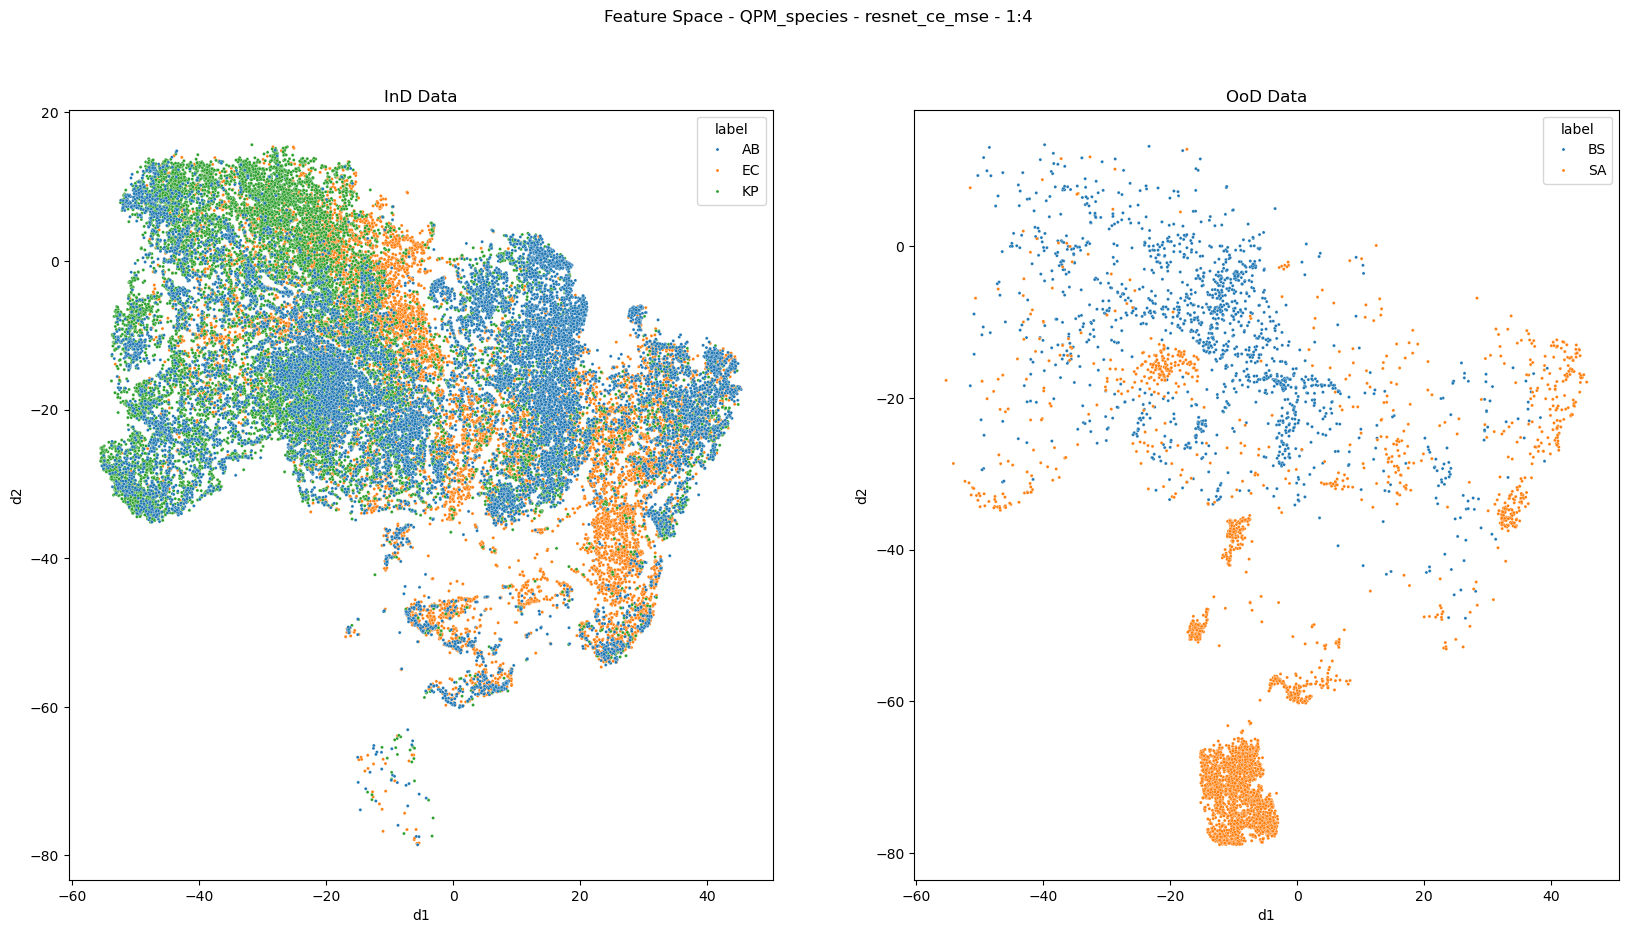

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

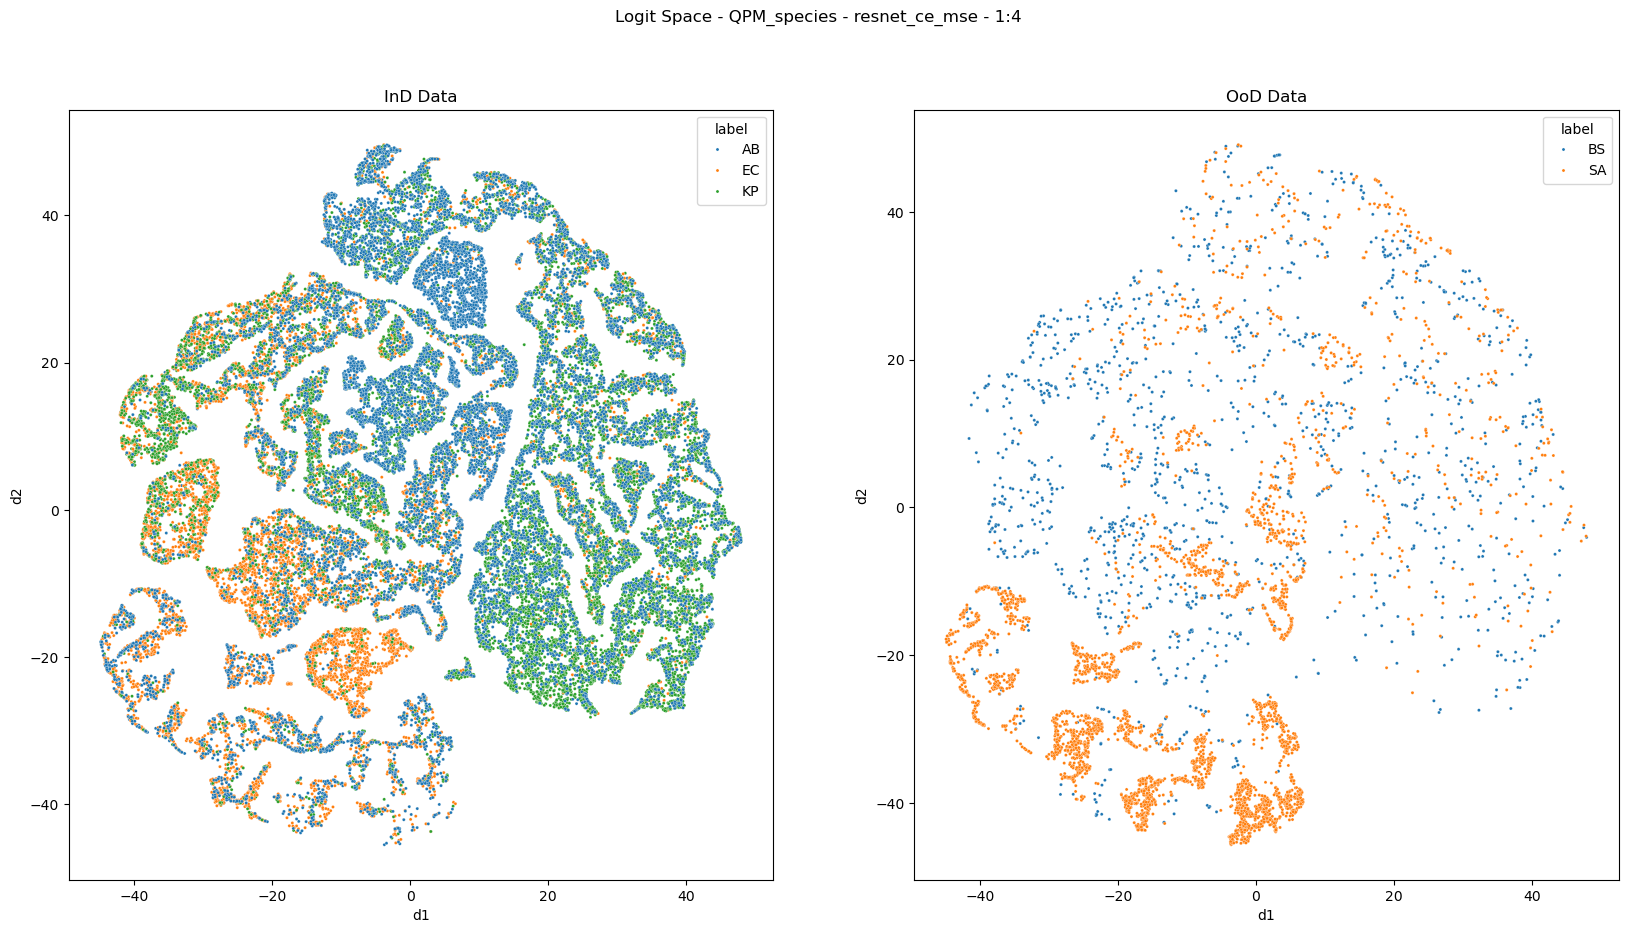

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:14<00:44, 14.80s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:29<00:29, 14.91s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:44<00:14, 14.97s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.15s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.06s/it]

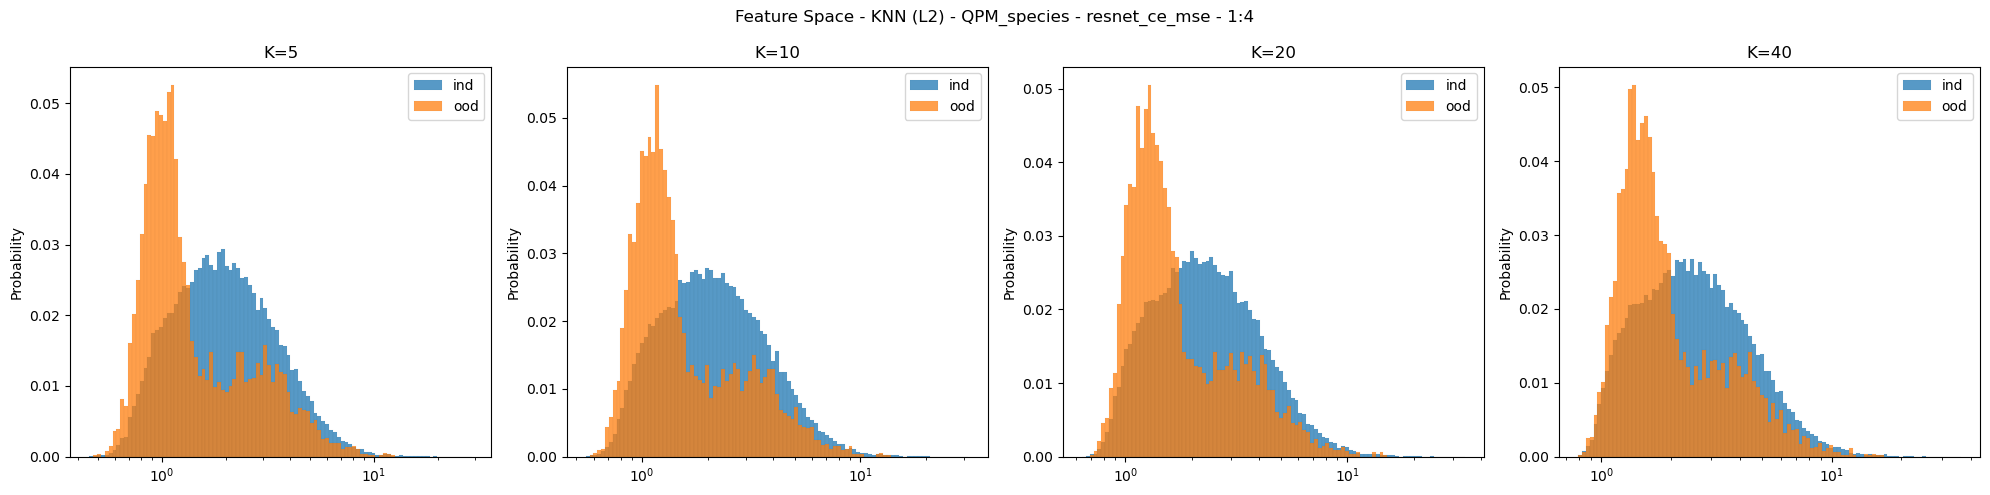

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:14<00:43, 14.59s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:29<00:29, 14.80s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:44<00:14, 14.86s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.96s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.90s/it]

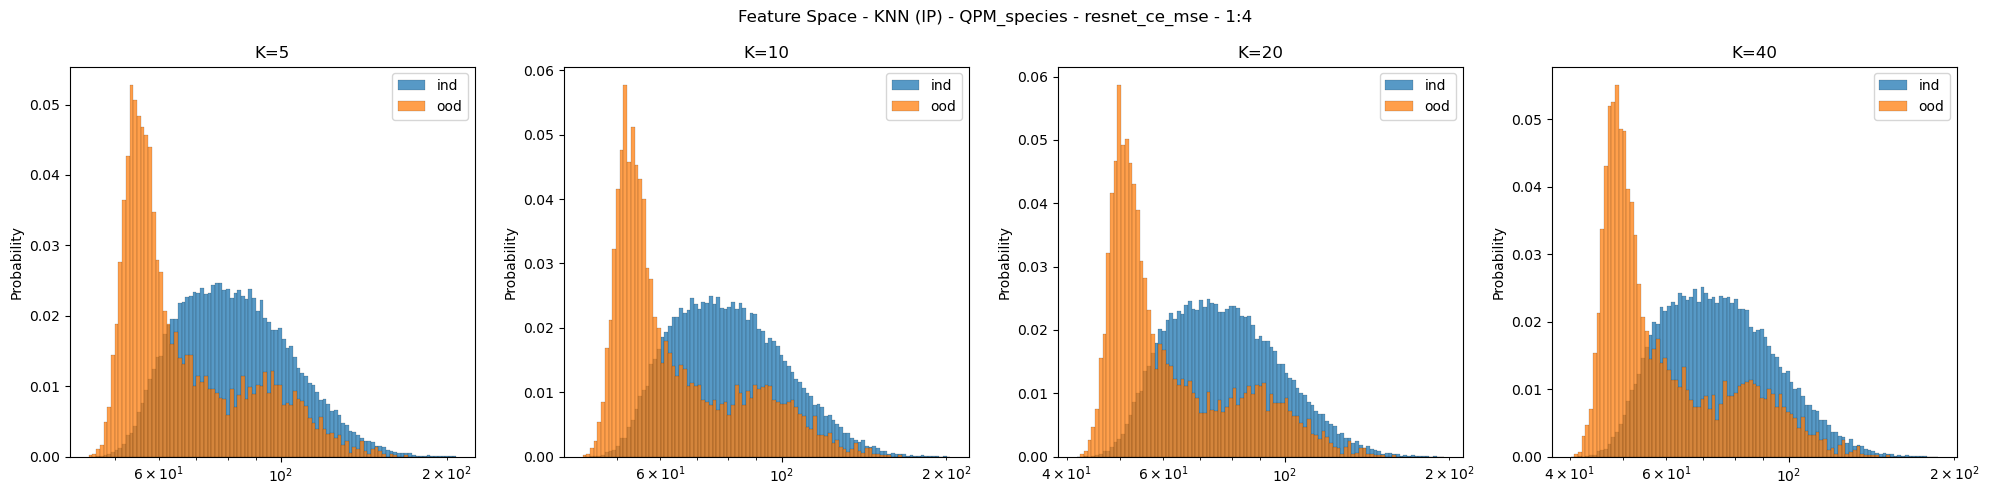

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:06,  2.06s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:04<00:04,  2.17s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:06<00:02,  2.22s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.37s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.30s/it]

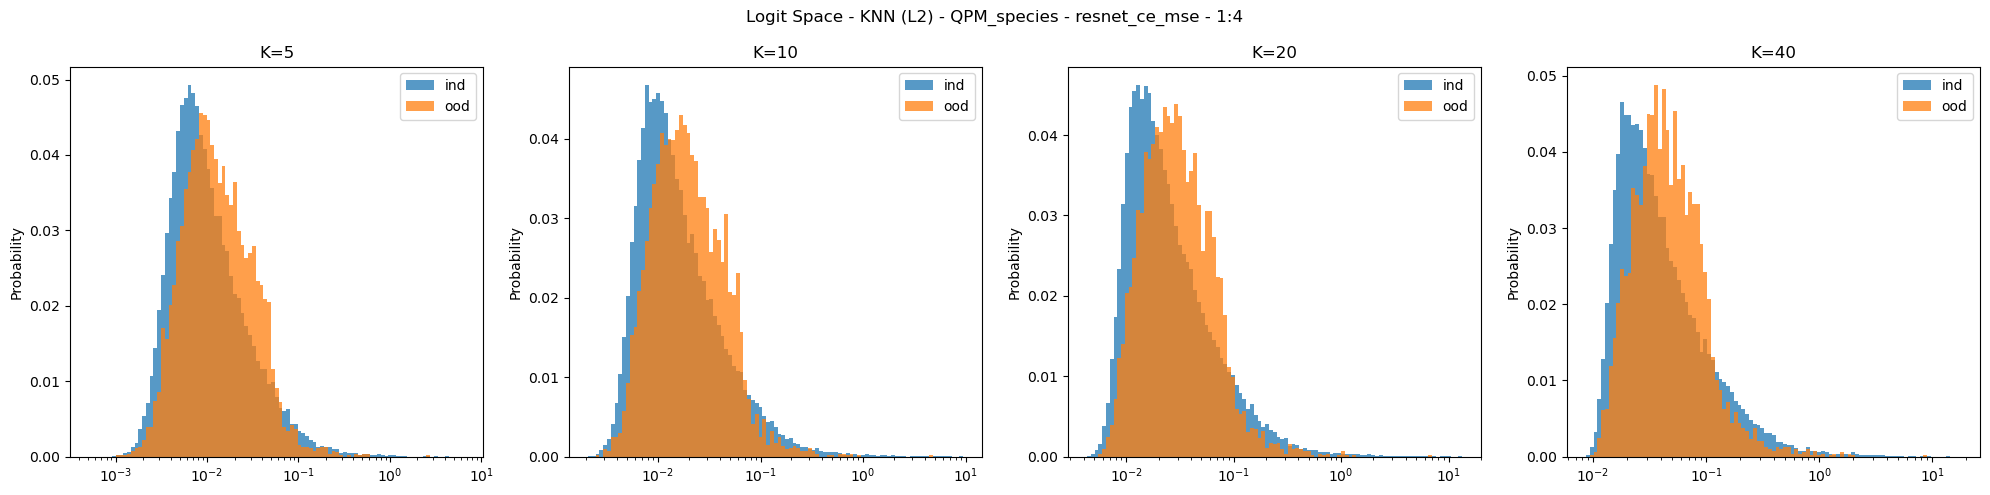

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:05,  1.79s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:03<00:03,  1.83s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:05<00:01,  1.92s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.10s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.01s/it]

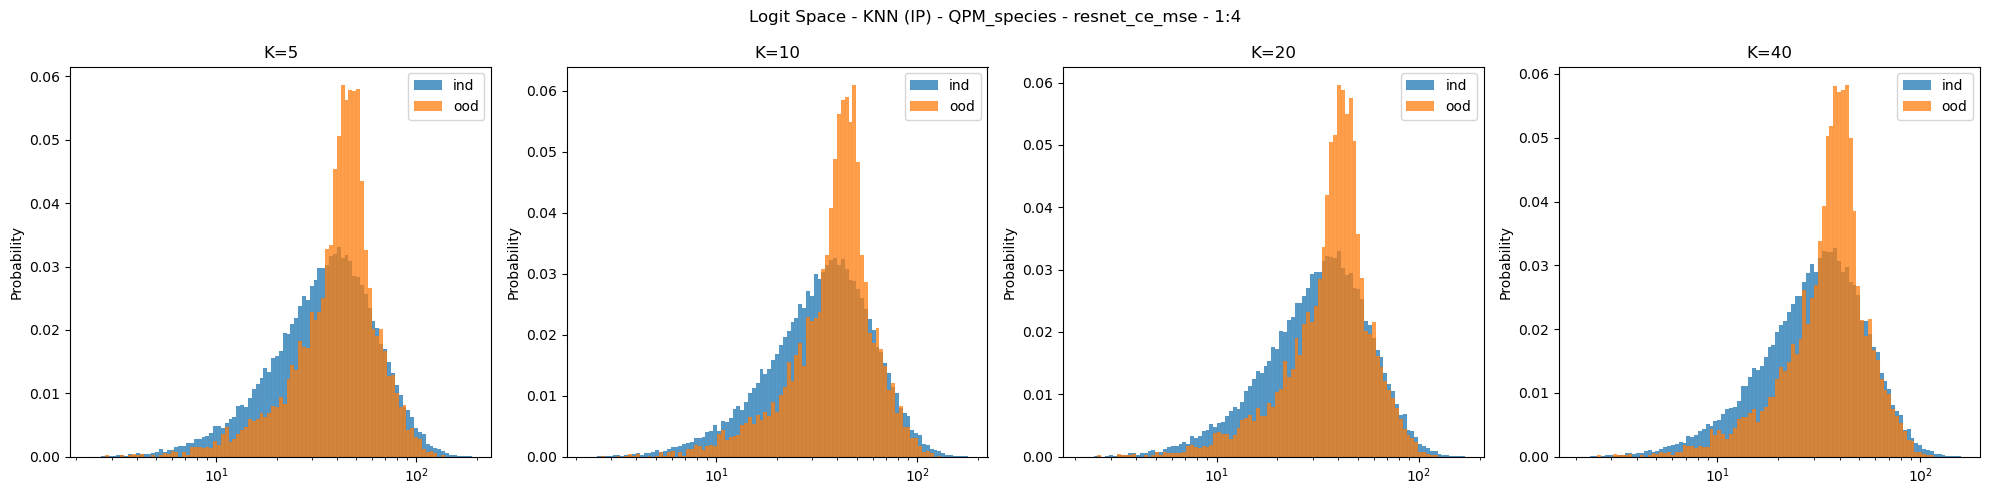

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

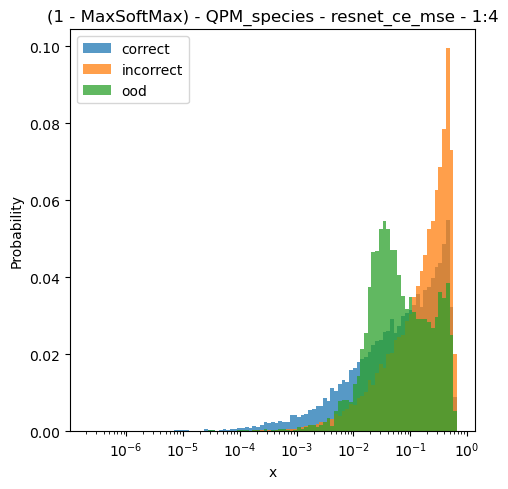

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

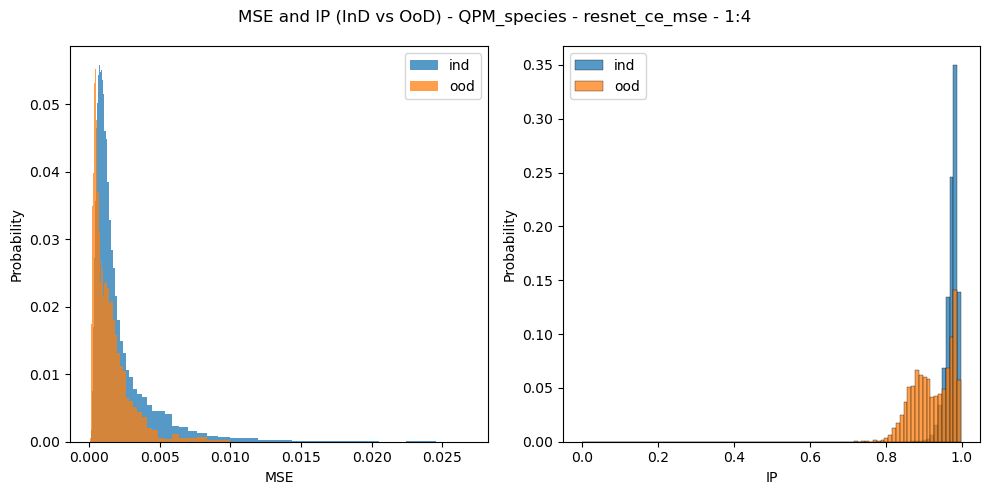

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()